In [3]:
!mkdir figs #make directories for other files
!mkdir ratings
!mkdir RStuff

mkdir: cannot create directory ‘figs’: File exists
mkdir: cannot create directory ‘ratings’: File exists
mkdir: cannot create directory ‘RStuff’: File exists


# Memento analysis
This notebook accompanies the paper: Antony et al., 2024, JoCN (Sarah DuBrow memorial issue).

Running the entire script will automatically download the generated figures/files. If you'd like to turn this off, comment out the 'download' lines in the bottom cell.

## Aims:
1. Characterize how participants mentally organize recall among several competing strategies
2. Examine factors predicting scene memorability

## Necessary uploads to run as Co-lab script
1. MementoStoryBoard.xlsx (put in main folder)
2. Subjects.xlsx (put in main folder)
3. Load in all ratings data (put in the created folder)

## Parts of this notebook:
0. [See Table of contents on the left.]
1. [This intro] + imports/functions
2. Load supporting information, like storyboard, causality ratings, transcript
4. Read in participant data and plot recall + recall strategies over time

## Resources
1. Memento movie script: https://stephenfollows.com/resource-docs/scripts/memento.pdf. NOTE this differs in some big ways from the final film. Do not use without editing! We edited it and placed it in the 'fullScript' sheet of 'MementoStoryboard.xlsx'.
2. Dialogue script: http://www.script-o-rama.com/movie_scripts/m/memento-script-transcript-pearce-nolan.html. This is not currently used is available in the 'dialogueScript' sheet of 'MementoStoryboard.xlsx'.


In [4]:
import math
import scipy
import random
import datetime
import matplotlib
import numpy as np
import numpy.matlib
import pandas as pd
import numpy.ma as ma
!pip install pingouin
import pingouin as pg
import seaborn as sns
import networkx as nx
from io import StringIO
import scipy.stats as stats
import tensorflow_hub as hub
from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import plotly.graph_objects as go
from sklearn.manifold import MDS, TSNE
from scipy.stats import norm,pearsonr,spearmanr,ttest_ind,ttest_1samp
figf="figs/"
cfs,lw=22,2 #defaults
plt.rcParams.update({'font.size': cfs})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
cm,cm2,fs0,fs1,fs2='gray','viridis',13,10,10 #colormap / fig sizes
# Load pre-trained universal sentence encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
pd.options.mode.chained_assignment = None  # default='warn' #kill warning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 4.4 MB/s eta 0:00:00


In [24]:
#functions
def findsecs(tstring): #find absolute # of seconds, based on HMS input
    date_time = datetime.datetime.strptime(tstring, "%H:%M:%S")
    a_timedelta = date_time - datetime.datetime(1900, 1, 1)
    seconds = a_timedelta.total_seconds()
    return seconds

def implot(labels,dat,xl,yl,fs1,fs2): #standard imshow plot
    f, ax = plt.subplots(1,1, figsize = (fs1,fs2))
    im=ax.imshow(dat.T,interpolation='none',cmap=cm,aspect='auto')
    ax.set_xlabel(xl,fontsize=15)
    ax.set_ylabel(yl,fontsize=15)
    if dat.shape[0]==n_ev:
      ax.set_xticks(lin_ev[4::10])
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels,fontsize=15)
    f.tight_layout()
    fn=figf + yl + ".pdf"
    plt.savefig(fn, transparent=True)

def implot_story(dat,fnl): #image plot for story
  f, ax = plt.subplots(1,1, figsize = (fs1,fs2/2))
  im=ax.imshow(dat,interpolation='none',cmap=cm,aspect='auto')
  ax.set_xlabel('Presented order time (s)')
  ax.set_ylabel('Chronological order (scene)')
  ax.set_yticks(np.arange(-0.5,dat.shape[0]-0.5,5))
  ax.set_yticklabels(np.arange(0,dat.shape[0]+1,5))
  f.tight_layout()
  fn=figf + fnl + ".pdf"
  plt.savefig(fn, transparent=True)

def plot_embed2d(embeddings,figl): #plot 2D semantic embedding data
  emb_2d = np.zeros((n_ev,n_ev))
  for ev1 in range(n_ev):
    for ev2 in range(n_ev):
      if len(text[ev1])>0:
        if len(text[ev2])>0:
          rval,pval=pearsonr(embeddings[ev1,:],embeddings[ev2,:])
          emb_2d[ev1,ev2]=rval+0
          if ev1==ev2: #zero diagonal
            emb_2d[ev1,ev2]=0#math.nan
        else:
          emb_2d[ev1,ev2]=0#math.nan
      else:
        emb_2d[ev1,ev2]=0#math.nan

  f, ax = plt.subplots(1,1, figsize = (fs1*2//3,fs2/2))
  im=ax.imshow(emb_2d,interpolation='none',cmap=cm,aspect='auto')
  ax.set_xlabel('Scene #')
  ax.set_ylabel('Scene #')
  ax.set_xticks(lin_ev[4::5])
  ax.set_yticks(lin_ev[4::5])
  cbar=f.colorbar(im)
  cbar.solids.set_edgecolor("face")
  cbar.ax.get_yaxis().labelpad = 10 #25 when rotation=270
  cbar.set_label('Semantic similarity (θ)', rotation=90)
  f.tight_layout()
  fn=figf + figl + ".pdf"
  plt.savefig(fn, transparent=True)
  #reduced version
  f, ax = plt.subplots(1,1, figsize = (fs1*2//3,fs2/2))
  im=ax.imshow(emb_2d,interpolation='none',cmap=cm,aspect='auto')
  ax.set_xlabel('Scene #')
  ax.set_ylabel('Scene #')
  ax.set_xticks(lin_ev[4::5])
  ax.set_yticks(lin_ev[4::5])
  ax.set_rasterized(True)
  f.tight_layout()
  fn=figf + figl + "_red.pdf"
  plt.savefig(fn, transparent=True)
  return emb_2d

def plotscenev(y,yl,fn,inp): #plot mean causality/importance ratings
  f, ax = plt.subplots(1,1, figsize = (fs1,fs2/2))
  x=lin_ev+0
  if inp==1:
      plt.plot(x,y,color='k',linewidth=3)
      y1,err=[],[]
  elif inp==2: # y = 2-D, use errobar
      y1=np.nanmean(y,1)
      err=np.zeros((n_ev))
      for i in range(n_ev):
          y_adj=y[i,~np.isnan((y[i,:]))]
          err[i]=np.std(y_adj)/np.sqrt(y_adj.shape[0])
      plt.errorbar(x,y1,err,color='k',linewidth=3,elinewidth=2)
  ax.set_xlabel('Scene #')
  ax.set_ylabel(yl)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  f.tight_layout()
  plt.savefig(fn, transparent=True)
  return y1,err

#function for random walk along graph
def randwalk(dat,label,meth):
  currg=dat+0
  blah=np.where(np.isnan(currg)==0)
  blah2=currg[blah]
  currthr=np.percentile(blah2,perc_thr) #minimum causality rating to keep in graph
  print('%s thresh: %s' %(label,currthr))

  qq=dat<currthr #find below threshold entries
  dat[qq]=0 #make 0s where < threshold
  asdiff=[]
  n_loops=1000
  probtype=1 #1=no importance multiplication (pure), 2=w/ importance
  poss_jump=np.zeros(((n_ev-1)*2+1,n_loops))
  for l in range(n_loops):
    if meth==0: #choose init state randomly based on importance
      tot=np.sum(y_imp)
      lik_i=y_imp/tot #initial probabilities
      lik=np.zeros((len(lik_i))) #cumulative distribution
      for i in range(len(lik)):
        lik[i]=np.sum(lik_i[0:i+1])
      randval=random.uniform(0,1) #find random value between 0-1
      #randval=0.01
      chosen=np.where(randval<lik)[0] #figure out path to go down
      curr_st=chosen[0]
    elif meth==1: #choose init state via uniformly random dist
      curr_st=random.randint(0,len(y_imp)-1)
    elif meth==2: #assign initial state to first value
      curr_st=1
    all_st=[]
    for endless in range(100):
      all_st.append(curr_st)
      #previously ended @ final scene
      #if curr_st==0: #end state
      randval=random.uniform(0,1) #find random value between 0-1
      if randval<0.01: #1% chance of ending recall
        if len(asdiff)==0:
          asdiff=np.diff(all_st) #calculate asdiff
        else:
          asdiff=np.hstack([asdiff,np.diff(all_st)])
        break
      poss=np.where(dat[curr_st,:]>0)[0]
      if probtype==1:
        tot=np.sum(dat[curr_st,poss])
        lik_i=dat[curr_st,poss]/tot #initial probabilities
      elif probtype==2:
        temp=np.multiply(dat[curr_st,poss],y_imp[poss])
        tot=np.sum(temp)
        lik_i=temp/tot #initial probabilities
      lik=np.zeros((len(lik_i))) #cumulative distribution
      for i in range(len(lik_i)):
        lik[i]=np.sum(lik_i[0:i+1])
      randval=random.uniform(0,1) #find random value between 0-1
      chosen=np.where(randval<lik)[0] #figure out path to go down
      poss_jump[int(n_ev-curr_st-1):int(n_ev-curr_st+n_ev-1),l]=poss_jump[int(n_ev-curr_st-1):int(n_ev-curr_st+n_ev-1),l]+1
      curr_st=poss[chosen[0]]
  poss_jump_m=np.mean(poss_jump,axis=1) #grab mean to output
  return asdiff,poss_jump_m

def asdiff_plot(dat,poss,xl): #plot transition vector as PDF
  fir=np.min(df['BroadSceneNum']) #first scene
  las=np.max(df['BroadSceneNum']) #last scene
  maxj=las-fir #maximum jump (lag) in either direction
  js=np.linspace(-maxj,maxj+1,int(maxj*2+2)) #transition space
  distr=np.histogram(dat,js)
  q=poss>0 #avoid divide by 0
  distr[0][q]=np.divide(distr[0][q],poss[q]) #divide by POSSIBLE transitions to make conditional
  ideal_pdf=distr[0]*100/np.sum(distr[0]) #transition probability as a PDF
  ideal_pdf[int(maxj)]=math.nan #nan out 0
  f, ax = plt.subplots(1,1,figsize = (12,4))
  plt.plot(js[:-1],ideal_pdf)
  ax.set_xlabel('Transitions, ' + xl)
  ax.set_ylabel(crp_lab)
  return ideal_pdf,fir,las,maxj,js

def barswarm(d1,d2,d3,d4,lab,yl,fn,exv): #plot basic comparisons for >1 exp
    fs,fsz,msz=33,9,9
    if exv==2:
      fs=22
    elif exv==4:
      fs=22
    dat1=pd.DataFrame({'Experiment':['E1, free']*len(d1),lab:d1})
    dat2=pd.DataFrame({'Experiment':['E2, pres']*len(d2),lab:d2})
    if np.logical_or(exv==4,exv==8):
      dat2=pd.DataFrame({'Experiment':['E4, re-stitched']*len(d2),lab:d2})
    dat = pd.concat([dat1, dat2],ignore_index=True)
    endpt=1.5
    if len(d3)>0:
      dat3=pd.DataFrame({'Experiment':['E3, chrono']*len(d3),lab:d3})
      dat = pd.concat([dat, dat3],ignore_index=True)
      endpt=2.5
      if len(d4)>0:
        dat4=pd.DataFrame({'Experiment':['E4, re-stitched']*len(d4),lab:d4})
        if exv>4:
          dat4=pd.DataFrame({'Experiment':['E1-3']*len(d4),lab:d4})
        if exv!=2:
          dat = pd.concat([dat, dat4],ignore_index=True)
    else:
      dat2=pd.DataFrame({'Experiment':['E4, re-stitched']*len(d2),lab:d2})
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz*2/3))
    cp = sns.color_palette("colorblind")
    join_y="-"
    if np.logical_and(exv>4,exv<7):
      lgr=0.75
      cp[3]=(lgr,lgr,lgr) #make 4th same gray
      join_y="none"
      if exv==5:
        cp[0],cp[1],cp[2]=(lgr,lgr,lgr),(lgr,lgr,lgr),(lgr,lgr,lgr)
    elif exv==4:
      join_y="none"
      cp[0]=[0,0,1]
      cp[1]=[1,0,0]
    elif exv>6:
      join_y="none"
      cp[0]=[0,0,1]
      cp[1]=[1,0,0]
    ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],hue=dat['Experiment'],palette=cp,facecolor=None,size=msz,zorder=1)#color=cp
    ax=sns.pointplot(x=dat['Experiment'],y=dat[lab],color='k',linestyles=join_y,#palette=cp,#color=cp,#saturation=1,
                     err_kws={'linewidth': lw*2},capsize=.2) #errwidth=lw*2,linestyles=['None']
    ax.set_ylabel(yl,fontsize=fs)
    if exv>4:
      ax.set_ylabel(yl,fontsize=fs*2/3)
    ax.set_xlabel('Experiment',fontsize=fs)
    if exv>1:
      ax.tick_params(axis='both', which='major', labelsize=fs)
    if exv>4:
      ax.set_xlabel('Experiment',fontsize=fs*2/3)
      ax.tick_params(axis='both', which='major', labelsize=fs*2/3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    if exv==0:
        ax.hlines(0,-0.5,endpt,color="black")
    elif exv==2:
        ax.hlines(0,-0.5,endpt,color="black",linestyles='dashed')
    elif exv==4:
        ax.hlines(0,-0.5,endpt,color="black",linestyles='dashed')
    elif exv==5:
        fir_perm_m=np.nanmean(stay_perc_perm[conds.astype(int)==1])
        sec_perm_m=np.nanmean(stay_perc_perm[conds.astype(int)==2])
        thi_perm_m=np.nanmean(stay_perc_perm[conds.astype(int)==3])
        all_perm_m=np.nanmean(stay_perc_perm[conds.astype(int)<4])
        ax.hlines(fir_perm_m,-0.25,0.25,color="black",linestyles='dashed')
        ax.hlines(sec_perm_m,0.75,1.25,color="black",linestyles='dashed')
        ax.hlines(thi_perm_m,1.75,2.25,color="black",linestyles='dashed')
        ax.hlines(all_perm_m,2.75,3.25,color="black",linestyles='dashed')
        ax.vlines(2.5,0.2,0.8,color="black",linestyles='dashed')
    elif exv==6:
        endpt=3.5
        if len(d4)>0:
          lowpt,highpt=np.min(d4),np.max(d4)
          ax.vlines(2.5,lowpt,highpt,color="black",linestyles='dashed')
          ax.hlines(0,-0.5,endpt,color="black",linestyles='dashed')
        else:
          ax.hlines(0,-0.5,endpt-1,color="black",linestyles='dashed')
    elif exv>6:
        ax.hlines(0,-0.5-0.2,endpt+0.2,color="black")#,linestyles='dashed'
        if exv==8:
          ax.hlines(chance_line,-0.5,endpt,color="black",linestyles='dashed')
    f.tight_layout()
    f.savefig(fn, transparent=True)

def plot_strat(dat,fn,yl,exv,chl):
  f, ax = plt.subplots(1,1, figsize = (9,6))
  n_pred_use=n_pred+0
  if chl==1:
    n_pred_use=n_predp+0
  x=np.linspace(0,n_pred_use-1,n_pred_use)
  if exv==0:
    for ii in range(3):
      y=dat[conds1_3.astype(int)==ii+1,:]+0
      y1=np.nanmean(y,axis=0)
      s_ord=np.linspace(0,n_pred_use-1,n_pred_use).astype(int)
      preds_s_ord=[None]*n_pred_use #lists don't let you refer using np arrays, so this
      for i in range(n_pred_use):
        preds_s_ord[i]=preds[s_ord[i]]
      err=np.zeros((n_pred_use))
      nnanv=len(np.where(y[:,0]>0)[0])
      for i in range(n_pred_use):
          err[i]=np.nanstd(y[:,i])/np.sqrt(nnanv)
      plt.errorbar(x+(0.05*(int(ii)+1)),y1[s_ord],err[s_ord],linewidth=3,elinewidth=2)

    y=dat+0
    y1=np.nanmean(y,axis=0)
    s_ord=np.linspace(0,n_pred_use-1,n_pred_use).astype(int)
    preds_s_ord=[None]*n_pred_use
    for i in range(n_pred_use):
      preds_s_ord[i]=preds[s_ord[i]]
    err=np.zeros((n_pred_use))
    nnanv=len(np.where(y[:,0]>0)[0])
    for i in range(n_pred_use):
        err[i]=np.nanstd(y[:,i])/np.sqrt(nnanv)
    plt.errorbar(x,y1[s_ord],err[s_ord],color='k',linewidth=5,elinewidth=3)
  elif exv==1:
    currc=[1,4]
    for ii in range(len(currc)):
      y=dat[conds.astype(int)==currc[ii],:]+0 #cond 1 / 4
      y1=np.nanmean(y,axis=0)
      s_ord=np.linspace(0,n_pred_use-1,n_pred_use).astype(int)
      preds_s_ord=[None]*n_pred_use
      for i in range(n_pred_use):
        preds_s_ord[i]=preds[s_ord[i]]
      err=np.zeros((n_pred_use))
      nnanv=len(np.where(y[:,0]>0)[0])
      for i in range(n_pred_use):
          err[i]=np.nanstd(y[:,i])/np.sqrt(nnanv)
      if ii==0:
        ccol=[0,0,1]
      elif ii==1:
        ccol=[1,0,0]
      plt.errorbar(x+(0.05*(int(ii)+1)),y1[s_ord],err[s_ord],color=ccol,linewidth=5,elinewidth=3)

  ax.set_xticks(np.arange(n_pred_use))
  ax.set_xticklabels(preds_s_ord,fontsize=21,rotation=22.5)
  ax.set_xlabel('Strategy',fontsize=24)
  ax.set_ylabel(yl,fontsize=24)
  ax.set_ylim([-0.05,0.6])
  if exv==0:
    ax.legend(['E1, free','E2, pres','E3, chrono','E1-3'],ncol=1,loc='upper left',fontsize=16)
  elif exv==1:
    ax.legend(['E1, free','E4, re-stitched'],ncol=1,loc='upper left',fontsize=16)
  if chl==1:
    ax.hlines(chance_line,0,n_pred-1,color="black",linestyles='dashed')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)

  f.tight_layout()
  plt.savefig(fn, transparent=True)

def barswarm_a(d1,lab,yl,fn,exv,chance): #combined barswarm plot for multiple experiments
    fs,fsz,msz=30,9,9
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz*2/3))
    cp = sns.color_palette("colorblind")
    if exv==0:
      dat=pd.DataFrame({'Experiment':['Experiments 1-3, combined']*len(d1),lab:d1})
      ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],color='k',facecolor=None,size=msz,zorder=1)#color=cp
      ax=sns.pointplot(x=dat['Experiment'],y=dat[lab],color='k',
                      err_kws={'linewidth': lw*2},capsize=.2)
    elif exv==1:
      dat=pd.DataFrame({lab:d1})
      ax=sns.swarmplot(y=dat[lab],color='k',facecolor=None,size=msz,zorder=1)#color=cp
      ax=sns.pointplot(y=dat[lab],color='k',err_kws={'linewidth': lw*2},capsize=.2)
      ax.set_xlabel('Experiments 1-3, combined',fontsize=fs)
    ax.set_ylabel(yl,fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    if exv==0:
      ax.hlines(0,-0.5,0.5,color="black",linestyles='dashed')
    elif exv==1:
      ax.hlines(chance,-0.5,0.5,color="black",linestyles='dashed')
    f.tight_layout()
    f.savefig(fn, transparent=True)

def rd(dat,dig): #shorter rounding function
    r=round(dat,dig)
    return r

def astats1(g1,popm,tn): #outputs t-stat, p value, and cohen's dz, given one sample group
    r=pd.DataFrame()
    b,dg=np.zeros((1)),3 #pre-assign one blank row
    stat,p=stats.ttest_1samp(g1,popmean=popm)
    tstat,p_ttest=stat+0,p+0 #avoid errors
    eff_sz=np.nanmean(g1)/np.nanstd(g1) #Cohen's dz
    res = pg.ttest(g1,popm)
    lb=res['CI95%'][0][0]
    ub=res['CI95%'][0][1]
    zstat=0
    n1=np.sum(~np.isnan(g1))
    df=n1-1
    g1m,g1s=np.nanmean(g1),np.nanstd(g1)/np.sqrt(n1)
    r['meth'],r['g1n'],r['g1m'],r['g1s'],r['df'],r['stat']=b,b,b,b,b,b
    r['zstat'],r['tstat'],r['p'],r['eff_sz'],r['g1med'],r['p_ttest']=b,b,b,b,b,b
    r['p'],r['p_ttest'],r['stat'],r['zstat']=rd(p,dg),rd(p_ttest,dg),rd(stat,dg),rd(zstat,dg)
    r['tstat'],r['eff_sz'],r['df']=rd(tstat,dg),rd(eff_sz,dg),rd(df,dg)
    r['g1m'],r['g1s']=rd(g1m,dg),rd(g1s,dg)
    r['g1n'],r['g1med']=n1,np.nanmedian(g1)
    r['lb'],r['ub']=b,b
    r['lb'],r['ub']=lb,ub
    print(tn)
    print(r)
    print('\n')
    return r

def astats3(g1,g2,tn): #outputs KS stat and p value, given two unpaired groups
    r=pd.DataFrame()
    b,dg=np.zeros((1)),3
    tstat,p=stats.ttest_ind(g1,g2)
    res = pg.ttest(g1,g2, paired=False)
    n1,n2=np.sum(~np.isnan(g1)),np.sum(~np.isnan(g2))
    df=n1+n2-2
    pools=np.sqrt(((n1-1)*np.nanvar(g1)+(n2-1)*np.nanvar(g2))/df)
    d=(np.nanmean(g1)-np.nanmean(g2))/pools #Cohen's d
    g1m,g2m,g1s,g2s=np.nanmean(g1),np.nanmean(g2),np.nanstd(g1)/np.sqrt(n1),np.nanstd(g2)/np.sqrt(n2)
    r['g1n'],r['g1m'],r['g1s'],r['g1med'],r['g2n'],r['g2m'],r['g2s'],r['g2med']=b,b,b,b,b,b,b,b
    r['df'],r['tstat'],r['p'],r['d']=b,b,b,b
    r['p'],r['tstat'],r['d'],r['df']=rd(p,dg),rd(tstat,dg),rd(d,dg),rd(df,dg)
    r['g1m'],r['g2m'],r['g1s'],r['g2s']=rd(g1m,dg),rd(g2m,dg),rd(g1s,dg),rd(g2s,dg)
    r['g1n'],r['g2n'],r['g1med'],r['g2med']=n1,n2,np.nanmedian(g1),np.nanmedian(g2)
    r['lb'],r['ub']=b,b
    r['lb'],r['ub']=res['CI95%'][0][0],res['CI95%'][0][1]
    print(tn)
    print(r)
    print('\n')
    return r

def fishr2z(dat): #Fisher's r-to-z transform
    dat=np.multiply((np.log([1+dat])-np.log([1-dat])),0.5)
    return dat

def _get_markov_edges(Q): #maps transition probability df to edges and weights
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

def create_network(dat,thr): #create network graph
  # create state space and initial state probabilities
  slabs=[]
  for i in range(n_ev):
      slabs.append(str(i+1))

  pi = np.zeros((len(slabs)))
  pi[0]=1 #start in start state
  state_space = pd.Series(pi, index=slabs, name='states')
  q_df = pd.DataFrame(columns=slabs, index=slabs)
  for i in range(len(slabs)):
      q_df.loc[slabs[i]]=dat[i,:] # create transition matrix
  q=q_df.values
  edges_wts = _get_markov_edges(q_df)

  G=nx.MultiDiGraph() # create graph object
  G.add_nodes_from(slabs) # nodes correspond to states
  # edges represent transition probabilities - create below
  j=0
  for k, v in edges_wts.items():
      tmp_origin, tmp_destination = k[0], k[1]
      if v>thr: #0
          G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
          if tmp_origin > tmp_destination:
              if j==0:
                  color_map_e=[1,0,0]
                  j=1
              else:
                  color_map_e=np.vstack([color_map_e,[1,0,0]])
          else:
              if j==0:
                  color_map_e=[0,1,0]
                  j=1
              else:
                  color_map_e=np.vstack([color_map_e,[0,0,1]])

  edge_weights0={(n1,n2):d['weight'] for n1,n2,d in G.edges(data=True)}
  edge_weights=list(edge_weights0.values())
  print(len(edge_weights))

  color_map=[]
  for node in range(n_ev-1):
      if node%2==0:
          color_map.append('orange')
      else:
          color_map.append('red')
  color_map.append('cyan')
  return G,edge_weights,color_map

def network_plot(G,ew,node_szs,ed_mult,figl): #plot network (Fig 1)
  f, ax = plt.subplots(1,1,figsize = (9,9))
  pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')

  nx.draw_networkx(G, pos,node_color=cmap_caus,#node_color='white',
                  font_size=15,node_size=node_szs*no_mult)

  # create edge labels for jupyter plot but is not necessary
  edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
  edges=nx.draw_networkx_edges(G,pos,node_size=node_szs*no_mult,width=2)
  M = G.number_of_edges()
  for i in range(M):
      edges[i].set_linewidth(ew[i]*ed_mult)
  f.tight_layout()
  fn="figs/"+figl+str(node_sz_meth)+".pdf"
  sps=['top','bottom','left','right']
  for i in range(len(sps)):
      ax.spines[sps[i]].set_visible(False)
  plt.savefig(fn, transparent=True)

def quicksp(x,y,xl,yl,fn): #quick scatterplots (Fig 3)
  f, ax = plt.subplots(1,1,figsize = (9,6))
  ax.scatter(x,y,c='black')
  ax.set_xlabel(xl)
  ax.set_ylabel(yl)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  a, b = np.polyfit(x,y, 1)
  rval,pval=pearsonr(x,y)
  rval_s,pval_s=spearmanr(x,y) #verify with spearman
  if isinstance(x, list):
    x = np.array(x)
  print(xl,rval,pval,rval_s,pval_s)
  plt.plot(x, a*x+b,'k',linewidth=3)
  txt='$\it{r}$ = %.2f' %(rval) #text to put on plot
  if pval<0.05:
    txt='$\it{r}$ = %.2f*' %(rval)
    if pval<0.01:
      txt='$\it{r}$ = %.2f**' %(rval)
  plt.text(0.85, 0.15,txt,horizontalalignment='center',
     verticalalignment='center',transform = ax.transAxes,fontsize=24) #0.2
  f.tight_layout()
  f.savefig(fn, transparent=True)

def plot_ideal(dat,dat2,dat3,dat4,col,yl,fn,exv): #plot ideal templates (Fig 2)
  f, ax = plt.subplots(1,1,figsize = (12,4))
  lw=3
  y=dat+0
  ax.plot(x,y,col,linewidth=lw)
  if len(dat2)>0:
    ax.plot(x,dat2,'r',linewidth=lw)
    ax.plot(x,dat3,'g',linewidth=lw)
    ax.plot(x,dat4,'c',linewidth=lw)
  if exv==0:
    if np.nanmax(dat)<2: #ideal semantic
      ax.set_yticks([0,1,2])
      ax.set_ylim([0,2])
    elif np.nanmax(dat)<4: #ideal visual
      ax.set_ylim([0,4])
    elif np.nanmax(dat)<8: #ideal causal
      ax.set_ylim([0,8])
    ax.set_xlabel('Presented order lag')
    ax.set_ylabel(yl)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  if len(dat2)>0:
    ax.legend(['Ideal pres ord sub','Ideal chrono sub','Ideal causal sub',
           'Ideal semantic sub'],loc='upper right',frameon=False)
  f.tight_layout()
  fn=figf+fn+'.pdf'
  f.savefig(fn, transparent=True)

# Load storyboard data

In [6]:
df = pd.read_excel('MementoStoryBoard.xlsx','storyBoard') #read in data
df['Secs']="" #pre-assign empty secs column
opening=0 #opening length (in s) ##### To do!!!
for i in range(df.shape[0]):
    df['Secs'][i]=findsecs(str(df['Time'][i]))
df['Secs']=df['Secs']-opening
cols = df.columns.tolist() #re-orders columns
cols = cols[-1:] + cols[:-1] #grabs the last column and puts it first
df = df[cols] #assign the dataframe to have new column order
tsecs=int(df['Secs'][df.shape[0]-1]) #total seconds
n_ev=int(np.nanmax(df['BroadSceneNum']))
print('total seconds:',tsecs)
print(n_ev)
lin_ev=np.linspace(1,n_ev,n_ev)
n_sub=np.zeros((n_ev)) #for each broad scene, how many subscenes?
for i in range(n_ev):
  n_sub[i]=len(np.where(df['BroadSceneNum']==i+1)[0])
df.head() #print to view

total seconds: 6627
44


Secs  OverallScene      Time Character1 Character2 Character3  \
0    0.0             1  00:00:00    Leonard      Teddy        NaN   
1  169.0             2  00:02:49    Leonard        NaN        NaN   
2  193.0             3  00:03:13    Leonard       Burt      Teddy   
3  217.0             4  00:03:37    Leonard      Teddy        NaN   
4  239.0             5  00:03:59    Leonard      Teddy        NaN   

                 Place                                        Explanation  \
0  Abandoned warehouse    Leonard refreshes polaroid after shooting Teddy   
1           Motel room  Leonard wakes up, wonders how long he's been i...   
2          Motel lobby  Leonard asks Burt about Teddy, Teddy picks him up   
3    Motel parking lot                      Leonard and Teddy walk to car   
4        Leonard's car              Leonard and Teddy talk inside the car   

   BroadSceneNum  SubsceneNum NarrativePart  StoryOrderSceneNum  \
0            1.0          1.0      Backward                44.0   
1            2.0          1.0       Forward                 1.0   
2            3.0          1.0      Backward                43.0   
3            3.0          2.0      Backward                43.0   
4            3.0          3.0      Backward                43.0   

  Added into Clipped version                                     Unnamed: 12  
0                        NaN                           Narrative Parts Guide  
1                        yes      Backward = story going backward (from end)  
2                        NaN  Forward = story going forward (from beginning)  
3                        NaN                         FlashbackWithinBackward  
4                        NaN                          FlashbackWithinForward

In [7]:
#character list
a,b,c=list(set(df['Character1'])),list(set(df['Character2'])),list(set(df['Character3']))
chars=set(a+b+c) #combine
chars = [x for x in chars if str(x) != 'nan']
chars.remove('[start credits]')
#chars.remove('Doctor1') #if we want to remove peripheral characters
chars.sort()
print('Characters: %s, total #: %s' %(chars,len(chars)))

#narrative part list
narpar=list(set(df['NarrativePart']))
narpar = [x for x in narpar if str(x) != 'nan']
narpar.sort()
print('Narrative parts: %s, total #: %s' %(narpar,len(narpar)))

#place list
places=list(set(df['Place']))
places = [x for x in places if str(x) != 'nan']
places.sort()
print('Places: %s, total #: %s' %(places,len(places)))

Characters: ['Burt', 'Doctor', 'Dodd', 'Emma', 'Escort', 'Jimmy Grant', 'John G', 'Leonard', "Leonard's wife", 'Natalie', 'Random man', 'Sammy', "Sammy's wife", 'Teddy', 'Unknown caller', 'Waiter'], total #: 16
Narrative parts: ['Backward', 'FlashbackWithinBackward', 'FlashbackWithinForward', 'Forward'], total #: 4
Places: ['Abandoned warehouse', 'Care home', 'Diner', "Doctor's office", "Dodd's motel room", "Emma's Tattoo", "Ferdy's Bar", "Leonard's car", "Leonard's house", "Leonard's office", 'Motel lobby', 'Motel parking lot', 'Motel room', "Natalie's house", "Outside of Dodd's motel room", "Outside of Natalie's house", 'Parking garage', "Sammy Jankis's house", 'Unknown outside location', 'Unknown ruin location'], total #: 20


# Create plots of characters, event models, and places over time

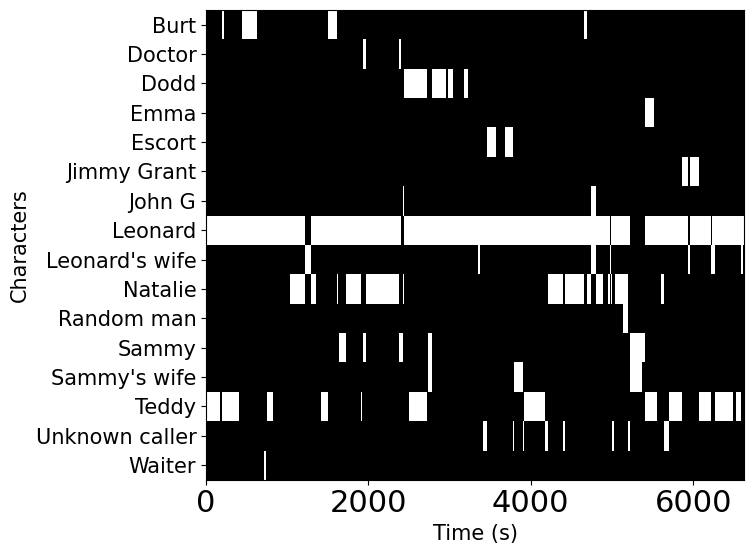

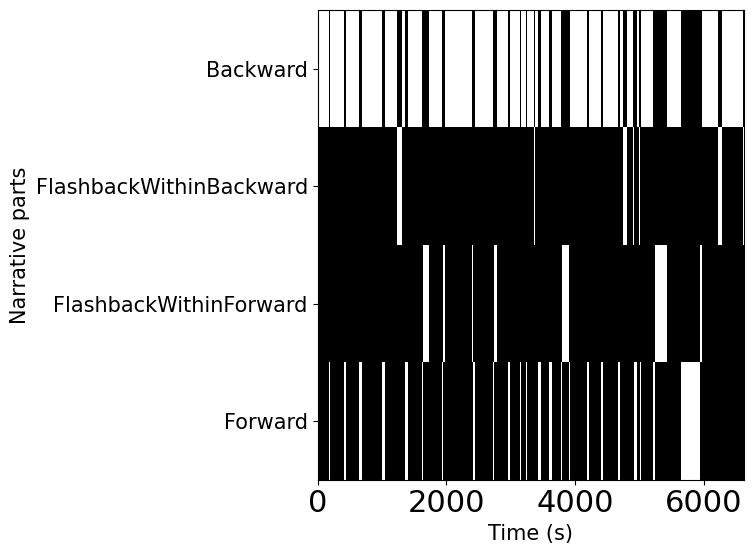

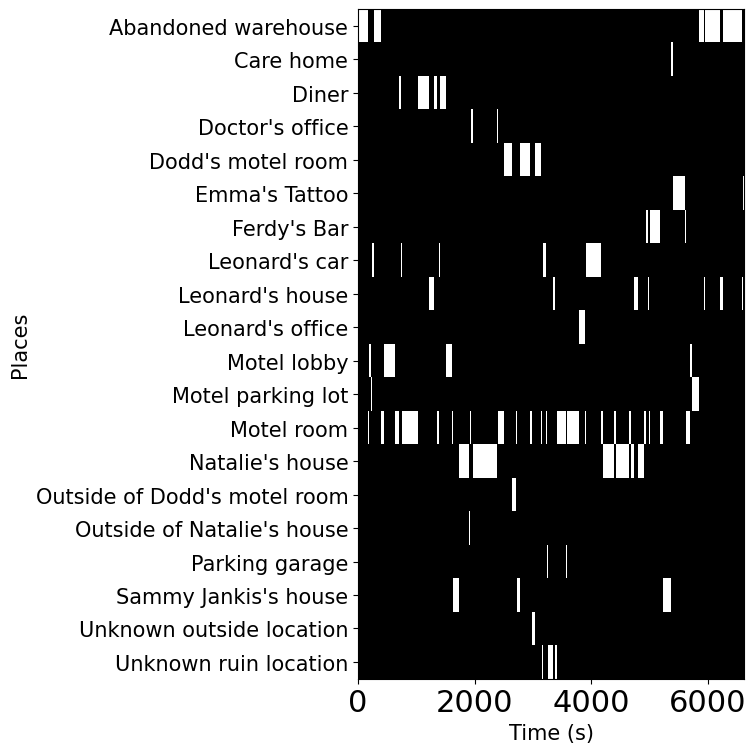

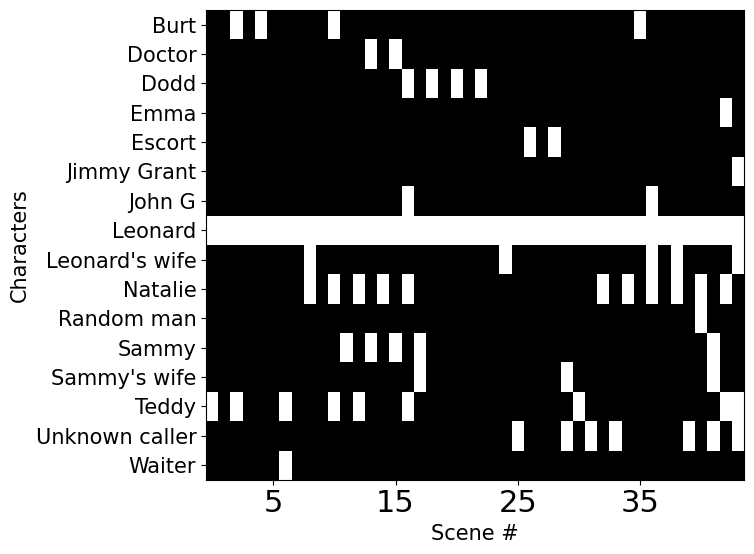

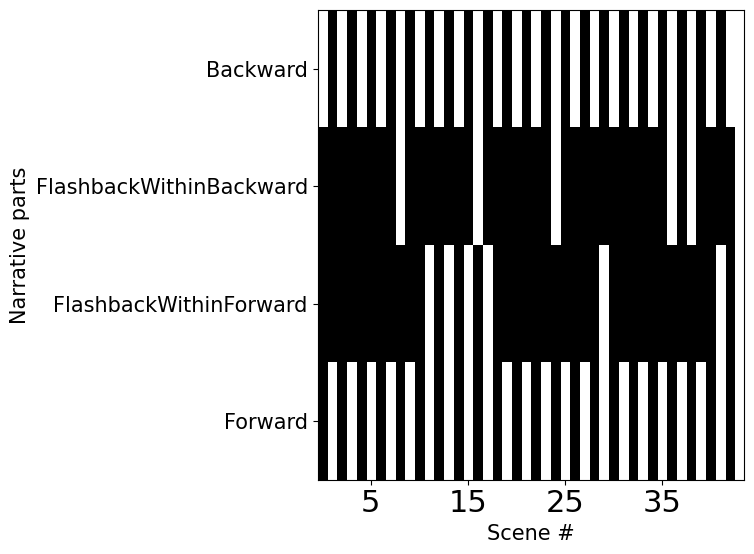

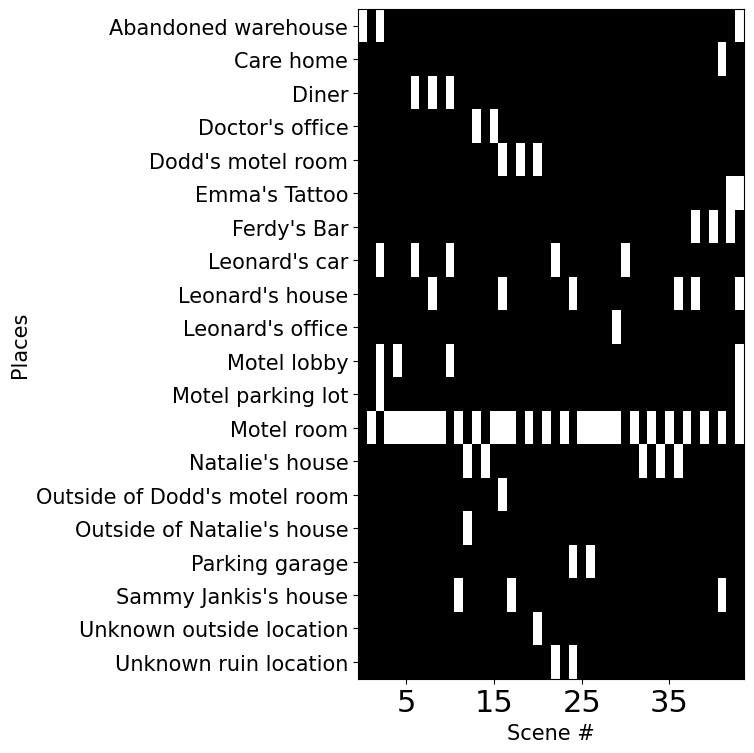

In [8]:
cmat,npmat,pmat=np.zeros((tsecs,len(chars))),np.zeros((tsecs,len(narpar))),np.zeros((tsecs,len(places)))
cmat_sc,npmat_sc,pmat_sc=np.zeros((n_ev,len(chars))),np.zeros((n_ev,len(narpar))),np.zeros((n_ev,len(places)))
for i in range(df.shape[0]-1): #scene by scene, up to last moment
    fsec=int(df['Secs'][i]) #first second in the scene
    lsec=int(df['Secs'][i+1]) #last second in the scene
    sc_num=int(df['BroadSceneNum'][i]-1)
    for ii,c in enumerate(chars):
        if df['Character1'][i]==chars[ii]:
            cmat[fsec:lsec,ii]=1
            cmat_sc[sc_num,ii]=1
        if df['Character2'][i]==chars[ii]:
            cmat[fsec:lsec,ii]=1
            cmat_sc[sc_num,ii]=1
        if df['Character3'][i]==chars[ii]:
            cmat[fsec:lsec,ii]=1
            cmat_sc[sc_num,ii]=1
    for ii,l in enumerate(narpar):
        if df['NarrativePart'][i]==narpar[ii]:
            npmat[fsec:lsec,ii]=1
            npmat_sc[sc_num,ii]=1
    for ii,l in enumerate(places):
        if df['Place'][i]==places[ii]:
            pmat[fsec:lsec,ii]=1
            pmat_sc[sc_num,ii]=1

implot(chars,cmat,'Time (s)','Characters',8,6) #plot attributes over time (s)
implot(narpar,npmat,'Time (s)','Narrative parts',8,6)
implot(places,pmat,'Time (s)','Places',8,8)
implot(chars,cmat_sc,'Scene #','Characters',8,6) #plot by scene #
implot(narpar,npmat_sc,'Scene #','Narrative parts',8,6)
implot(places,pmat_sc,'Scene #','Places',8,8)

Text(0, 0.5, 'Scene #')

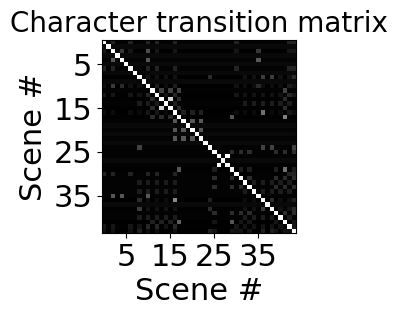

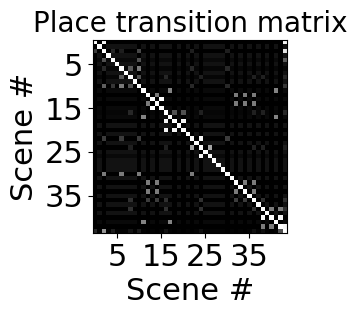

In [9]:
#create character/place transition matrix - not used b/c network graphs are disconnected
char_trans,place_trans=np.zeros((n_ev,n_ev)),np.zeros((n_ev,n_ev))
for i in range(n_ev):
  char_trans[i,i]=math.nan
  place_trans[i,i]=math.nan
  #identify characters in broad scene
  curr_char=np.where(cmat_sc[i,:])[0]
  n_curr_char=len(curr_char)
  #find transitions to other scenes
  for ii in range(n_curr_char):
    curr_trans=np.where(cmat_sc[:,curr_char[ii]])[0]
    curr_trans=curr_trans[curr_trans!=i] #remove identity scene
    buff=np.zeros((len(curr_trans)))+1
    char_trans[i,curr_trans]=char_trans[i,curr_trans]+buff/len(curr_trans)

  #identify places in broad scene
  curr_place=np.where(pmat_sc[i,:])[0]
  n_curr_place=len(curr_place)
  #find transitions to other scenes
  for ii in range(n_curr_place):
    curr_trans=np.where(pmat_sc[:,curr_place[ii]])[0]
    curr_trans=curr_trans[curr_trans!=i] #remove identity scene
    buff=np.zeros((len(curr_trans)))+1
    place_trans[i,curr_trans]=place_trans[i,curr_trans]+buff/len(curr_trans)

  #norm each to become PDF
  char_trans[i,:]=char_trans[i,:]/np.nansum(char_trans[i,:])
  place_trans[i,:]=place_trans[i,:]/np.nansum(place_trans[i,:])

f, ax = plt.subplots(1,1, figsize = (fs1/4,fs2/4))
im=ax.imshow(char_trans,interpolation='none',cmap=cm,aspect='auto')
ax.set_title('Character transition matrix',fontsize=20)
ax.set_xticks(lin_ev[4::10])
ax.set_yticks(lin_ev[4::10])
ax.set_xlabel('Scene #')
ax.set_ylabel('Scene #')

f, ax = plt.subplots(1,1, figsize = (fs1/4,fs2/4))
im=ax.imshow(place_trans,interpolation='none',cmap=cm,aspect='auto')
ax.set_title('Place transition matrix',fontsize=20)
ax.set_xticks(lin_ev[4::10])
ax.set_yticks(lin_ev[4::10])
ax.set_xlabel('Scene #')
ax.set_ylabel('Scene #')

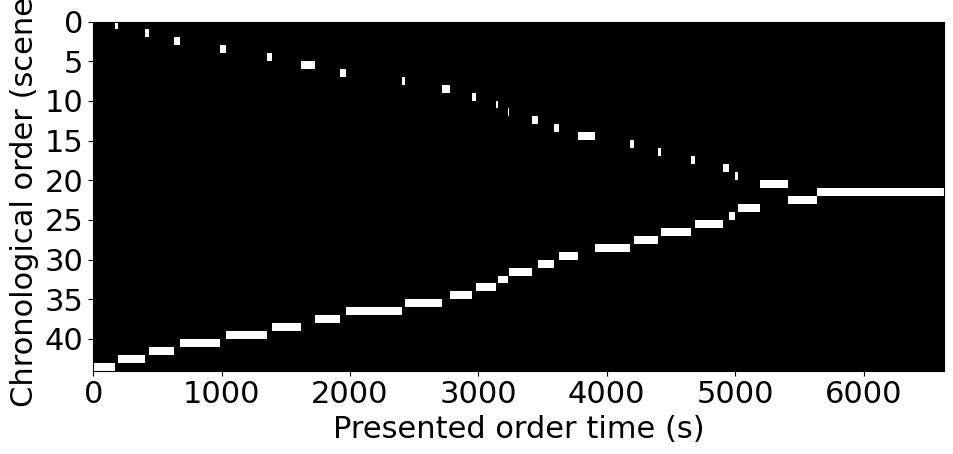

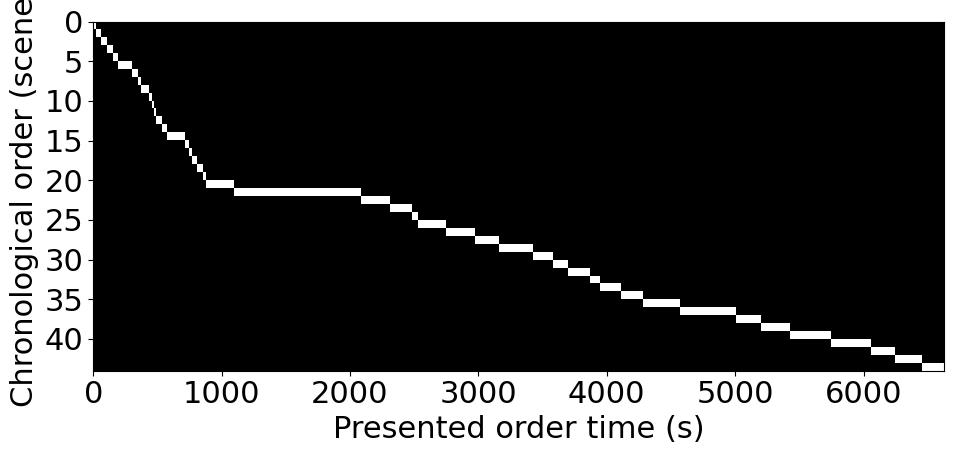

In [10]:
#plot event structure in original movie
story_narr_mat=np.zeros((np.max(df.StoryOrderSceneNum[:-1].astype(int)),tsecs))
story_narr_mat_re=story_narr_mat+0
for i in range(len(df)-1):
    ssec=int(df.Secs[i])
    lsec=int(df.Secs[i+1])
    evn=df.StoryOrderSceneNum[i].astype(int)
    story_narr_mat[evn-1,ssec:lsec]=1

ssec=0
for i in range(story_narr_mat.shape[0]):
    lsec=int(np.sum(story_narr_mat[i,:])+ssec)
    story_narr_mat_re[i,ssec:lsec]=1
    ssec=lsec+0

implot_story(story_narr_mat,"eventstructure")
implot_story(story_narr_mat_re,"eventstructure_re")

# Load info about similarity (visual + full descriptions and dialogues)


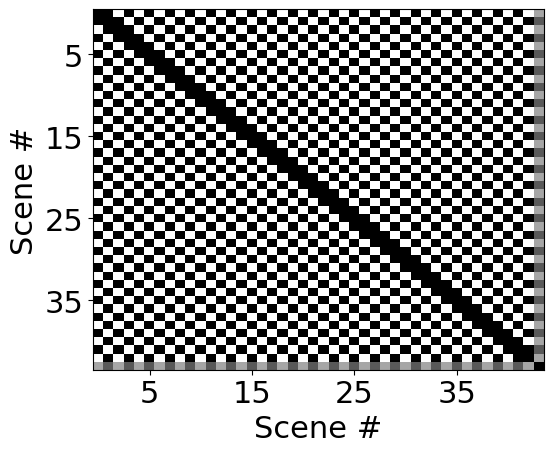

In [11]:
cols2skip = [0,1] #columns to skip when importing data
cols = [i for i in range(n_ev+2) if i not in cols2skip]
df_vs = pd.read_excel('MementoStoryBoard.xlsx','visSim',skiprows=1,usecols=cols)
vsdat_a=np.zeros((n_ev,n_ev)) #matrix for holding visual similarity data
dat=df_vs.values              #extract relevant numbers from dataframe
qq=np.where(np.isnan(dat))    #find nan values
dat[qq]=0                     #assign nan values to zero instead
vsdat_a=dat+0                 #log all data together

f, ax = plt.subplots(1,1, figsize = (fs1*2//3,fs2/2))
im=ax.imshow(vsdat_a,interpolation='none',cmap=cm,aspect='auto')
ax.set_xlabel('Scene #')
ax.set_ylabel('Scene #')
ax.set_xticks(lin_ev[4::10])
ax.set_yticks(lin_ev[4::10])
#ax.set_title('Visual similarity matrix') #kill for printed fig
f.tight_layout()
fn="figs/vissim_2d_graph_red.pdf"
plt.savefig(fn, transparent=True)

rows of dialogue: 1207
Who is this?
tf.Tensor([-0.03883157  0.00835378  0.02391592  0.01936942 -0.08174085], shape=(5,), dtype=float32)
rows of full screenplay: 2543


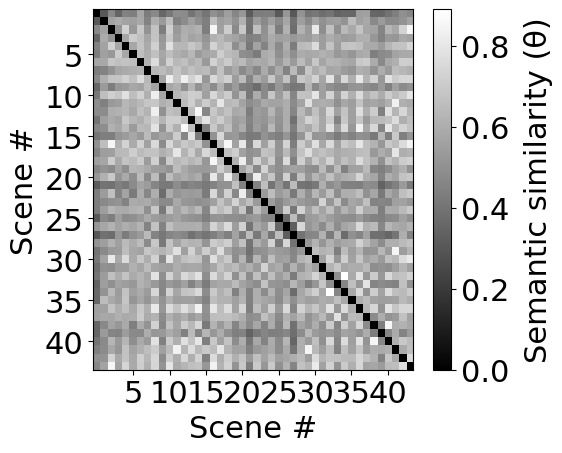

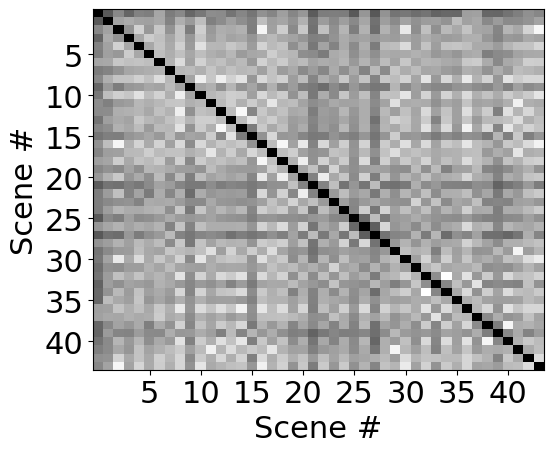

In [12]:
## add info about script
df_ds = pd.read_excel('MementoStoryBoard.xlsx','dialogueScript') #dialogue
print('rows of dialogue:',len(df_ds))
text = ["" for x in range(n_ev)]
for i in range(len(df_ds)):
    sceneN=df_ds['BroadSceneNum'][i]-1
    txt=df_ds['Text'][i]
    if txt[-1] == " ":
        txt=txt[:-1]+" "
    text[sceneN]=text[sceneN]+txt #omit final space because it's just a space bar
embeddings_ds = embed(text)

#print sample sentence + embeddings
for i in range(23,24):
    print(text[i])
    print(embeddings_ds[i,:5]) #just first 5 of 512 embedding values

df_fs = pd.read_excel('MementoStoryBoard.xlsx','fullScript') #screenplay
print('rows of full screenplay:',len(df_fs))
text = ["" for x in range(n_ev)]
for i in range(len(df_fs)):
    sceneN=int(df_fs['BroadSceneNum'][i]-1)
    txt=df_fs['Text'][i]
    if txt[-1] == " ":
        txt=txt[:-1]+" "
    text[sceneN]=text[sceneN]+txt
embeddings_fs = embed(text)

#plot for Fig 3A
sem_2d_fs=plot_embed2d(embeddings_fs,'fullScript') #scene-by-scene matrix

#Load causality & importance ratings

In [14]:
raters=['r1','r2','r3','r4','r5','r6','r7'] #list of raters
nR=len(raters) # #raters
plot_ind=0     #plot individual raters?
cols2skip = [0,1] #columns to skip when importing data
cols = [i for i in range(n_ev+2) if i not in cols2skip]
icols = [i for i in range(3) if i not in cols2skip]
cdat_a=np.zeros((n_ev,n_ev,nR)) #matrix for holding causality data
idat_a=np.zeros((n_ev,nR))      #matrix for holding importance data
for i in range(nR): #loop over rater
    fn='ratings/'+raters[i]+'.xlsx' #define filename
    print(fn)
    dfr=pd.read_excel(fn,'CausalityRatings',skiprows=1,usecols=cols) #load data
    dat=dfr.values             #extract relevant numbers from dataframe
    qq=np.where(np.isnan(dat)) #find nan values
    dat[qq]=0                  #assign nan values to zero instead
    cdat_a[:,:,i]=dat          #log all data together
    dfi=pd.read_excel(fn,'ImportanceRatings',skiprows=0,usecols=icols) #load data
    idat=dfi.values #extract relevant numbers from dataframe
    idat_a[:,i]=idat[:,0]
    if plot_ind:
        f, ax = plt.subplots(1,1, figsize = (fs1/4,fs2/4))
        im=ax.imshow(dat,interpolation='none',cmap=cm,aspect='auto')
        ax.set_xlabel('Scene #')
        ax.set_ylabel('Scene #')

ratings/r1.xlsx
ratings/r2.xlsx
ratings/r3.xlsx
ratings/r4.xlsx
ratings/r5.xlsx
ratings/r6.xlsx
ratings/r7.xlsx


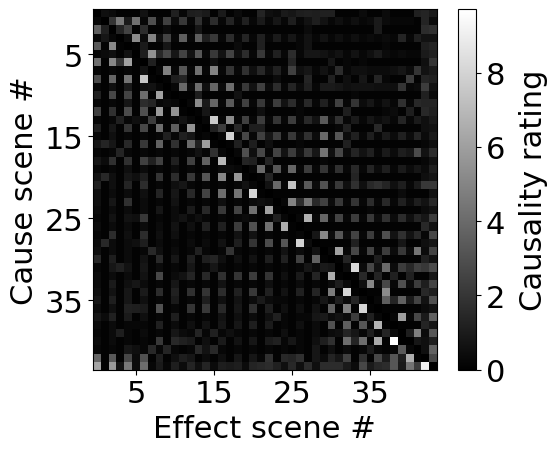

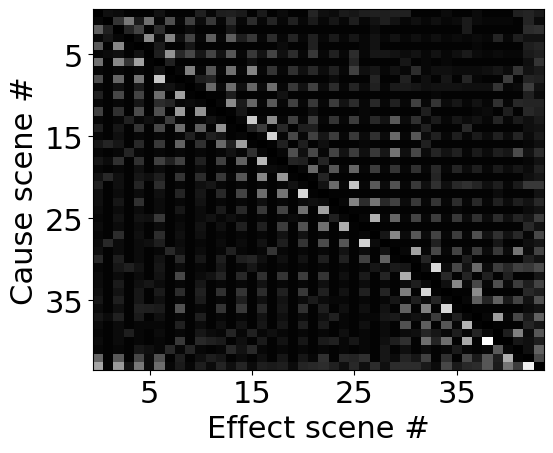

In [15]:
#plot 2-D (scene x scene) matrix of mean causality ratings
cdat_a_m=np.mean(cdat_a,2)
for i in range(n_ev):
  cdat_a_m[i,i]=0#math.nan #zero out diagonal
f, ax = plt.subplots(1,1, figsize = (fs1*2//3,fs2/2))
im=ax.imshow(cdat_a_m,interpolation='none',cmap=cm,aspect='auto')
ax.set_xlabel('Effect scene #')
ax.set_ylabel('Cause scene #')
ax.set_xticks(lin_ev[4::10])
ax.set_yticks(lin_ev[4::10])
cbar=f.colorbar(im)
cbar.solids.set_edgecolor("face")
cbar.ax.get_yaxis().labelpad = 10 #25 when rotation=270
cbar.set_label('Causality rating', rotation=90)
f.tight_layout()
fn="figs/causality_2d_graph.pdf"
plt.savefig(fn, transparent=True)

#reduced plot for Fig 3A
f, ax = plt.subplots(1,1, figsize = (fs1*2//3,fs2/2))
im=ax.imshow(cdat_a_m,interpolation='none',cmap=cm,aspect='auto')
ax.set_ylabel('Cause scene #')
ax.set_xlabel('Effect scene #')
ax.set_xticks(lin_ev[4::10])
ax.set_yticks(lin_ev[4::10])
f.tight_layout()
fn="figs/causality_2d_graph_red.pdf"
plt.savefig(fn, transparent=True)

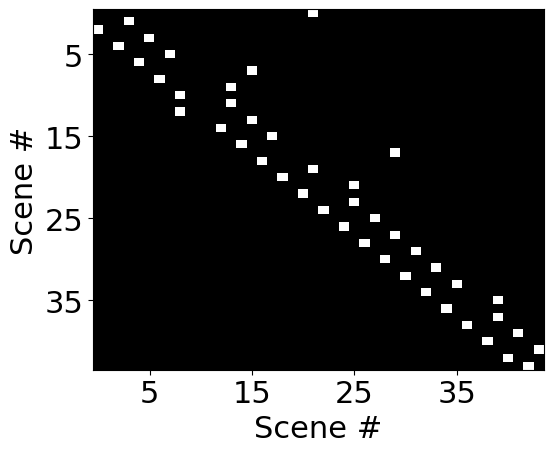

In [16]:
#find top causal match - Fig 3A
tcdat_a_m=np.zeros((n_ev,n_ev))
for i in range(n_ev):
  qq=np.where(cdat_a_m[i,:]==np.max(cdat_a_m[i,:]))[0]
  tcdat_a_m[i,qq[0]]=1

f, ax = plt.subplots(1,1, figsize = (fs1*2//3,fs2/2))
im=ax.imshow(tcdat_a_m,interpolation='none',cmap=cm,aspect='auto')
ax.set_ylabel('Scene #')
ax.set_xlabel('Scene #')
ax.set_xticks(lin_ev[4::10])
ax.set_yticks(lin_ev[4::10])
f.tight_layout()
fn="figs/causality_top_2d_graph_red.pdf"
plt.savefig(fn, transparent=True)

In [17]:
#find specific values for given transitions
st1,st2,st3=10,6,4
curr_2d=sem_2d_fs+0
v12=curr_2d[st1,st2]/np.nansum(curr_2d[st1,:])
v23=curr_2d[st2,st3]/np.nansum(curr_2d[st2,:])
print('sem value from state 1 to 2: %s and 2 to 3: %s' %(v12,v23))
curr_2d=cdat_a_m+0
v12=curr_2d[st1,st2]/np.nansum(curr_2d[st1,:])
v23=curr_2d[st2,st3]/np.nansum(curr_2d[st2,:])
print('caus value from state 1 to 2: %s and 2 to 3: %s' %(v12,v23))

sem value from state 1 to 2: 0.02620691987530914 and 2 to 3: 0.025188996519313108
caus value from state 1 to 2: 0.16292134831460678 and 2 to 3: 0.2097560975609756


In [18]:
#nan out self-referential diagonal
for i in range(cdat_a.shape[0]):
  for j in range(cdat_a.shape[0]):
    if i==j:
      cdat_a[i,j,:]=np.nan

In [19]:
#examine across-rater reliability
xrater_r=np.zeros((cdat_a.shape[2]))
for i in range(cdat_a.shape[2]): #loop over raters
  ids=[]
  for j in range(cdat_a.shape[2]):
    if i!=j:
      ids=np.hstack([ids,int(j)])
  ids=ids.astype(int)
  avg_group=np.mean(cdat_a[:,:,ids],2).flatten()
  heldout=cdat_a[:,:,i].flatten()

  qq=ma.corrcoef(ma.masked_invalid(avg_group), ma.masked_invalid(heldout))
  xrater_r[i]=qq[1,0]

print('All scores based on holdout method:',xrater_r)
print('Mean:',np.mean(xrater_r))
print('Median:',np.median(xrater_r))
# split half reliability
first_half=np.mean(cdat_a[:,:,:4],2).flatten()
second_half=np.mean(cdat_a[:,:,4:],2).flatten()
qq=ma.corrcoef(ma.masked_invalid(first_half), ma.masked_invalid(second_half))
print('Split-half reliability:',qq[1,0])

All scores based on holdout method: [0.09786532 0.69973072 0.45704769 0.41275205 0.55328411 0.63203944
 0.52044044]
Mean: 0.48187996767832175
Median: 0.5204404384787022
Split-half reliability: 0.6418442593349513


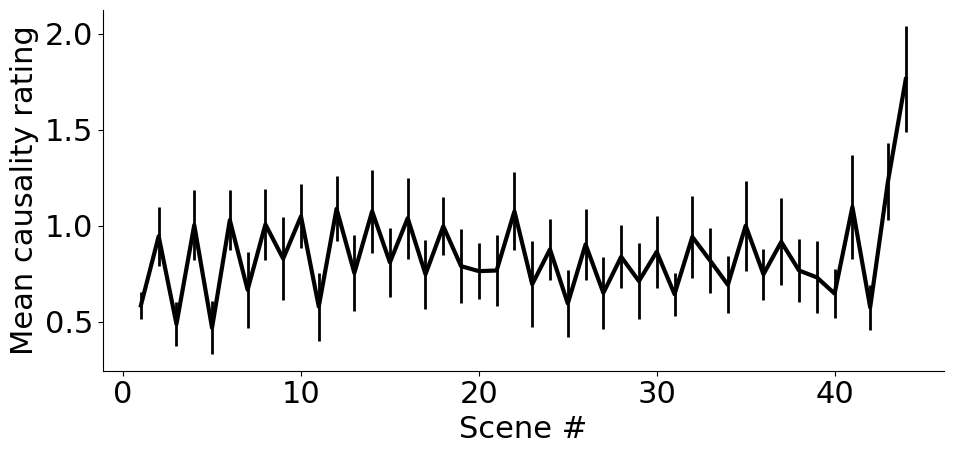

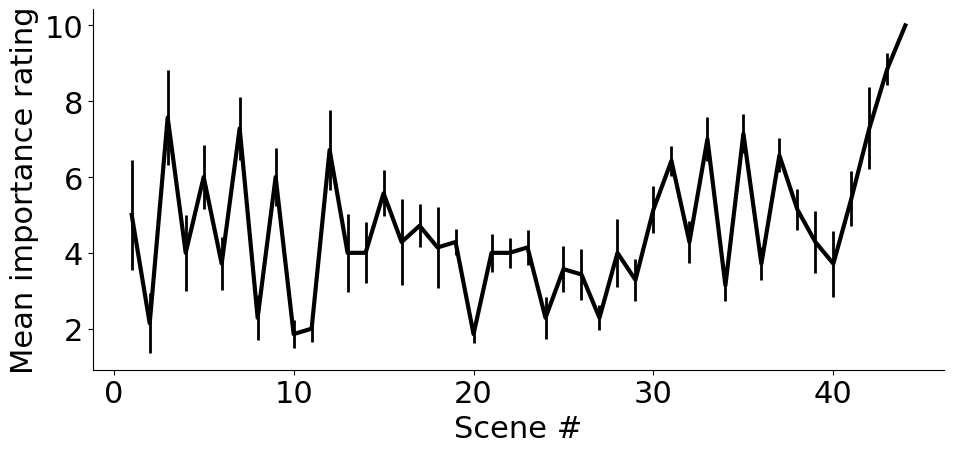

In [20]:
#plot some attributes by scene
y_caus,err_caus=plotscenev(cdat_a_m,'Mean causality rating',figf+"scene_causality.pdf",2)
y_imp,err_imp=plotscenev(idat_a,'Mean importance rating',figf+"scene_importance.pdf",2)

caus thresh: 0.0
top caus thresh: 0.0
rev caus thresh: 0.0
semantic thresh: 0.0
vis thresh: 0.0
char thresh: 0.004651162790697674
place thresh: 0.0


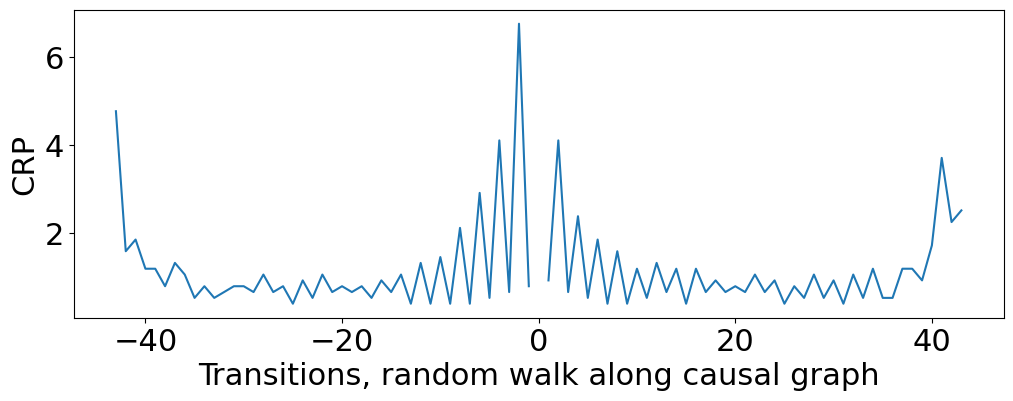

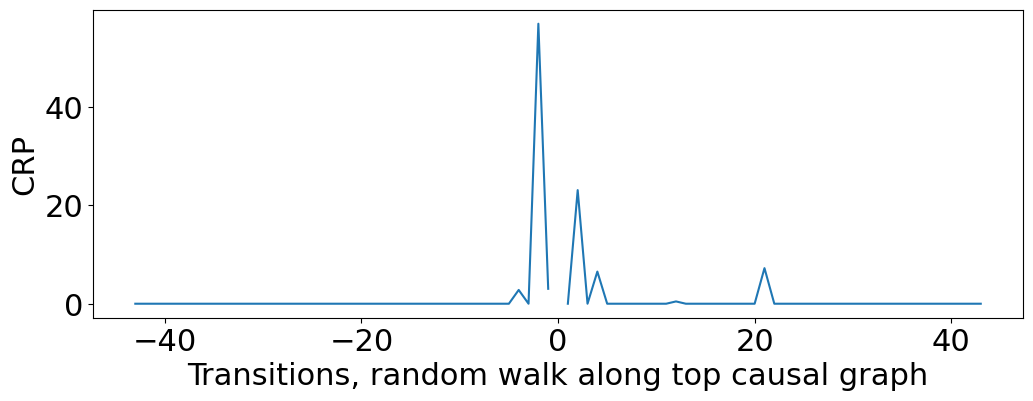

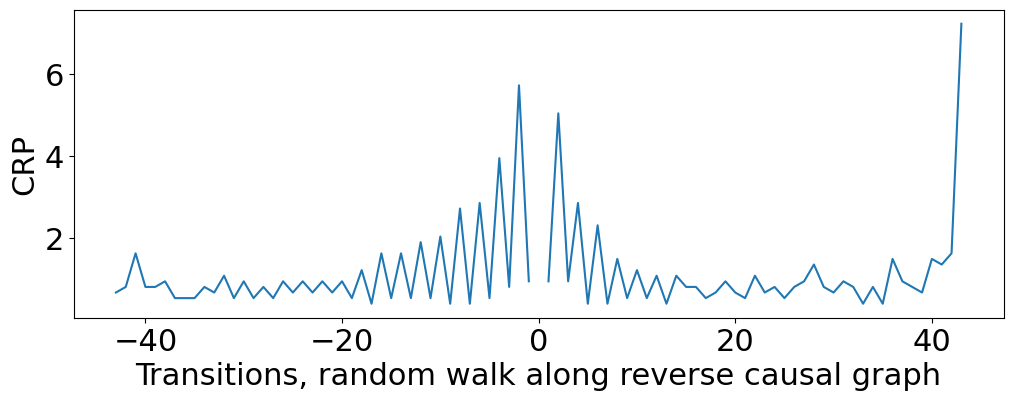

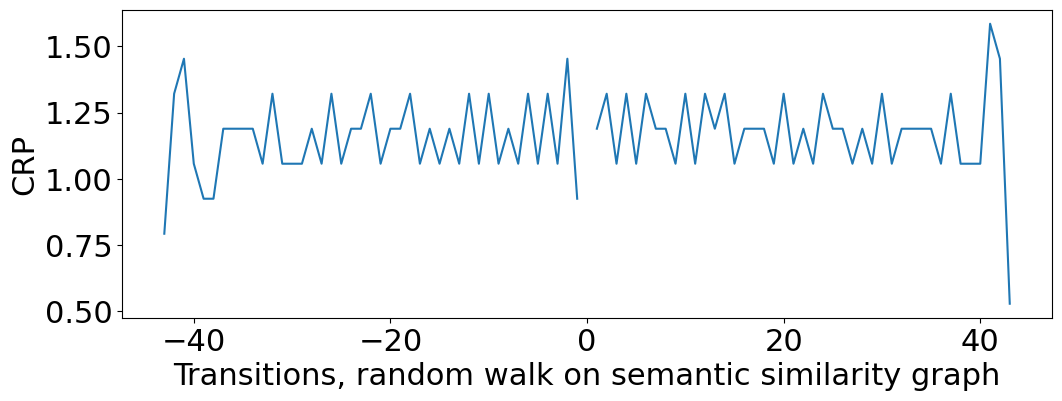

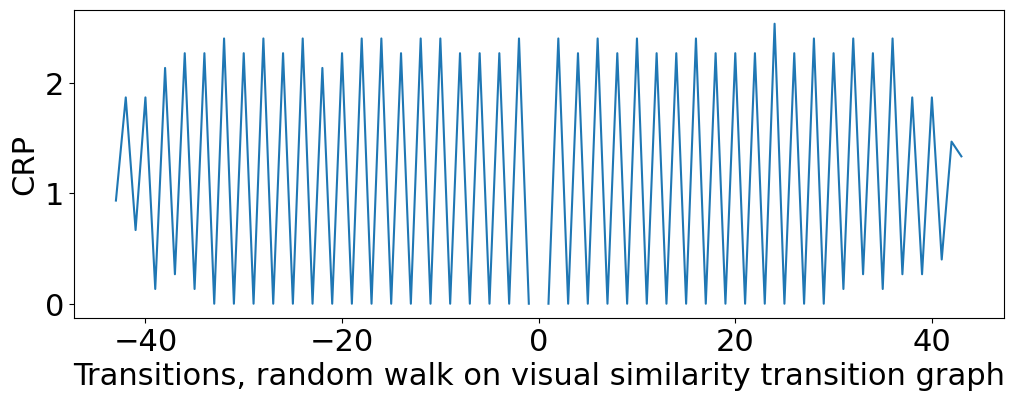

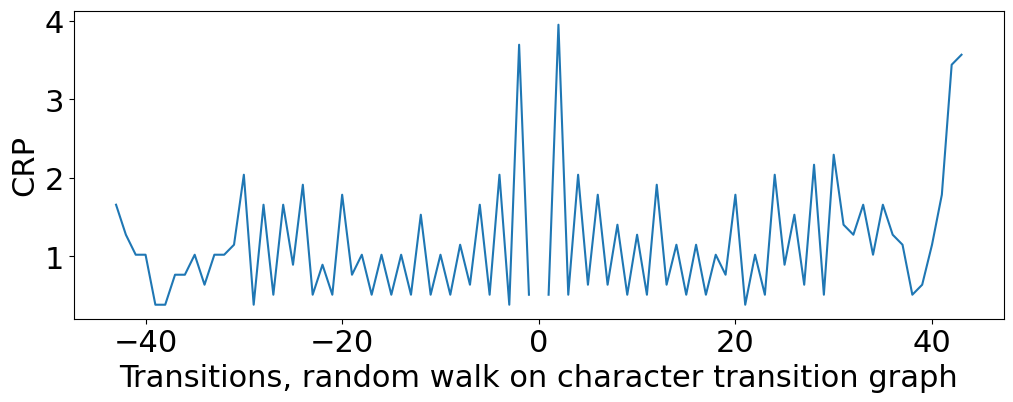

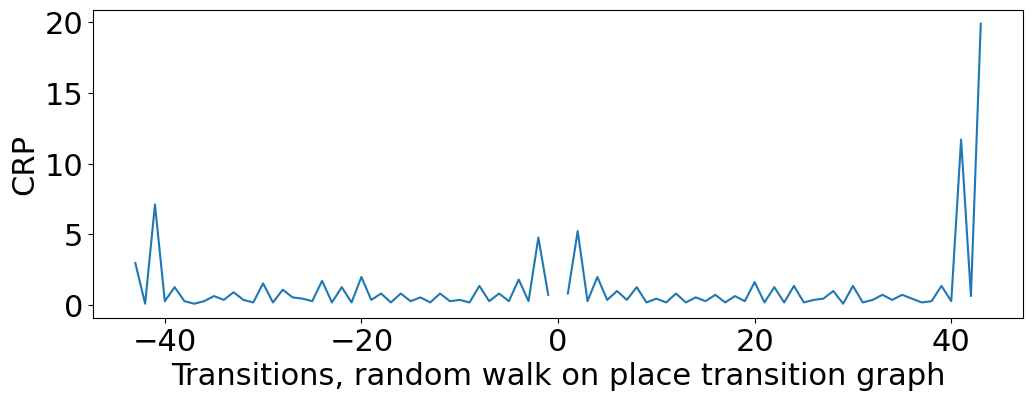

In [25]:
#find random walk transition structures
perc_thr=0
crp_lab='CRP'

#causal
'''currg=cdat_a_m+0
blah=np.where(np.isnan(currg)==0)
blah2=currg[blah]
currthr=np.percentile(blah2,perc_thr) #minimum causality rating to keep in graph
print('caus thresh:',currthr)'''
asdiff_caus,as_caus_poss_m=randwalk(cdat_a_m,'caus',0)
ideal_caus_no,fir,las,maxj,js=asdiff_plot(asdiff_caus,as_caus_poss_m,'random walk along causal graph')

#top causal
asdiff_tcaus,as_tcaus_poss_m=randwalk(tcdat_a_m,'top caus',0)
ideal_tcaus_no,fir,las,maxj,js=asdiff_plot(asdiff_tcaus,as_tcaus_poss_m,'random walk along top causal graph')

#reverse causal
asdiff_caus_rev,as_caus_rev_poss_m=randwalk(cdat_a_m.T,'rev caus',0)
ideal_caus_rev_no,fir,las,maxj,js=asdiff_plot(asdiff_caus_rev,as_caus_rev_poss_m,'random walk along reverse causal graph')

#semantic
asdiff_fs,as_fs_poss_m=randwalk(sem_2d_fs,'semantic',0)
ideal_sem_no,fir,las,maxj,js=asdiff_plot(asdiff_fs,as_fs_poss_m,'random walk on semantic similarity graph')

#visual
asdiff_vis,as_vis_poss_m=randwalk(vsdat_a,'vis',0)
ideal_vis_no,fir,las,maxj,js=asdiff_plot(asdiff_vis,as_vis_poss_m,'random walk on visual similarity transition graph')

#character
asdiff_char,as_char_poss_m=randwalk(char_trans,'char',0)
ideal_char_no,fir,las,maxj,js=asdiff_plot(asdiff_char,as_char_poss_m,'random walk on character transition graph')

#place
asdiff_place,as_place_poss_m=randwalk(place_trans,'place',0)
ideal_place_no,fir,las,maxj,js=asdiff_plot(asdiff_place,as_place_poss_m,'random walk on place transition graph')

In [26]:
#create semantic+causal networks
perc_thr=80
blah2=cdat_a_m[np.where(np.isnan(cdat_a_m)==0)]
causthr=np.percentile(blah2,perc_thr) #2 #minimum causality rating to keep'
print('caus thresh:',causthr)
blah2=tcdat_a_m[np.where(np.isnan(tcdat_a_m)==0)]
causbmthr=np.percentile(blah2,perc_thr) #2 #minimum causality rating to keep'
print('top caus thresh:',causbmthr)
blah2=sem_2d_fs[np.where(np.isnan(sem_2d_fs)==0)]
semthr=np.percentile(blah2,perc_thr)
print('semantic thresh:',semthr)

G_caus,ew_caus,cmap_caus=create_network(cdat_a_m,causthr)
G_tcaus,ew_tcaus,cmap_tcaus=create_network(tcdat_a_m,causbmthr)
G_caus_rev,ew_caus_rev,cmap_caus_rev=create_network(cdat_a_m.T,causthr)
G_fs,ew_fs,cmap_fs=create_network(sem_2d_fs,semthr)

caus thresh: 1.2857142857142858
top caus thresh: 0.0
semantic thresh: 0.6700908440248026
367
44
367
386


In [27]:
#assign network attributes to variables

#CAUSALITY
b_cent=nx.betweenness_centrality(G_caus, weight= 'weight')
G2_caus=nx.DiGraph(G_caus) #must convert to digraph for eigenvector centrality
ev_cent=nx.eigenvector_centrality(G2_caus,weight='weights')
y_ev_cent=[float(x) for x in list(ev_cent.values())]
#### instead of in degree and out degree, let's use sum of ROW for out degree
#### and sum of column for in degree!!
y_inw=np.nanmean(cdat_a_m,0)
y_outw=np.nanmean(cdat_a_m,1)
y_degw=(y_inw+y_outw)

#don't use variables in this section - they don't allow factoring in weights
deg_cent=nx.degree_centrality(G2_caus)
in_cent=nx.in_degree_centrality(G2_caus)
out_cent=nx.out_degree_centrality(G2_caus)
y_b_cent=[float(x) for x in list(b_cent.values())]
y_deg_cent=[float(x) for x in list(deg_cent.values())]
y_in_cent=[float(x) for x in list(in_cent.values())]
y_out_cent=[float(x) for x in list(out_cent.values())]

node_sz_meth=2 #1=use betweenness centrality,2=importance
if node_sz_meth==1:
    outc=y_b_cent
elif node_sz_meth==2:
    outc=y_imp

node_szs=np.zeros((n_ev))
for i in range(n_ev):
    node_szs[i]=np.divide(outc[i],np.sum(outc))
node_szs=np.divide(np.around(np.multiply(node_szs,100)),100) #keep 2 decimals
print('% importance of each scene, normalized:',node_szs)

#SEMANTIC GRAPH
b_cent_sem=nx.betweenness_centrality(G_fs, weight= 'weight')
G2_fs=nx.DiGraph(G_fs) #must convert to digraph for eigenvector centrality
ev_cent_sem=nx.eigenvector_centrality(G2_fs,weight='weights')
y_ev_cent_sem=[float(x) for x in list(ev_cent_sem.values())]
#### instead of in degree and out degree, let's use sum of ROW for out degree
#### and sum of column for in degree!!
y_inw_sem=np.nanmean(sem_2d_fs,0)
y_outw_sem=np.nanmean(sem_2d_fs,1)
y_degw_sem=(y_inw_sem+y_outw_sem) #in/out should be identical tho

#don't use variables in this section - they don't allow factoring in weights
deg_cent_sem=nx.degree_centrality(G2_fs)
in_cent_sem=nx.in_degree_centrality(G2_fs)
out_cent_sem=nx.out_degree_centrality(G2_fs)
y_b_cent_sem=[float(x) for x in list(b_cent_sem.values())]
y_deg_cent_sem=[float(x) for x in list(deg_cent_sem.values())]
y_in_cent_sem=[float(x) for x in list(in_cent_sem.values())]
y_out_cent_sem=[float(x) for x in list(out_cent_sem.values())]

if node_sz_meth==1:
    outc=y_b_cent_sem
    node_szs_sem=np.zeros((n_ev))
    for i in range(n_ev):
      node_szs_sem[i]=np.divide(outc[i],np.sum(outc))
    node_szs_sem=np.divide(np.around(np.multiply(node_szs_sem,100)),100) #keep 2 decimals
    #print('% node size of each scene, normalized:',node_szs_sem)
elif node_sz_meth==2:
    node_szs_sem=node_szs+0 #just re-assign (importance doesn't change)

% importance of each scene, normalized: [0.02 0.01 0.04 0.02 0.03 0.02 0.04 0.01 0.03 0.01 0.01 0.03 0.02 0.02
 0.03 0.02 0.02 0.02 0.02 0.01 0.02 0.02 0.02 0.01 0.02 0.02 0.01 0.02
 0.02 0.02 0.03 0.02 0.03 0.02 0.03 0.02 0.03 0.02 0.02 0.02 0.03 0.04
 0.04 0.05]


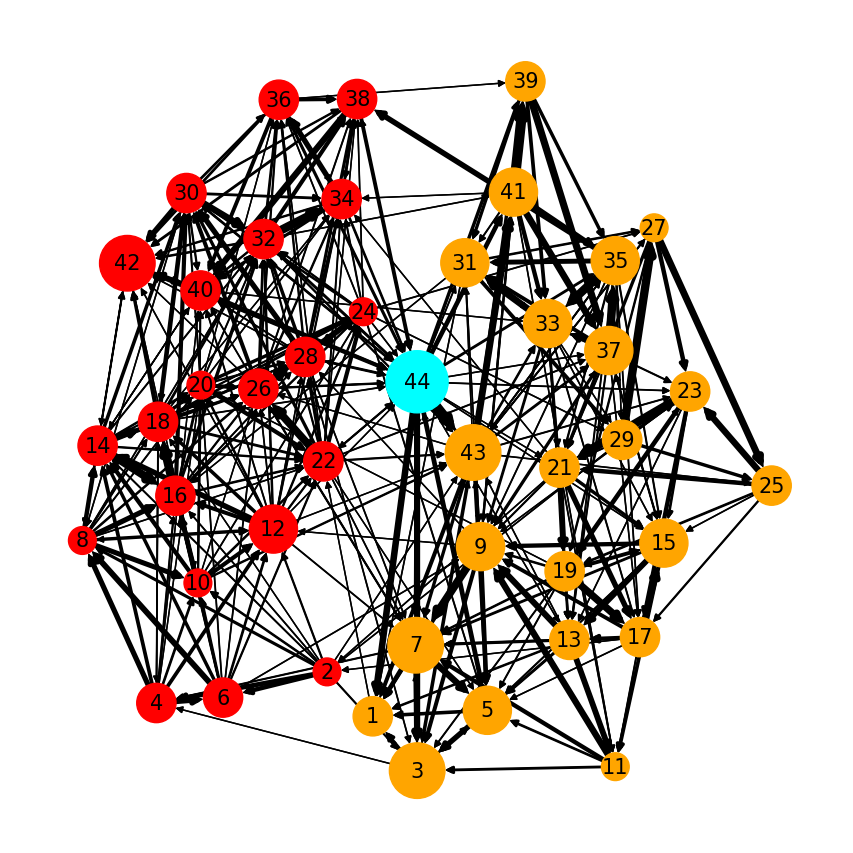

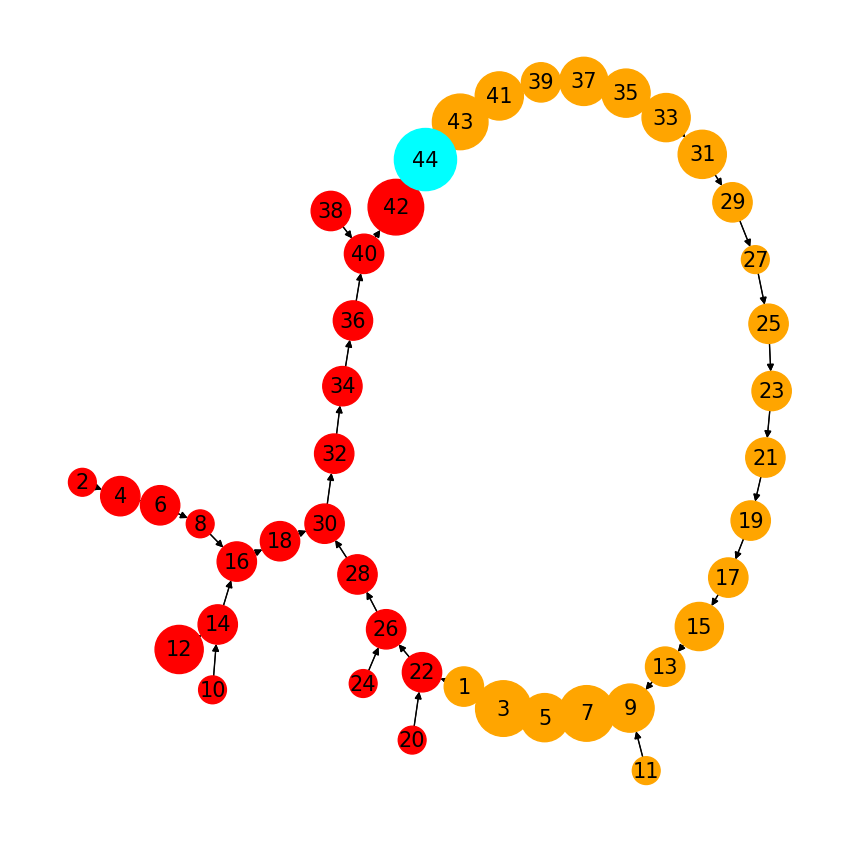

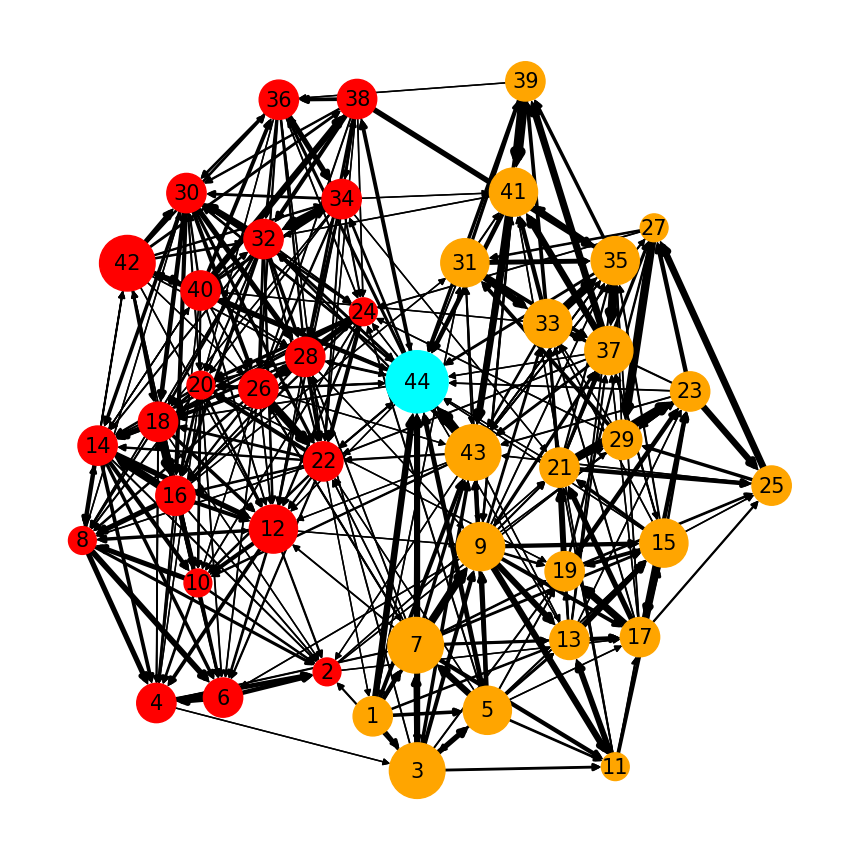

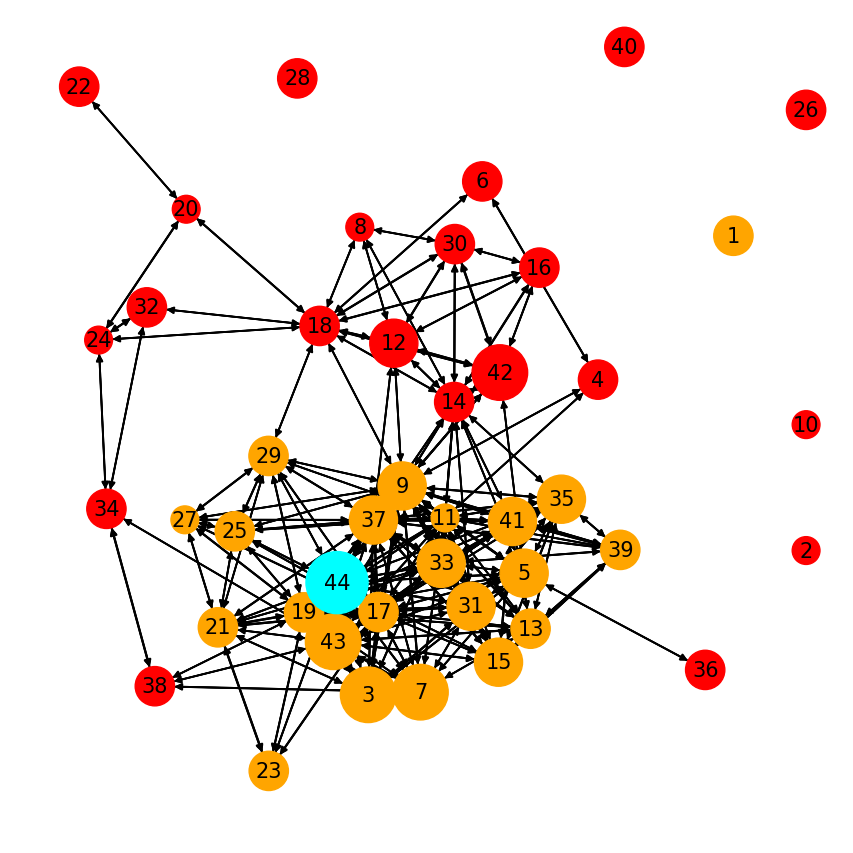

In [28]:
#visualize network graphs
no_mult,ed_mult=40000,0.75
network_plot(G_caus,ew_caus,node_szs,ed_mult,"causality_trans_graph")
network_plot(G_tcaus,ew_tcaus,node_szs,ed_mult,"top_causality_trans_graph")
network_plot(G_caus_rev,ew_caus_rev,node_szs,ed_mult,"rev_causality_trans_graph")
ed_mult=2
network_plot(G_fs,ew_fs,node_szs_sem,ed_mult,"semantic_scenedescr_trans_graph")

([], [])

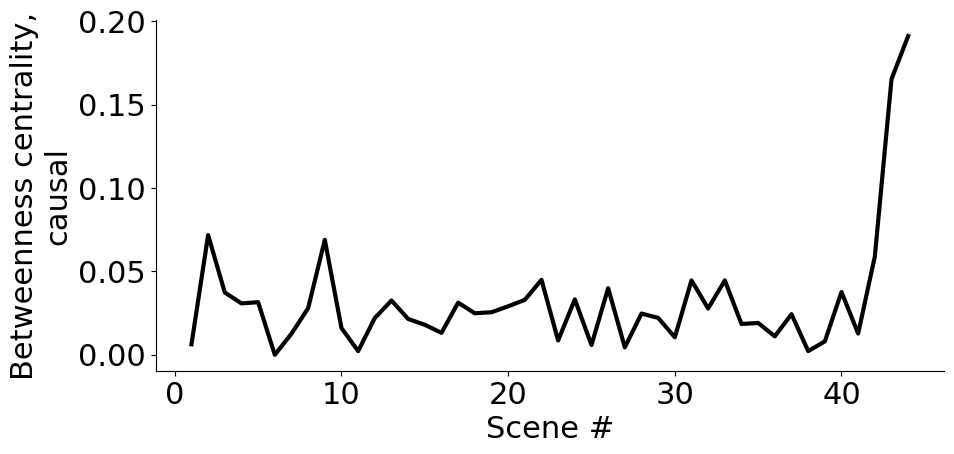

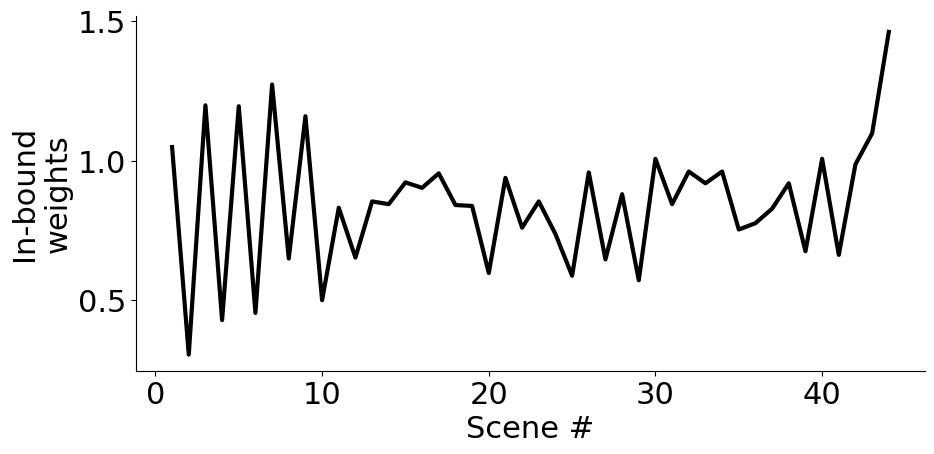

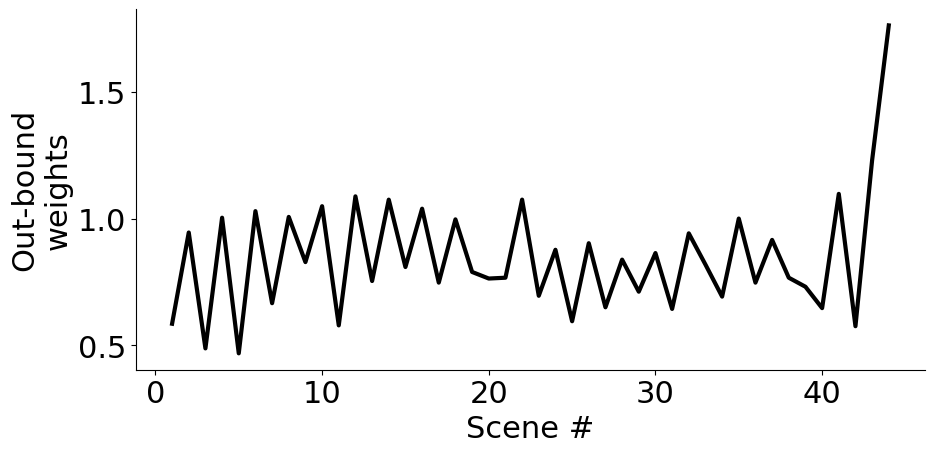

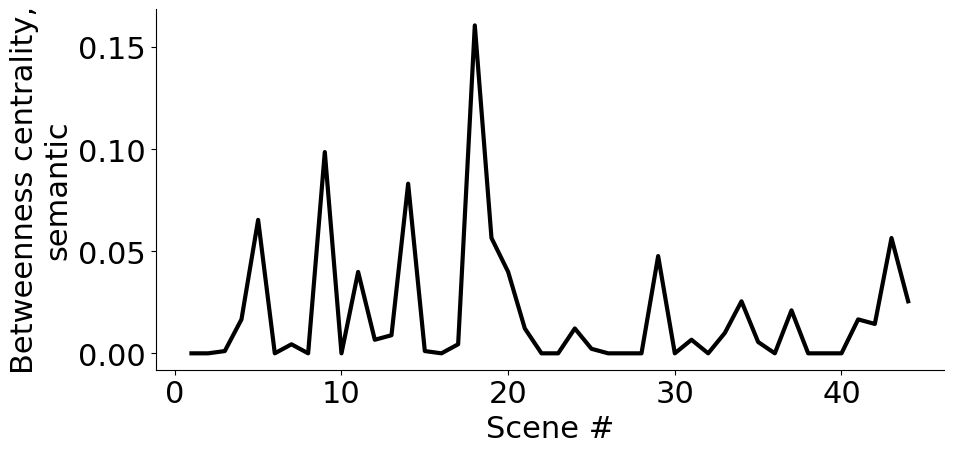

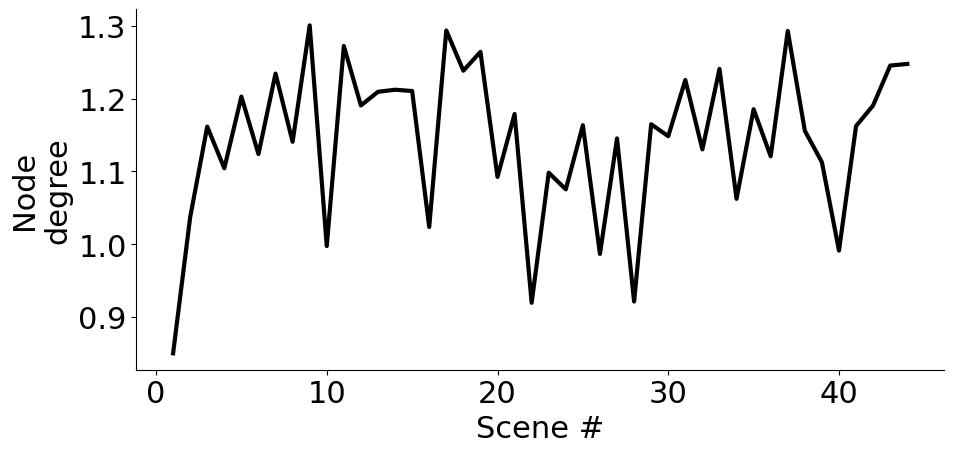

In [29]:
#plot betweenness centrality
yl0='''Betweenness centrality,
causal'''
plotscenev(y_b_cent,yl0,figf + 'b_cent_caus_by_scene.pdf',1)
yl0='''In-bound
weights'''
plotscenev(y_inw,yl0,figf + 'inw_by_scene.pdf',1)
yl0='''Out-bound
weights'''
plotscenev(y_outw,yl0,figf + 'outw_by_scene.pdf',1)

yl0='''Betweenness centrality,
semantic'''
plotscenev(y_b_cent_sem,yl0,figf + 'b_cent_sem_by_scene.pdf',1)
yl0='''Node
degree'''
plotscenev(y_degw_sem,yl0,figf + 'deg_sem_by_scene.pdf',1)

# Read in participant data

In [30]:
#group1 - original movie, free recall
#1,2,9,17,21;29,35,40,41,47;
#48,49,52,53,54;60,67,70,75,80;
#81,82,90,93,94;95,103,148,152,205;206 #all1
#MUST THROW OUT FROM TRANSITION ANALYSIS: 41 (no specific scenes), 94 - only 1 scene recalled

#group2 - original movie, presented order
#19,20,23,24,25;32,33,42,43,44;
#45,46,50,51,62;63,64,65,66,71;
#72,73,74,78,84;85,86,89,98,100;122,151,153 #all2

#group3 - original movie, chronological order
#101,102,105,109,111;112,113,114,115,117;
#118,119,120,121,124;126,127,128,129,130;
#132,133,134,137,138;139,140,141,146,147 #all3
#not below yet:118,129,141,(check on 102)
#MUST THROW OUT FROM TRANSITION ANALYSIS: 102 - only 1 scene recalled

#group4 - re-stitched, free recall
#154,156,157,158,160;161,162,163,164,167;
#169,171,172,173,174;175,177,179,180,181;
#181,182,184,185,(186);188,190,191,192,194;
#195,196,198,205,206;
#THROW OUT: 189 (no specific scenes)

subs=['1','2','9',
      '12','17','18','19','20',
      '21','23','24','25','29',
      '32','33','35','40',
      '42','43','44','45','46','48','50', #'41',- no specific scenes recalled
      '51','52','53','54','60',
      '62','63','64','65','66','67','70',
      '71','72','73','74','75','80',
      '81','84','85','86','89','90',
      '93','95','98','100',
      '101','103','105','106','109', #'102',
      '111','112','113','114','115','117','118','119','120',
      '121','124','126','127','128','129','130',
      '132','133','134','137','138','139','140',
      '141','146','147','148',
      '151','152','153','154','156','157','158','160', #end of 3rd condition after 153
      '161','162','163','164','167','168','169',
      '171','172','173','174','175','177','179','180',
      '181','182','184','185','186','188','190', #189,
      '191','192','194','195','196','198','205','206']
conds=np.zeros((len(subs)))
nSubs=len(subs)
xs_jumps,xs_jumps_so=np.zeros((len(subs),len(js)-1)),np.zeros((len(subs),len(js)-1))
#for Exp 4, where narr + chrono order aligned - blank for subs except Exp 4
xs_jumps_noco=np.zeros((len(subs),len(js)-1))
memo=np.zeros((nSubs,int(las))) #memorability
subs_a = pd.read_excel('Subjects.xlsx','subs') #MementoSubjectScoreSheets/
s_ind=subs_a['id'].values
c_ind=subs_a['Condition'].values
print(memo.shape)
max_subscene_jump=20
sub_xlab=np.arange(-max_subscene_jump,max_subscene_jump+1)
xsub_prop_subscene=np.zeros((nSubs,max_subscene_jump*2+1))
states_a=[None]*nSubs
broad_diff_poss=np.zeros((nSubs,(n_ev-1)*2+1))
broad_diff_poss_so=broad_diff_poss+0
sub_logs=[None]*nSubs
for i in range(nSubs): #loop over all of the participants
    sheetname='S'+str(subs[i])
    print(sheetname)
    q=int(subs[i])
    qq=np.where(s_ind==q)[0]
    conds[i]=c_ind[qq].squeeze()
    dfs = pd.read_excel('Subjects.xlsx',sheetname) #MementoSubjectScoreSheets/
    dfs['StoryOrderSceneNum']=np.zeros((len(dfs)))
    prior_narr_order_scene=0 #set to 0 before any matches
    sub_diff_log=np.zeros((max_subscene_jump*2+1))
    sub_diff_poss=sub_diff_log+0
    sub_log=[]
    for j in range(len(dfs)): #loop over all of the rows from the participants' recall
        narr_order_scene=dfs['BroadSceneNum'][j]
        narr_order_subscene=dfs['SubsceneNum'][j]
        if narr_order_scene>0: #corresponds to a specific scene
            qq=np.where(df['BroadSceneNum']==narr_order_scene) #find rows w/ broad scene
            curr_story_order_scene=int(df['StoryOrderSceneNum'][qq[0][0]]) #log in story order
            dfs['StoryOrderSceneNum'][j]=curr_story_order_scene
            memo[i,int(narr_order_scene)-1]=1 #record for memorability analyses

            #for subscenes, logging only transitions
            subscene_max=len(qq[0]) #max # of subscenes
            if n_sub[int(narr_order_scene-1)]>1: #only log when there's >1 subscene
              if len(sub_log)==0:
                sub_log=[narr_order_scene,narr_order_subscene]
              else:
                if np.logical_or(narr_order_scene!=prior_narr_order_scene,
                                  narr_order_subscene!=prior_subscene):
                  sub_log=np.vstack([sub_log,[narr_order_scene,narr_order_subscene]])
            if narr_order_scene==prior_narr_order_scene: #if prior and current match
              if narr_order_subscene!=prior_subscene: #if not same subscene as prior
                sub_diff=int(max_subscene_jump+(narr_order_subscene-prior_subscene))
                sub_diff_log[sub_diff]=sub_diff_log[sub_diff]+1 #log actual jump
                #log possible jumps
                sub_diff_poss[int(max_subscene_jump+1-prior_subscene):int(max_subscene_jump+1-prior_subscene+subscene_max)]=sub_diff_poss[int(max_subscene_jump+1-prior_subscene):int(max_subscene_jump+1-prior_subscene+subscene_max)]+1
            prior_narr_order_scene=narr_order_scene+0
            prior_subscene=narr_order_subscene+0
    sub_logs[i]=sub_log
    nanv=np.where(sub_diff_poss==0)[0]
    nnanv=np.where(sub_diff_poss>0)[0]
    xsub_prop_subscene[i,nanv]=math.nan
    xsub_prop_subscene[i,nnanv]=np.divide(sub_diff_log[nnanv],sub_diff_poss[nnanv]) #find proportion of actual vs. possible transitions
    qq=np.where(dfs.BroadSceneNum.isna()==0) #find broad scenes that have data
    allscenes=dfs['BroadSceneNum'][qq[0]] #recall order
    states_a[i]=allscenes
    diff=np.diff(allscenes) #find difference from each moment against the prior one

    #find story order scenes that have data
    qq=np.where(np.logical_and(dfs.StoryOrderSceneNum.isna()==0,dfs['StoryOrderSceneNum']>0))
    allscenes_so=dfs['StoryOrderSceneNum'][qq[0]]
    diff_so=np.diff(allscenes_so)

    #need to create histogram of transitions, loop through subjects, do more with narratives / order
    asv=allscenes.values
    qq=np.where(diff!=0) #where are there non-zero transitions
    nzdiff=diff[qq[0]]
    asv2=asv[qq[0]] #grab non-repeating scenes
    for j in range(len(asv2)):
      curr_scene=asv2[j]
      broad_diff_poss[i,int(n_ev-curr_scene):int(n_ev-curr_scene+n_ev)]=broad_diff_poss[i,int(n_ev-curr_scene):int(n_ev-curr_scene+n_ev)]+1

    qqq=np.histogram(nzdiff,js)
    xs_jumps[i,:]=qqq[0]
    xs_jumps[i,int(maxj)]=math.nan

    qq=np.where(diff_so!=0) #where are there non-zero transitions, story order
    nzdiff_so=diff_so[qq[0]]
    asv_noco=allscenes_so.values
    asv_noco2=asv[qq[0]] #grab non-repeating scenes
    for j in range(len(asv_noco2)):
      curr_scene=asv_noco2[j]
      broad_diff_poss_so[i,int(n_ev-curr_scene):int(n_ev-curr_scene+n_ev)]=broad_diff_poss_so[i,int(n_ev-curr_scene):int(n_ev-curr_scene+n_ev)]+1

    qqq=np.histogram(nzdiff_so,js)
    xs_jumps_so[i,:]=qqq[0]
    xs_jumps_so[i,int(maxj)]=math.nan
    if conds[i]==4: #make special xs_jumps version - only look @ Exp4
      xs_jumps_noco[i,:]=qqq[0]
      xs_jumps_noco[i,int(maxj)]=math.nan

(122, 44)
S1
S2
S9
S12
S17
S18
S19
S20
S21
S23
S24
S25
S29
S32
S33
S35
S40
S42
S43
S44
S45
S46
S48
S50
S51
S52
S53
S54
S60
S62
S63
S64
S65
S66
S67
S70
S71
S72
S73
S74
S75
S80
S81
S84
S85
S86
S89
S90
S93
S95
S98
S100
S101
S103
S105
S106
S109
S111
S112
S113
S114
S115
S117
S118
S119
S120
S121
S124
S126
S127
S128
S129
S130
S132
S133
S134
S137
S138
S139
S140
S141
S146
S147
S148
S151
S152
S153
S154
S156
S157
S158
S160
S161
S162
S163
S164
S167
S168
S169
S171
S172
S173
S174
S175
S177
S179
S180
S181
S182
S184
S185
S186
S188
S190
S191
S192
S194
S195
S196
S198
S205
S206


In [31]:
#subscenes per scene
sub_normv=np.zeros((max_subscene_jump+1))
for i in range(max_subscene_jump+1):
  sub_normv[i]=len(np.where(n_sub>=i+1)[0])
#set first to second b/c we only allow scenes w/ >1 subscene thru in prior step
sub_normv[0]=sub_normv[1]+0

In [32]:
#find most common subscene @ start
poss_subj=np.linspace(1,max_subscene_jump+2,max_subscene_jump+2)-0.5
distr_a=np.zeros((nSubs,max_subscene_jump+1))
for i in range(nSubs):
  curr_log=sub_logs[i]
  if len(curr_log)>2:
    qq=np.where(np.diff(curr_log[:,0])!=0)[0]
    new_log=curr_log[qq,:]
    distr=np.histogram(new_log[:,1],poss_subj)
    distr_a[i,:]=np.divide(distr[0],sub_normv)
  else:
    distr_a[i,:]=math.nan

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Frequency first recalled\nwithin scene, normed by #')

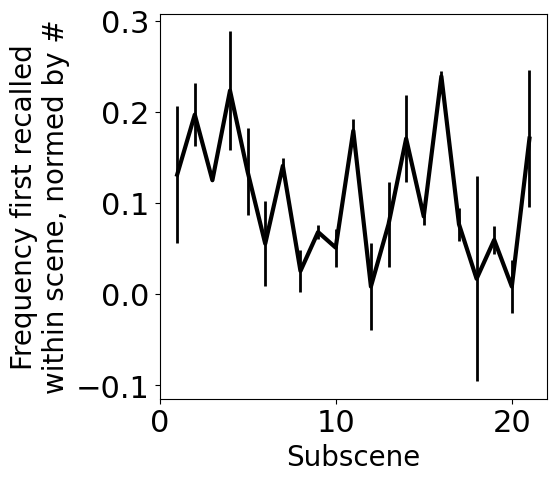

In [33]:
#plot
x,y=np.linspace(1,max_subscene_jump+1,max_subscene_jump+1),distr_a+0
y1=np.nanmean(y,0)
err_sub=np.zeros((max_subscene_jump+1))
for i in range(max_subscene_jump+1):
    y_adj=y[i,~np.isnan((y[i,:]))]
    err_sub[i]=np.std(y_adj)/np.sqrt(y_adj.shape[0])
f, ax = plt.subplots(1,1, figsize = (fs1/2,fs2/2))
plt.errorbar(x,y1,err_sub,color='k',linewidth=3,elinewidth=2)
ax.set_xlabel('Subscene',fontsize=20)
ax.set_ylabel('''Frequency first recalled
within scene, normed by #''',fontsize=20)

<ipython-input-34-5f4fcf7fde55>:2: RuntimeWarning: invalid value encountered in divide
  xs_jumps_cond=np.divide(xs_jumps,broad_diff_poss)
<ipython-input-34-5f4fcf7fde55>:3: RuntimeWarning: divide by zero encountered in divide
  xs_jumps_noco_cond=np.divide(xs_jumps_noco,broad_diff_poss_so)
<ipython-input-34-5f4fcf7fde55>:3: RuntimeWarning: invalid value encountered in divide
  xs_jumps_noco_cond=np.divide(xs_jumps_noco,broad_diff_poss_so)
<ipython-input-34-5f4fcf7fde55>:4: RuntimeWarning: divide by zero encountered in divide
  xs_jumps_so_cond=np.divide(xs_jumps_so,broad_diff_poss_so)
<ipython-input-34-5f4fcf7fde55>:4: RuntimeWarning: invalid value encountered in divide
  xs_jumps_so_cond=np.divide(xs_jumps_so,broad_diff_poss_so)
<ipython-input-34-5f4fcf7fde55>:18: RuntimeWarning: Mean of empty slice
  y1=np.nanmean(y,axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dty

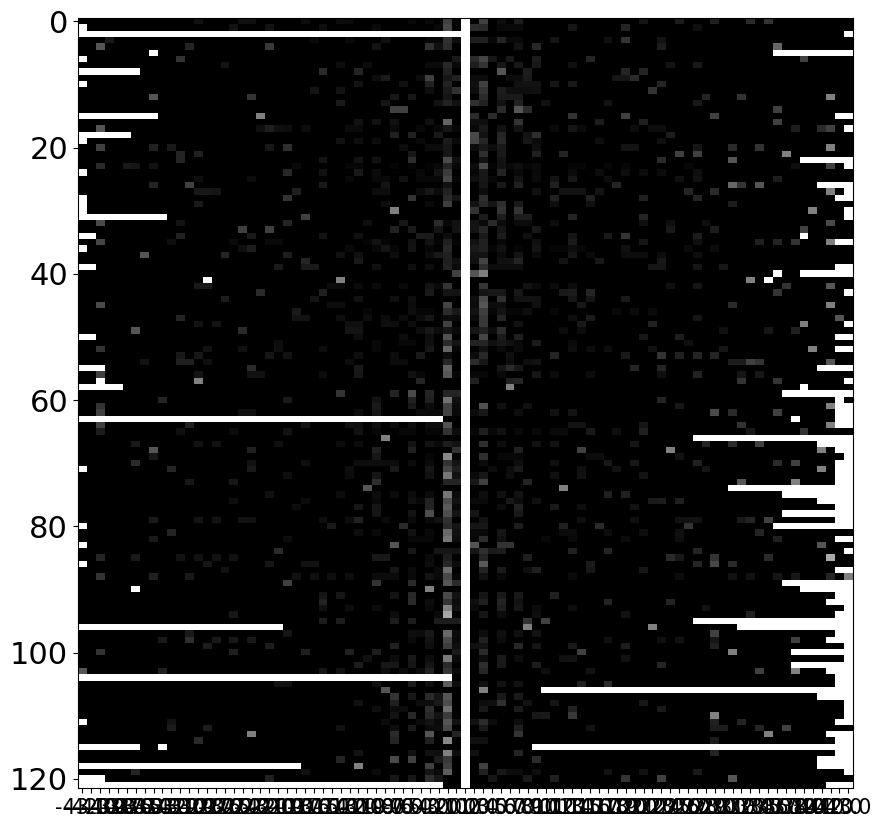

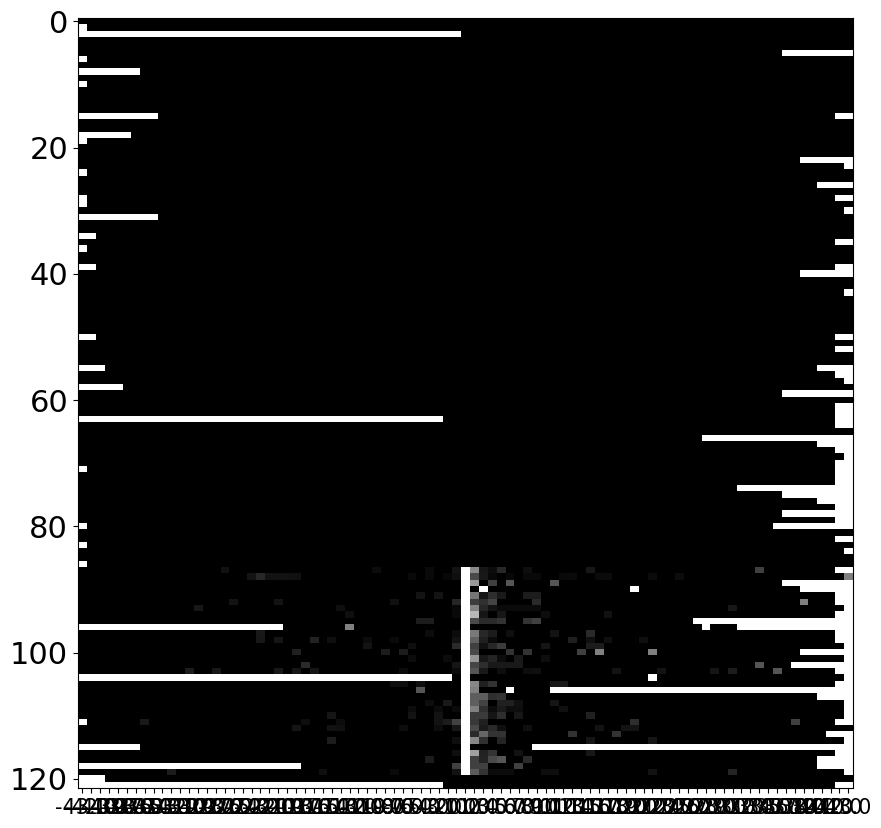

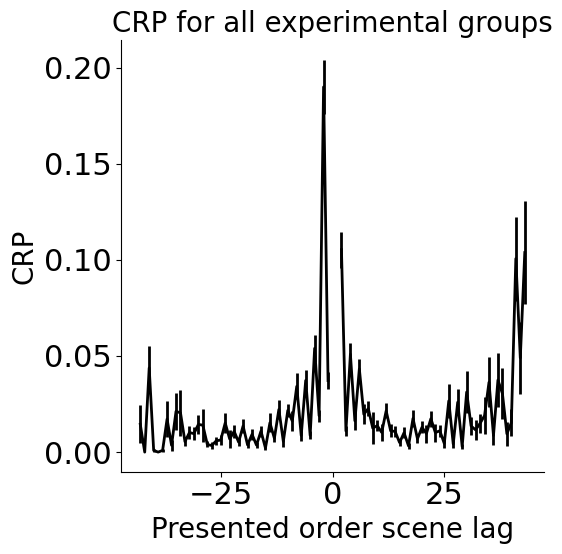

In [34]:
#convert to conditional response probability
xs_jumps_cond=np.divide(xs_jumps,broad_diff_poss)
xs_jumps_noco_cond=np.divide(xs_jumps_noco,broad_diff_poss_so)
xs_jumps_so_cond=np.divide(xs_jumps_so,broad_diff_poss_so)

f, ax = plt.subplots(1,1, figsize = (fs1,fs2))
im=ax.imshow(xs_jumps_cond,interpolation='none',cmap='gray',aspect='auto')
ax.set_xticks(np.arange(len(js[:-1])))
ax.set_xticklabels(js[:-1],fontsize=15)

f, ax = plt.subplots(1,1, figsize = (fs1,fs2))
im=ax.imshow(xs_jumps_noco_cond,interpolation='none',cmap='gray',aspect='auto')
ax.set_xticks(np.arange(len(js[:-1])))
ax.set_xticklabels(js[:-1],fontsize=15)

f, ax = plt.subplots(1,1, figsize = (6,6))
y=xs_jumps_cond+0
y1=np.nanmean(y,axis=0)
err=np.zeros((y.shape[1]))
for i in range(y.shape[1]):
    err[i]=np.nanstd(y[:,i])/np.sqrt(y.shape[0])
y1[n_ev],err[n_ev]=math.nan,math.nan
plt.errorbar(js[:-1],y1,err,color='k',linewidth=2,elinewidth=2)
ax.set_xlabel('Presented order scene lag',fontsize=20)
ax.set_ylabel(crp_lab,fontsize=20)
ax.set_title('CRP for all experimental groups',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.tight_layout()
#plt.savefig(fn, transparent=True)

# Subscenes - CRP (Fig 6)

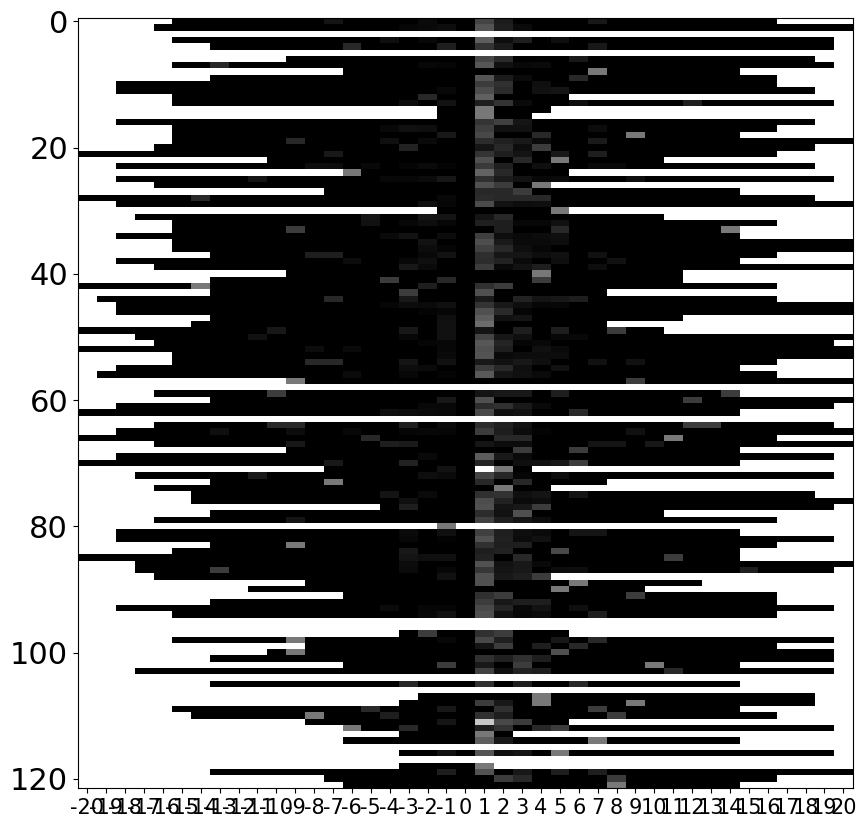

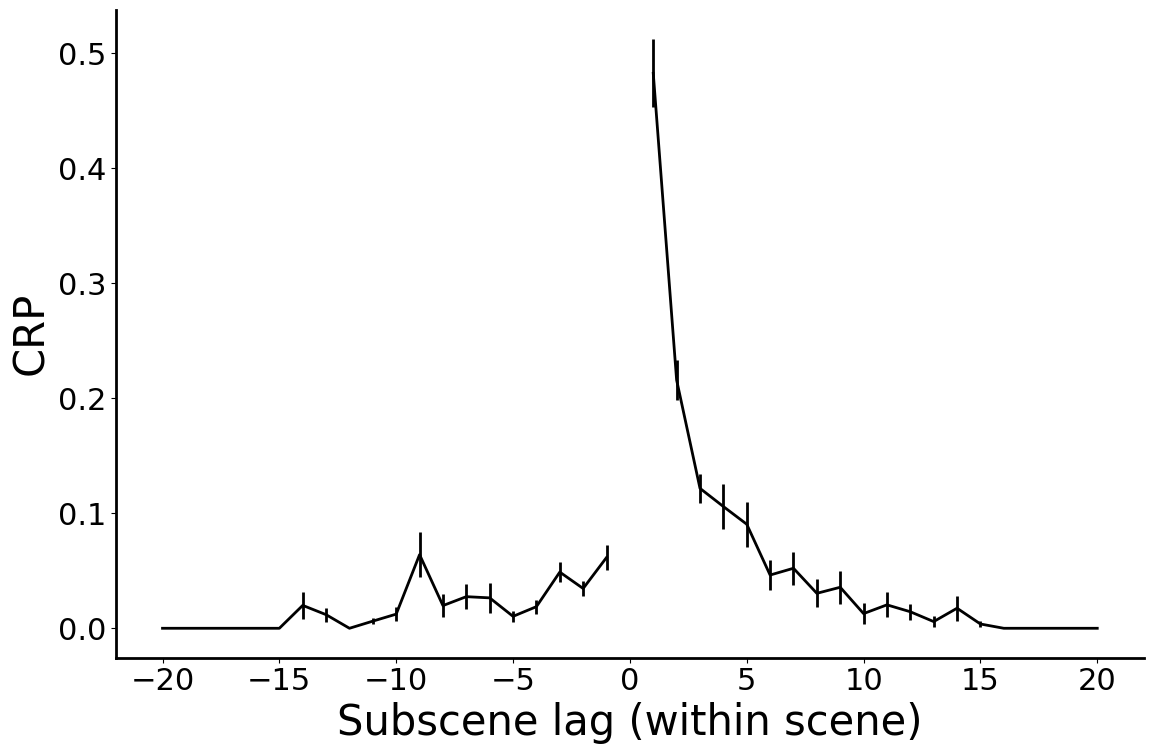

In [35]:
#viz all subjects
f, ax = plt.subplots(1,1, figsize = (fs1,fs2))
im=ax.imshow(xsub_prop_subscene,interpolation='none',cmap='gray',aspect='auto')
ax.set_xticks(np.arange(len(sub_xlab)))
ax.set_xticklabels(sub_xlab,fontsize=15)

#plot means w/in lag
f, ax = plt.subplots(1,1, figsize = (12,8))
y=xsub_prop_subscene+0
y1=np.nanmean(y,axis=0)
err=np.zeros((y.shape[1]))
for i in range(y.shape[1]):
    err[i]=np.nanstd(y[:,i])/np.sqrt(y.shape[0])
y1[max_subscene_jump],err[max_subscene_jump]=math.nan,math.nan
plt.errorbar(sub_xlab,y1,err,color='k',linewidth=2,elinewidth=2)
ax.set_xlabel('Subscene lag (within scene)',fontsize=30)
ax.set_ylabel(crp_lab,fontsize=30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(lw)
fn=figf+'subscenes_crp.pdf'
f.tight_layout()
plt.savefig(fn, transparent=True)

# Transition-wise strategy analysis (Fig 3)

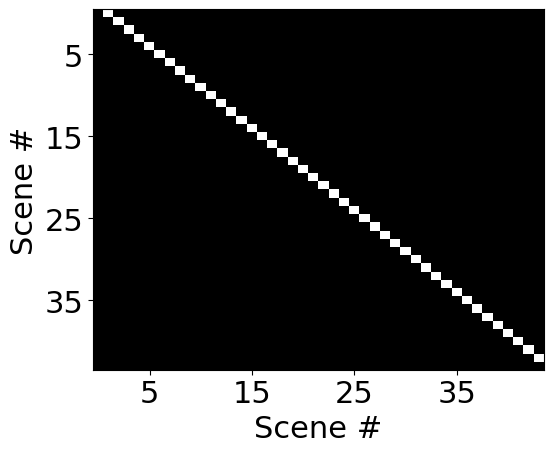

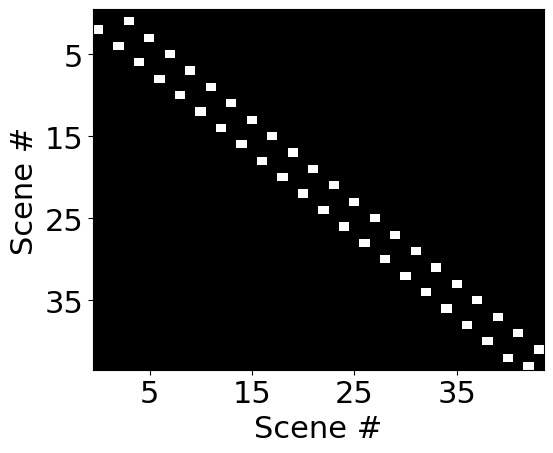

In [36]:
#first create pres/chrono order matrices - Fig 3A
pres_order_m,chrono_order_m=np.zeros((n_ev,n_ev)),np.zeros((n_ev,n_ev))
for i in range(n_ev): #nSubs #loop over subs
  if i<n_ev-1:
    pres_order_m[i,i+1]=1
  if i==n_ev-1:
    chrono_order_m[i,i-1]=1
  elif i==0:
    qq=[] #no transitions, final chrono scene
  elif i % 2 == 0: #odd scene, backward
    chrono_order_m[i,i-2]=1
  elif i % 2 == 1: #even scene, backward
    chrono_order_m[i,i+2]=1

f, ax = plt.subplots(1,1, figsize = (fs1*2//3,fs2/2))
im=ax.imshow(pres_order_m,interpolation='none',cmap=cm,aspect='auto')
ax.set_xticks(lin_ev[4::10])
ax.set_yticks(lin_ev[4::10])
ax.set_xlabel('Scene #')
ax.set_ylabel('Scene #')
f.tight_layout()
fn="figs/pres_order_2d_graph.pdf"
plt.savefig(fn, transparent=True)

f, ax = plt.subplots(1,1, figsize = (fs1*2//3,fs2/2))
im=ax.imshow(chrono_order_m,interpolation='none',cmap=cm,aspect='auto')
ax.set_xticks(lin_ev[4::10])
ax.set_yticks(lin_ev[4::10])
ax.set_xlabel('Scene #')
ax.set_ylabel('Scene #')
f.tight_layout()
fn="figs/chrono_order_2d_graph.pdf"
plt.savefig(fn, transparent=True)

for i in range(n_ev): #add nans after plot to avoid viz issues
  pres_order_m[i,i]=math.nan
  chrono_order_m[i,i]=math.nan

In [37]:
preds=['Presented','Semantic','Chronological','Causal','Top causal']
tkl=['Pres','Sem','Chrono','Caus','Causbm']
n_pred=len(preds)-1 # #predictors
n_predp=len(preds)
chance_line=1/(n_ev-1) #can't go to itself
evs_a,evs_cumu_a=[None]*nSubs,np.zeros((nSubs,n_predp))
nStates=np.zeros((nSubs))
for i in range(nSubs): #nSubs #loop over subs
  diff=np.diff(states_a[i]) #find differences
  qq=np.where(diff!=0)[0]
  qq=np.hstack([0,qq+1]) #re-grab first state and then where there are diffs
  states=states_a[i].to_numpy() #convert series to np so we can index
  states=states[qq].astype(int)
  nStates[i]=len(states) # number of states for this subject
  cumu_ev=np.zeros((n_predp))

  #state-based analysis
  #causality: cdat_a_m = 2-D causality matrix
  #causality top match: tcdat_a_m = 2-D matrix w/ only top match for a cause
  #semantic: sem_2d_fs = 2-D semantic matrix
  #presented order: next state is always presented order strategy
  #chronological: -2 if odd, +2 if even, except if 43, which is -1
  evs=np.zeros((int(nStates[i])-1))
  for ii in range(int(nStates[i])-1):
    pres_ev,chrono_ev,caus_ev,sem_ev=0,0,0,0
    curr_state=states[ii]
    next_state=states[ii+1]
    #presented order evidence
    if next_state-curr_state==1:
      pres_ev=1

    #chronological evidence
    if curr_state == 44: #special case - final scene
      if next_state-curr_state==-1:
        chrono_ev=1
    elif curr_state % 2 == 1: #odd scene, backward
      if next_state-curr_state==-2:
        chrono_ev=1
    elif curr_state % 2 == 0: #even scene, forward
      if next_state-curr_state==-2:
        chrono_ev=1

    #causal and semantic evidence - remember to 0 code
    #use curr_state for row and next state for column
    sem_ev=sem_2d_fs[curr_state-1,next_state-1]/np.nansum(sem_2d_fs[curr_state-1,:])
    caus_ev=cdat_a_m[curr_state-1,next_state-1]/np.nansum(cdat_a_m[curr_state-1,:])
    causbm_ev=tcdat_a_m[curr_state-1,next_state-1]/np.nansum(tcdat_a_m[curr_state-1,:])
    ev_comb=[pres_ev,sem_ev,chrono_ev,caus_ev,chance_line]
    temp=np.where(ev_comb==np.max(ev_comb))[0]
    evs[ii]=temp[0]
    ev_comb2=[pres_ev,sem_ev,chrono_ev,caus_ev,causbm_ev,chance_line]
    cumu_ev[:n_predp]=cumu_ev[:n_predp]+ev_comb2[:n_predp] #cumulative evidence
  evs_a[i]=evs #best matches - may not add to 1 sometimes all below chance
  evs_cumu_a[i,:]=cumu_ev/(nStates[i]-1)#/np.sum(cumu_ev) #norm relative to # transitions

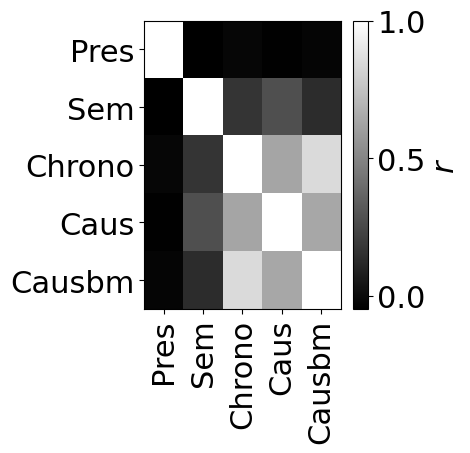

In [38]:
#create cross-correlation plot across transition strategies
comb_mat=np.zeros((n_ev,n_ev,n_predp))
comb_mat[:,:,0],comb_mat[:,:,1]=pres_order_m,sem_2d_fs
comb_mat[:,:,2],comb_mat[:,:,3],comb_mat[:,:,4]=chrono_order_m,cdat_a_m,tcdat_a_m
corr_mat=np.zeros((n_predp,n_predp,2))
for i in range(n_predp):
  for ii in range(n_predp):
    mat1=comb_mat[:,:,i].flatten()
    mat2=comb_mat[:,:,ii].flatten()
    qq=np.where(np.logical_and(~np.isnan(mat1),~np.isnan(mat2)))[0]
    rval,pval=pearsonr(mat1[qq],mat2[qq])
    corr_mat[i,ii,0],corr_mat[i,ii,1]=rval,pval

f, ax = plt.subplots(1,1, figsize = (fs1/2,fs2/2))
im=ax.imshow(corr_mat[:,:,0],interpolation='none',cmap=cm,aspect='auto')
cbar=f.colorbar(im)
cbar.set_label('$\it{r}$', rotation=90)
tk=np.linspace(0,corr_mat.shape[0]-1,corr_mat.shape[0])
ax.set_xticks(tk)
ax.set_xticklabels(tkl,rotation = 90)
ax.set_yticks(tk)
ax.set_yticklabels(tkl,rotation = 0)
fn=figf+'pred_corr.pdf'
f.tight_layout()
plt.savefig(fn, transparent=True)

89
1-samp t-test stat: 3.85381190508415, p: 0.00026891759335647, N: 66
E1, 1-samp t-test stat: 2.353389062542158, p: 0.03172228164583891, N: 17
E2, 1-samp t-test stat: 1.2608165303093195, p: 0.21857214797827984, N: 27
E3, 1-samp t-test stat: 3.5760250772143065, p: 0.0017818408251824246, N: 22
E1 vs E2 stat: 0.8017685430852728, p: 0.4272000058146509, N: 15
E1 vs E3 stat: -0.5136416681900975, p: 0.6105564430827968, N: 18
E2 vs E3 stat: -1.4003715417120426, p: 0.16796941350602854, N: 13


<ipython-input-24-ca30e037217c>:210: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],hue=dat['Experiment'],palette=cp,facecolor=None,size=msz,zorder=1)#color=cp


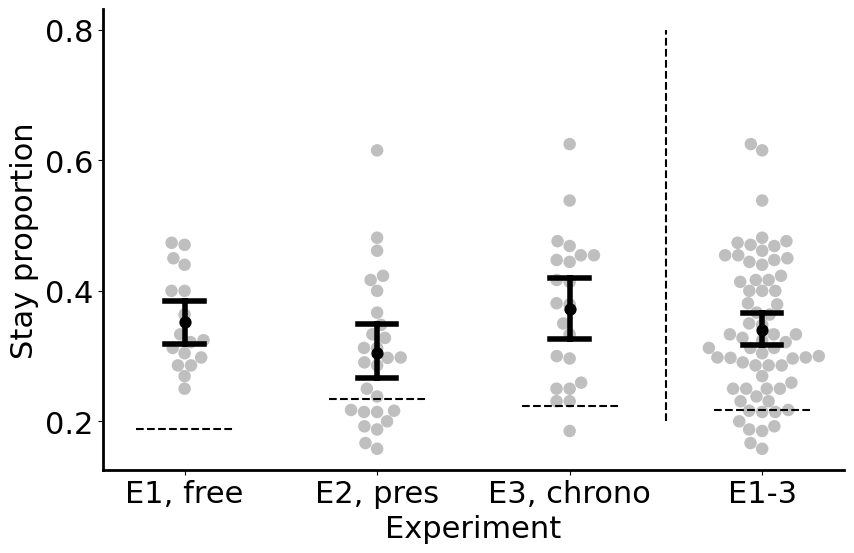

In [39]:
#calculate stickiness - likelihood of staying vs. changing strategy
#after sorting: E1: 0-26, E2: 27-58, E3: 59-88, E4: 89-end
conds_re=np.sort(conds) #re-arrange conds for visualization
nE1_3=len(np.where(conds<4)[0])
new_ind=np.argsort(conds)
print(nE1_3)
perms=100
stay_perc=np.zeros((nSubs))
stay_perc_perm=np.zeros((nSubs,perms))
min_ev=12 #set min # of transitions to avoid large variance
for i in range(nSubs): #loop over subs
  evs=evs_a[i].astype(int)
  diff=np.diff(evs)
  if len(diff)>=min_ev:
    if conds[i]<4:
      stay_perc[i]=len(np.where(diff==0)[0])/len(diff)
      for ii in range(perms):
        q0=np.random.permutation(len(evs))
        evs_scram=evs[q0]
        diff_perm=np.diff(evs_scram)
        stay_perc_perm[i,ii]=len(np.where(diff_perm==0)[0])/len(diff_perm)
    else:
      stay_perc[i]=math.nan
  else:
    stay_perc[i]=math.nan
stay_perc_perm_m=np.mean(stay_perc_perm,axis=1)
temp_a=ma.masked_invalid(stay_perc)
stat,p=stats.ttest_1samp(ma.masked_invalid(stay_perc)-ma.masked_invalid(stay_perc_perm_m),popmean=0)
print('1-samp t-test stat: %s, p: %s, N: %s' %(stat,p,np.sum(temp_a.mask==0)))
ystr1,fn='Stay proportion','figs/stay_percentage.pdf'

fir=ma.masked_invalid(stay_perc[conds.astype(int)==1])
fir_perm=np.mean(stay_perc_perm[conds.astype(int)==1],axis=1)
stat,p=stats.ttest_1samp(ma.masked_invalid(fir)-ma.masked_invalid(fir_perm),popmean=0)
print('E1, 1-samp t-test stat: %s, p: %s, N: %s' %(stat,p,np.sum(fir.mask==0)))
sec=ma.masked_invalid(stay_perc[conds.astype(int)==2])
sec_perm=np.mean(stay_perc_perm[conds.astype(int)==2],axis=1)
stat,p=stats.ttest_1samp(ma.masked_invalid(sec)-ma.masked_invalid(sec_perm),popmean=0)
print('E2, 1-samp t-test stat: %s, p: %s, N: %s' %(stat,p,np.sum(sec.mask==0)))
thi=ma.masked_invalid(stay_perc[conds.astype(int)==3])
thi_perm=np.mean(stay_perc_perm[conds.astype(int)==3],axis=1)
stat,p=stats.ttest_1samp(ma.masked_invalid(thi)-ma.masked_invalid(thi_perm),popmean=0)
print('E3, 1-samp t-test stat: %s, p: %s, N: %s' %(stat,p,np.sum(thi.mask==0)))

firsecthi=ma.masked_invalid(stay_perc[conds.astype(int)<4])
stat,p=stats.ttest_ind(fir-fir_perm,sec-sec_perm)
print('E1 vs E2 stat: %s, p: %s, N: %s' %(stat,p,np.sum(fir.mask)+np.sum(sec.mask)))
stat,p=stats.ttest_ind(fir-fir_perm,thi-thi_perm)
print('E1 vs E3 stat: %s, p: %s, N: %s' %(stat,p,np.sum(fir.mask)+np.sum(thi.mask)))
stat,p=stats.ttest_ind(sec-sec_perm,thi-thi_perm)
print('E2 vs E3 stat: %s, p: %s, N: %s' %(stat,p,np.sum(sec.mask)+np.sum(thi.mask)))
fn='figs/stay_percentage_Exp1_3.pdf'
barswarm(fir,sec,thi,firsecthi,ystr1,ystr1,fn,5)

In [40]:
#visualize strategy!
#sort by conditions to group together subjects for plot
mx_s=int(np.max(nStates)) #max # states
strat_mat,stratct=np.zeros((nSubs,mx_s)),np.zeros((nSubs,n_pred))
fir_pres_ord,sec_pres_ord=np.zeros((nSubs)),np.zeros((nSubs))
for i in range(nSubs): #loop over subs
  evs=evs_a[i].astype(int)+1 #add 1 to dissociate from 0 (no response)
  if len(evs)>1:
    halfpt=int(np.floor(len(evs)/2))
    strat_mat[i,:int(nStates[i]-1)]=evs
    fir_pres_ord[i]=len(np.where(evs[:halfpt]==1)[0])/halfpt
    sec_pres_ord[i]=len(np.where(evs[halfpt:]==1)[0])/(len(evs)-halfpt)
    for ii in range(n_pred): #loop over strategies
      stratct[i,ii]=len(np.where(evs==ii+1)[0])
    stratct[i,:]=stratct[i,:]/np.sum(stratct[i,:])
  else:
    fir_pres_ord[i]=math.nan
    sec_pres_ord[i]=math.nan
    stratct[i,:]=math.nan
    evs_cumu_a[i,:]=math.nan #add this to make nans where not >1 event

nE1_3=len(np.where(conds<4)[0])
conds1_3=conds[new_ind[:nE1_3]]
strat_mat_re=strat_mat[new_ind,:] #re-arrange in experiment order
strat_mat_re=strat_mat_re[:nE1_3,:] #only plot first 3 Exps
stratct_re=stratct[new_ind,:] #ditto
stratct_re1_3=stratct_re[:nE1_3,:]
stratcumu_re=evs_cumu_a[new_ind,:]
stratcumu_re1_3=stratcumu_re[:nE1_3,:]

<ipython-input-40-802872c99c60>:15: RuntimeWarning: invalid value encountered in divide
  stratct[i,:]=stratct[i,:]/np.sum(stratct[i,:])


In [41]:
#export to R for ANOVAs
#put data into dataframe
sub_num=np.zeros((len(subs)))
for i in range(nSubs): #loop over all of the participants
    sub_num[i]=int(subs[i])

sub_num=sub_num[new_ind[:nE1_3]]
dft=pd.DataFrame()
dft['Sub']=sub_num+0
dft['Cond']=conds1_3+0
dft['PresEv']=stratcumu_re1_3[:,0]
dft['SemEv']=stratcumu_re1_3[:,1]
dft['ChronoEv']=stratcumu_re1_3[:,2]
dft['CausEv']=stratcumu_re1_3[:,3]
dft['TopCausEv']=stratcumu_re1_3[:,4]
dft['PresB']=stratct_re1_3[:,0]
dft['SemB']=stratct_re1_3[:,1]
dft['ChronoB']=stratct_re1_3[:,2]
dft['CausB']=stratct_re1_3[:,3]
exportR=1
fn='RStuff/transitions.csv' #just put in this folder
if exportR:
  dft.to_csv(fn)

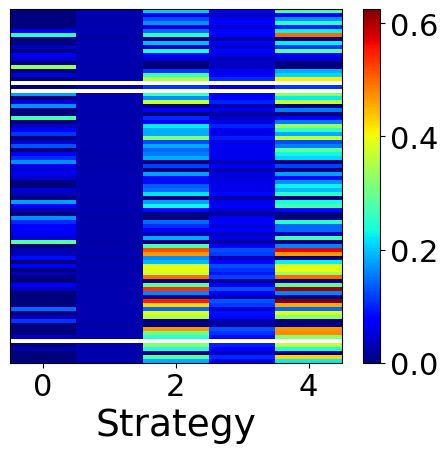

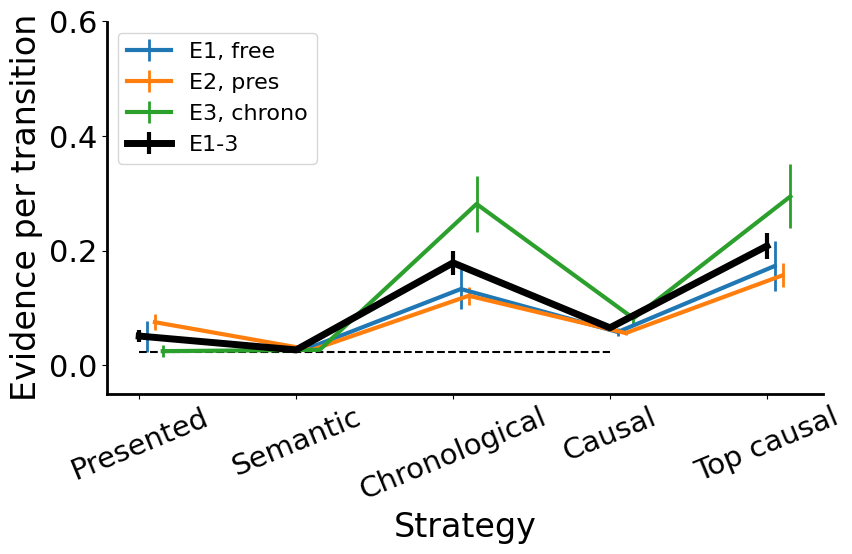

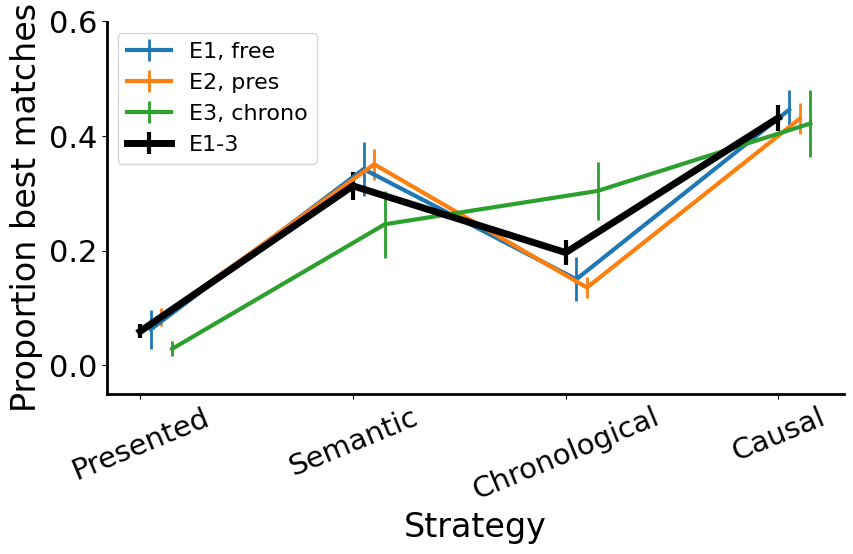

In [42]:
#plot strategy count for all strategies - Fig 3C-D
f, ax = plt.subplots(1,1, figsize = (5,5))
im=ax.imshow(stratcumu_re1_3,interpolation='none',cmap='jet',aspect='auto')
ax.set_xlabel('Strategy',fontsize=27)
ax.set_yticklabels([])
ax.tick_params(left = False)
cbar = f.colorbar(im)
f.tight_layout()

fn,yl=figf + 'strategyCountMeanEv.pdf','Evidence per transition'
plot_strat(stratcumu_re1_3,fn,yl,0,1)
fn,yl=figf + 'strategyCountMeanBest.pdf','Proportion best matches'
plot_strat(stratct_re1_3,fn,yl,0,0)

In [44]:
#print out those semantic values eeking out above chance
print(stratcumu_re1_3[:,1])
print(chance_line)

[0.02627048 0.02730204 0.02517212 0.02678632 0.0271308  0.02761055
 0.02593072 0.02110088 0.02818699 0.02646935 0.02710542 0.0255781
 0.02753779 0.02456871 0.02419641 0.02588834 0.0261505  0.02733749
        nan 0.0271783         nan 0.02693653 0.02654534 0.02694718
 0.02586982 0.02748282 0.0265747  0.02575726 0.02592051 0.02844008
 0.02636481 0.02642206 0.02922023 0.02499443 0.02725538 0.02791632
 0.02653201 0.02615229 0.02506155 0.02653003 0.02551232 0.02821042
 0.02704105 0.02747883 0.02628401 0.02689948 0.02688332 0.02654182
 0.02602852 0.02677324 0.0270743  0.02574835 0.02414675 0.02535869
 0.02568162 0.02511011 0.02609044 0.0254691  0.02440504 0.02440317
 0.02784996 0.02750854 0.02360986 0.0269104  0.02679565 0.02656526
 0.02652572 0.02692363 0.02610132 0.025847   0.0283131  0.02728392
 0.02557646 0.02725    0.02796114 0.02579776 0.02802261 0.02707097
 0.02567928 0.02152938 0.02802893 0.02835755 0.0268215         nan
 0.02817389 0.02632749 0.02434424 0.02698381 0.02633238]
0.0232

In [45]:
#run stats on each experiment
for i in range(3): #all exps
  for ii in range(n_pred):
    qq=np.where(np.logical_and(conds1_3.astype(int)==i+1,~np.isnan(stratct_re1_3[:,ii])))[0]
    astats1(stratct_re1_3[qq,ii],chance_line,'Exp '+str(i+1)+' '+preds[ii]+' best matches based N = ' + str(len(qq)))
for i in range(3): #all exps
  for ii in range(n_predp):
    qq=np.where(np.logical_and(conds1_3.astype(int)==i+1,~np.isnan(stratcumu_re1_3[:,ii])))[0]
    astats1(stratcumu_re1_3[qq,ii],chance_line,'Exp '+str(i+1)+' '+preds[ii]+' cumulative evidence based N = ' + str(len(qq)))

Exp 1 Presented best matches based N = 25
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz  g1med  \
0   0.0   25  0.062  0.022  24  1.755      0  1.755  0.092   0.572    0.0   

   p_ttest    lb    ub  
0    0.092  0.02  0.11  


Exp 1 Semantic best matches based N = 25
   meth  g1n    g1m   g1s  df    stat  zstat   tstat    p  eff_sz     g1med  \
0   0.0   25  0.342  0.03  24  10.586      0  10.586  0.0   2.318  0.333333   

   p_ttest    lb   ub  
0      0.0  0.28  0.4  


Exp 1 Chronological best matches based N = 25
   meth  g1n   g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   25  0.15  0.025  24  5.058      0  5.058  0.0   1.222  0.155556   

   p_ttest   lb   ub  
0      0.0  0.1  0.2  


Exp 1 Causal best matches based N = 25
   meth  g1n    g1m    g1s  df    stat  zstat   tstat    p  eff_sz     g1med  \
0   0.0   25  0.446  0.022  24  19.103      0  19.103  0.0   4.114  0.461538   

   p_ttest   lb    ub  
0      0.0  0.4  0.49  


Ex

In [46]:
#comparatives stats for all experiments combined, best matches
for ii in range(n_pred):
  for iii in range(n_pred):
    if ii>iii:
      qq=np.where(~np.isnan(stratct_re1_3[:,ii]))[0]
      astats1(stratct_re1_3[qq,ii]-stratct_re1_3[qq,iii],0,preds[ii]+' vs '+preds[iii]+', best matches based N = ' + str(len(qq)+len(qqq)))

Semantic vs Presented, best matches based N = 88
   meth  g1n    g1m    g1s  df    stat  zstat   tstat    p  eff_sz  g1med  \
0   0.0   86  0.254  0.021  85  11.901      0  11.901  0.0   1.291   0.25   

   p_ttest    lb   ub  
0      0.0  0.21  0.3  


Chronological vs Presented, best matches based N = 88
   meth  g1n    g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   86  0.138  0.021  85  6.652      0  6.652  0.0   0.722  0.111111   

   p_ttest   lb    ub  
0      0.0  0.1  0.18  


Chronological vs Semantic, best matches based N = 88
   meth  g1n    g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   86 -0.116  0.031  85 -3.763      0 -3.763  0.0  -0.408 -0.111111   

   p_ttest    lb    ub  
0      0.0 -0.18 -0.05  


Causal vs Presented, best matches based N = 88
   meth  g1n    g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   86  0.373  0.021  85  17.64      0  17.64  0.0   1.913  0.370899   

   p_ttest    lb   

In [47]:
#comparatives stats for all experiments combined, cumulative evidence
for ii in range(n_predp):
  for iii in range(n_predp):
    if ii>iii:
      qq=np.where(~np.isnan(stratcumu_re1_3[:,ii]))[0]
      astats1(stratcumu_re1_3[qq,ii]-stratcumu_re1_3[qq,iii],0,preds[ii]+' vs '+preds[iii]+', cumulative evidence based N = ' + str(len(qq)+len(qqq)))

Semantic vs Presented, cumulative evidence based N = 88
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz     g1med  \
0   0.0   86 -0.024  0.008  85 -3.119      0 -3.119  0.002  -0.338 -0.003354   

   p_ttest    lb    ub  
0    0.002 -0.04 -0.01  


Chronological vs Presented, cumulative evidence based N = 88
   meth  g1n    g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   86  0.128  0.019  85  6.746      0  6.746  0.0   0.732  0.092505   

   p_ttest    lb    ub  
0      0.0  0.09  0.17  


Chronological vs Semantic, cumulative evidence based N = 88
   meth  g1n    g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   86  0.152  0.016  85  9.721      0  9.721  0.0   1.054  0.136298   

   p_ttest    lb    ub  
0      0.0  0.12  0.18  


Causal vs Presented, cumulative evidence based N = 88
   meth  g1n    g1m    g1s  df  stat  zstat  tstat      p  eff_sz     g1med  \
0   0.0   86  0.014  0.009  85   1.6      0    1.6  0.113  

In [48]:
#specific follow-up
qq=np.where(np.logical_and(conds1_3.astype(int)==1,~np.isnan(stratcumu_re1_3[:,ii])))[0]
astats1(stratcumu_re1_3[qq,0]-stratcumu_re1_3[qq,3],0,preds[0]+' vs '+preds[3]+', cumulative evidence in Exp 1 based N = ' + str(len(qq)+len(qqq)))
astats1(stratcumu_re1_3[qq,0]-stratcumu_re1_3[qq,2],0,preds[0]+' vs '+preds[2]+', cumulative evidence in Exp 1 based N = ' + str(len(qq)+len(qqq)))
qq=np.where(np.logical_and(conds1_3.astype(int)==2,~np.isnan(stratcumu_re1_3[:,ii])))[0]
astats1(stratcumu_re1_3[qq,0]-stratcumu_re1_3[qq,3],0,preds[0]+' vs '+preds[3]+', cumulative evidence in Exp 2 based N = ' + str(len(qq)+len(qqq)))
astats1(stratcumu_re1_3[qq,0]-stratcumu_re1_3[qq,2],0,preds[0]+' vs '+preds[2]+', cumulative evidence in Exp 2 based N = ' + str(len(qq)+len(qqq)))
qq=np.where(np.logical_and(conds1_3.astype(int)==3,~np.isnan(stratcumu_re1_3[:,ii])))[0]
astats1(stratcumu_re1_3[qq,0]-stratcumu_re1_3[qq,3],0,preds[0]+' vs '+preds[3]+', cumulative evidence in Exp 3 based N = ' + str(len(qq)+len(qqq)))

Presented vs Causal, cumulative evidence in Exp 1 based N = 27
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz     g1med  \
0   0.0   25 -0.007  0.018  24 -0.405      0 -0.405  0.689  -0.083 -0.039184   

   p_ttest    lb    ub  
0    0.689 -0.05  0.03  


Presented vs Chronological, cumulative evidence in Exp 1 based N = 27
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz     g1med  \
0   0.0   25 -0.083  0.028  24 -2.866      0 -2.866  0.009  -0.585 -0.083333   

   p_ttest    lb    ub  
0    0.009 -0.14 -0.02  


Presented vs Causal, cumulative evidence in Exp 2 based N = 34
   meth  g1n    g1m    g1s  df   stat  zstat  tstat     p  eff_sz     g1med  \
0   0.0   32  0.019  0.014  31  1.341      0  1.341  0.19   0.241  0.002236   

   p_ttest    lb    ub  
0     0.19 -0.01  0.05  


Presented vs Chronological, cumulative evidence in Exp 2 based N = 34
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz     g1med  \
0   0.0   32 -0.0

meth  g1n    g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   29 -0.057  0.011  28 -5.258      0 -5.258  0.0  -0.994 -0.065563   

   p_ttest    lb    ub  
0      0.0 -0.08 -0.03

<ipython-input-24-ca30e037217c>:210: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],hue=dat['Experiment'],palette=cp,facecolor=None,size=msz,zorder=1)#color=cp
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 23.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-24-ca30e037217c>:210: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],hue=dat['Experiment'],palette=cp,facecolor=None,size=msz,zorder=1)#color=cp
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 23.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


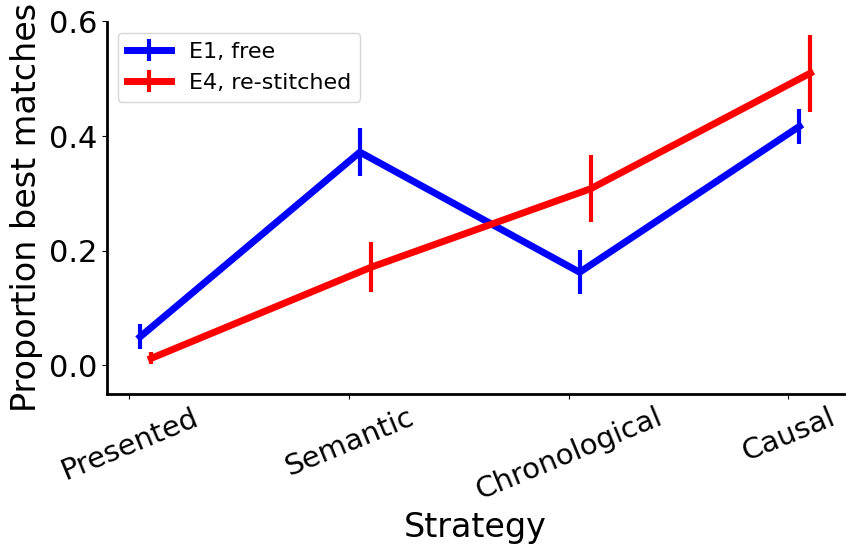

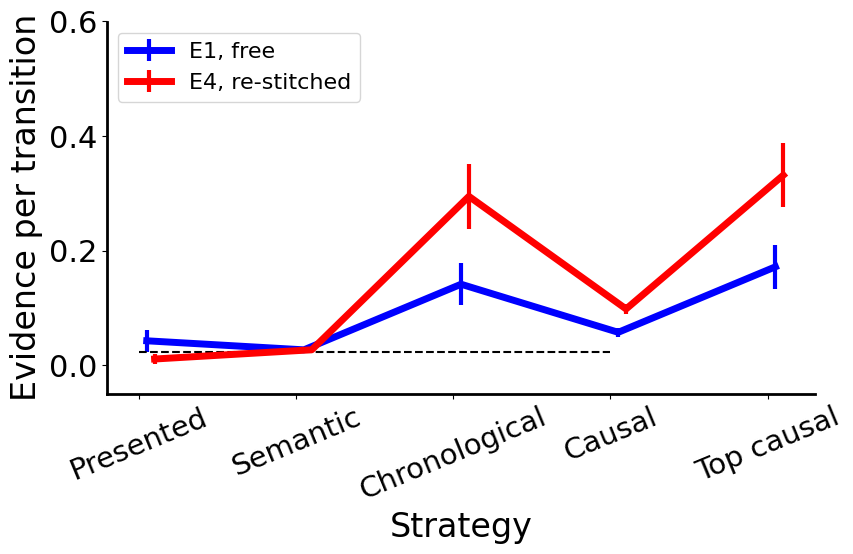

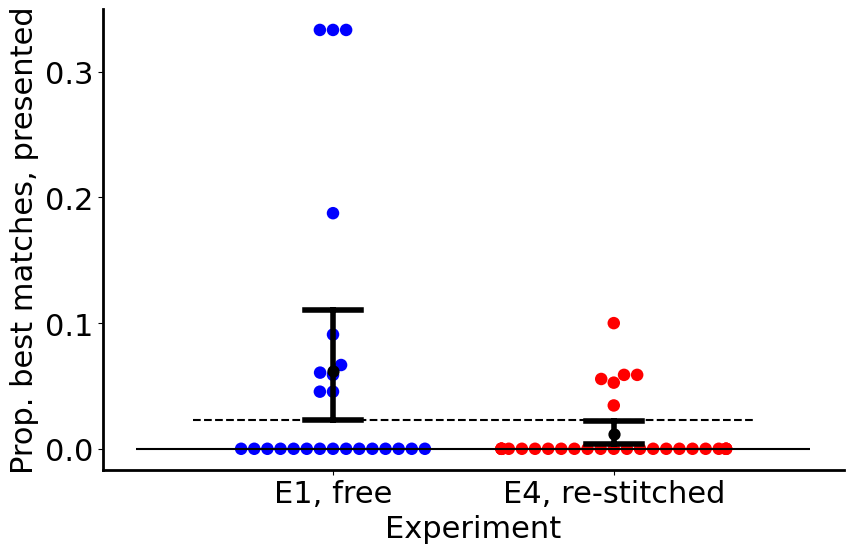

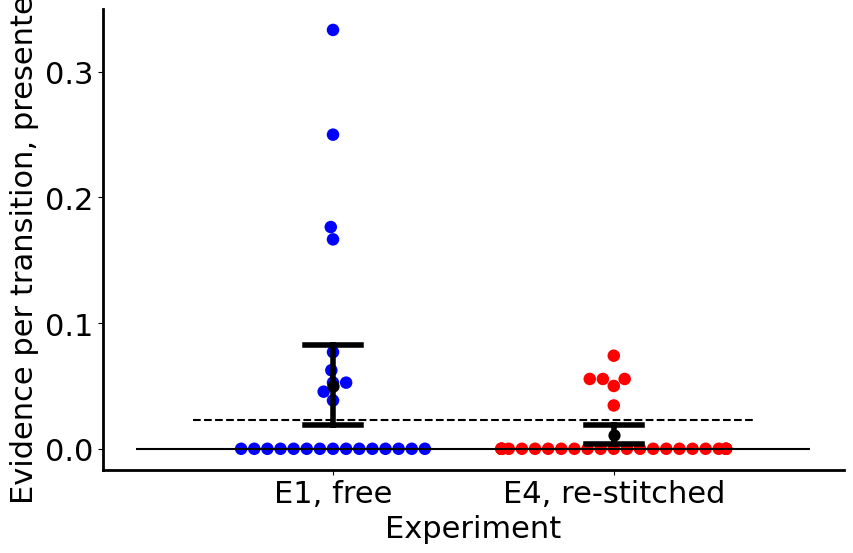

In [50]:
#plot Exp 1 v 4 (Fig 5D-E)
fn,yl=figf + 'strategyCountMeanBest1v4.pdf','Proportion best matches'
plot_strat(stratct_re,fn,yl,1,0)
fn,yl=figf + 'strategyCountMeanEv1v4.pdf','Evidence per transition'
plot_strat(stratcumu_re,fn,yl,1,1)

ystr1='Prop. best matches, presented'
fn='figs/strategyCountMeanBestEvPresOnly1v4.pdf'
q1=np.where(np.logical_and(conds.astype(int)==1,~np.isnan(stratct[:,0])))[0]
q4=np.where(np.logical_and(conds.astype(int)==4,~np.isnan(stratct[:,0])))[0]
barswarm(stratct[q1,0],stratct[q4,0],[],[],ystr1,ystr1,fn,8)
ystr1='Evidence per transition, presented'
fn='figs/strategyCountMeanEvPresOnly1v4.pdf'
barswarm(evs_cumu_a[q1,0],evs_cumu_a[q4,0],[],[],ystr1,ystr1,fn,8)

In [51]:
#qq=np.where(np.logical_and(conds.astype(int)==1,~np.isnan(stratct[:,0])))[0]
astats1(stratct[q1,0],chance_line,'Exp 1 best match vs. chance')
astats1(evs_cumu_a[q1,0],chance_line,'Exp 1 evidence / trans vs. chance')
astats1(stratct[q4,0],chance_line,'Exp 4 best match vs. chance')
astats1(evs_cumu_a[q4,0],chance_line,'Exp 4 evidence / trans vs. chance')

Exp 1 best match vs. chance
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz  g1med  \
0   0.0   25  0.062  0.022  24  1.755      0  1.755  0.092   0.572    0.0   

   p_ttest    lb    ub  
0    0.092  0.02  0.11  


Exp 1 evidence / trans vs. chance
   meth  g1n   g1m    g1s  df   stat  zstat  tstat      p  eff_sz  g1med  \
0   0.0   25  0.05  0.017  24  1.521      0  1.521  0.141   0.578    0.0   

   p_ttest    lb    ub  
0    0.141  0.01  0.09  


Exp 4 best match vs. chance
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz  g1med  \
0   0.0   30  0.012  0.005  29 -2.367      0 -2.367  0.025   0.469    0.0   

   p_ttest   lb    ub  
0    0.025  0.0  0.02  


Exp 4 evidence / trans vs. chance
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz  g1med  \
0   0.0   30  0.011  0.004  29 -2.999      0 -2.999  0.006   0.486    0.0   

   p_ttest   lb    ub  
0    0.006  0.0  0.02  




meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz  g1med  \
0   0.0   30  0.011  0.004  29 -2.999      0 -2.999  0.006   0.486    0.0   

   p_ttest   lb    ub  
0    0.006  0.0  0.02

<ipython-input-52-d5e0e7fdbc1e>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['E1, free','E2, pres','E3, chrono'],fontsize=22)


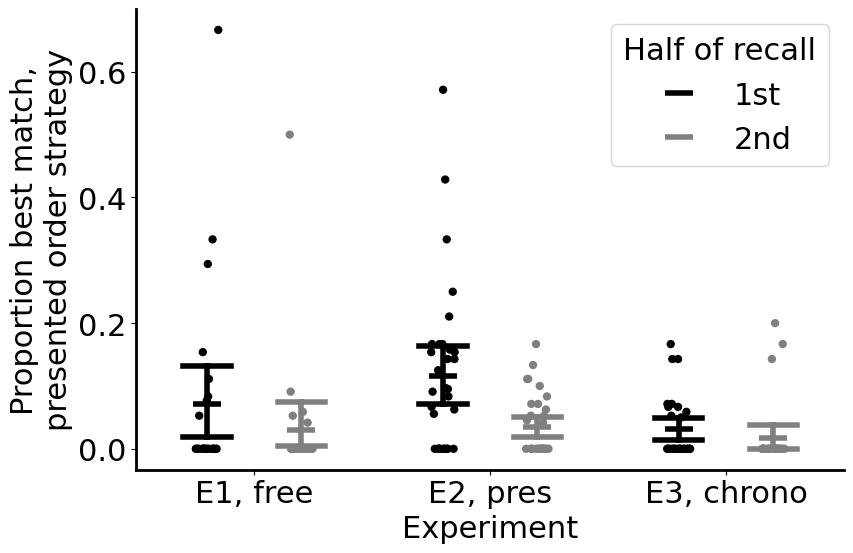

In [52]:
#split-half recall plot (Fig 3E)
conds_d=np.hstack([np.matlib.repmat(conds_re,1,1),np.matlib.repmat(conds_re,1,1)])
conds_d=conds_d[0,:]
halfs_d=np.vstack([np.matlib.repmat('1st',len(new_ind),1),np.matlib.repmat('2nd',len(new_ind),1)])
halfs_d=halfs_d[:,0]
pres_ord_d=np.hstack([fir_pres_ord[new_ind],sec_pres_ord[new_ind]])
yl='''Proportion best match,
presented order strategy'''
hl='Half of recall'
df_s=pd.DataFrame({'Experiment':conds_d,hl:halfs_d,yl:pres_ord_d})
df_s_1_3 = df_s[df_s.Experiment != 4] #cut restitched

cp=[(0,0,0),(0.5,0.5,0.5)] #cp = sns.color_palette("hls", 8)
f, ax = plt.subplots(1,1,figsize = (9,6))
ax=sns.stripplot(data=df_s_1_3, x='Experiment',y=yl,hue=hl,
    dodge=True,legend=False,palette=cp,size=6)
ax=sns.pointplot(data=df_s_1_3, x='Experiment',y=yl,hue=hl,dodge=.4,linestyle="none",
    err_kws={'linewidth': lw*2},capsize=.2,marker="_", markersize=20, markeredgewidth=4,palette=cp)
ax.set_ylabel(yl,fontsize=22)
ax.set_xticklabels(['E1, free','E2, pres','E3, chrono'],fontsize=22)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(lw)
f.tight_layout()
fn=figf + "presOrderPerc.pdf"
plt.savefig(fn, transparent=True)

In [53]:
#stats for presentation order strategy
cat1=df_s[np.logical_and(df_s['Experiment']==1,df_s[hl]=='1st')]
cat1=ma.masked_invalid(cat1[yl].values)
cat2=df_s[np.logical_and(df_s['Experiment']==1,df_s[hl]=='2nd')]
cat2=ma.masked_invalid(cat2[yl].values)
stat,p=ttest_1samp(cat1-cat2,popmean=0)
print('E1, free, stat: %s, p: %s, N: %s' %(stat,p,len(cat1)))
stat,p=ttest_1samp(cat1,popmean=chance_line)
print('E1, free, first half against zero, stat: %s, p: %s, N: %s' %(stat,p,len(cat1)))
cat1=df_s[np.logical_and(df_s['Experiment']==2,df_s[hl]=='1st')]
cat1=ma.masked_invalid(cat1[yl].values)
cat2=df_s[np.logical_and(df_s['Experiment']==2,df_s[hl]=='2nd')]
cat2=ma.masked_invalid(cat2[yl].values)
stat,p=ttest_1samp(cat1-cat2,popmean=0)
print('E2, pres, stat: %s, p: %s, N: %s' %(stat,p,len(cat1)))
cat1=df_s[np.logical_and(df_s['Experiment']==3,df_s[hl]=='1st')]
cat1=ma.masked_invalid(cat1[yl].values)
cat2=df_s[np.logical_and(df_s['Experiment']==3,df_s[hl]=='2nd')]
cat2=ma.masked_invalid(cat2[yl].values)
stat,p=ttest_1samp(cat1-cat2,popmean=0)
print('E3, chrono, stat: %s, p: %s, N: %s' %(stat,p,len(cat1)))
cat1=df_s[np.logical_and(df_s['Experiment']==4,df_s[hl]=='1st')]
cat1=ma.masked_invalid(cat1[yl].values)
cat2=df_s[np.logical_and(df_s['Experiment']==4,df_s[hl]=='2nd')]
cat2=ma.masked_invalid(cat2[yl].values)
stat,p=ttest_1samp(cat1-cat2,popmean=0)
print('E4, restitch, stat: %s, p: %s, N: %s' %(stat,p,len(cat1)))
stat,p=ttest_1samp(cat1,popmean=chance_line)
print('E4, re-stitch, first half against zero, stat: %s, p: %s, N: %s' %(stat,p,len(cat1)))

E1, free, stat: 1.0794297612661878, p: 0.2911252741188019, N: 27
E1, free, first half against zero, stat: 1.5476488477530417, p: 0.13479332121822243, N: 27
E2, pres, stat: 3.428755684613448, p: 0.0017334781785798305, N: 32
E3, chrono, stat: 1.0035792754060129, p: 0.32417606824307776, N: 30
E4, restitch, stat: 1.0914670192465026, p: 0.2837560220645996, N: 33
E4, re-stitch, first half against zero, stat: -1.066123029601411, p: 0.2948732798196436, N: 33


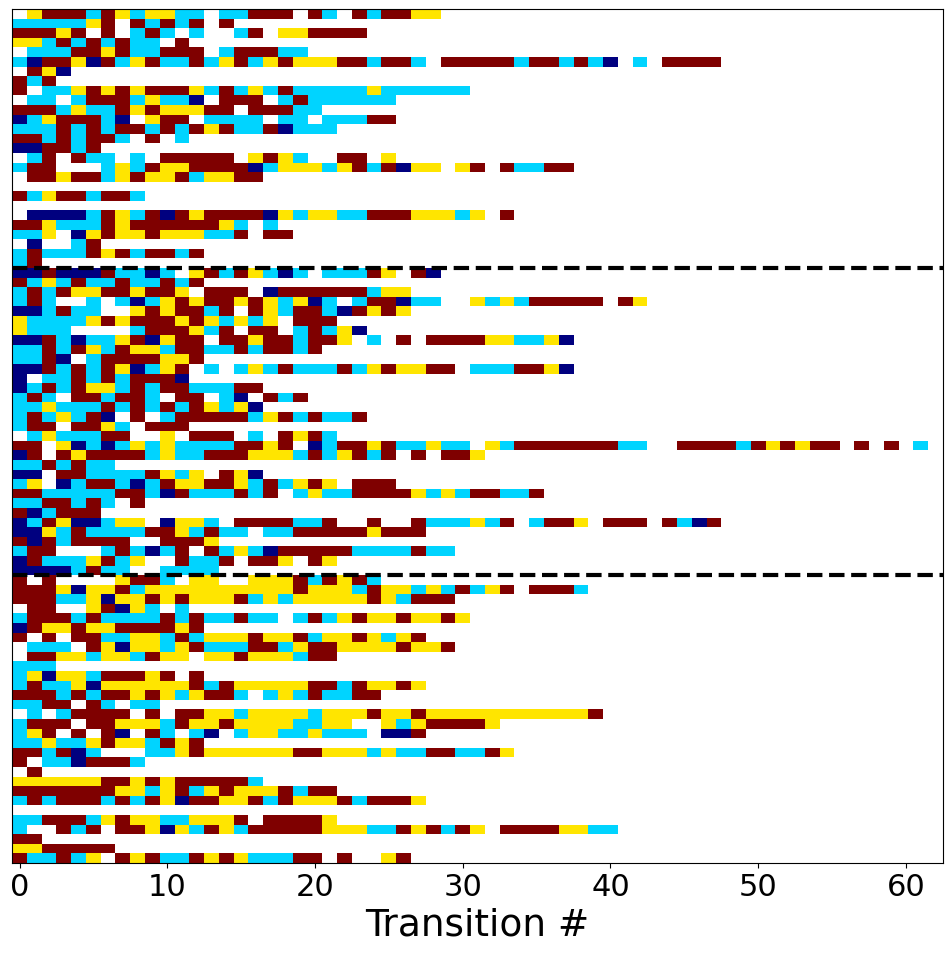

In [54]:
#plot full strategy time course - Fig 3B
strat_mat_re[strat_mat_re==0]=math.nan #nan out 0s for viz
strat_mat_re[strat_mat_re==5]=math.nan #nan out times when chance = best match
f, ax = plt.subplots(1,1, figsize = (fs1,fs2))
im=ax.imshow(strat_mat_re,interpolation='none',cmap='jet',aspect='auto')
ax.set_xlabel('Transition #',fontsize=27)
ax.set_yticklabels([])
ax.tick_params(left = False)
ax.hlines([26.5,58.5],-0.5,mx_s-0.5,colors='k',linestyles='dashed',linewidth=3)
ax.set_rasterized(True)
#cbar = f.colorbar(im)
fn=figf + "strategyOverTimeAllSubs.pdf"
f.tight_layout()
plt.savefig(fn, transparent=True)

# Memorability analyses (Fig 4)

(89, 87)


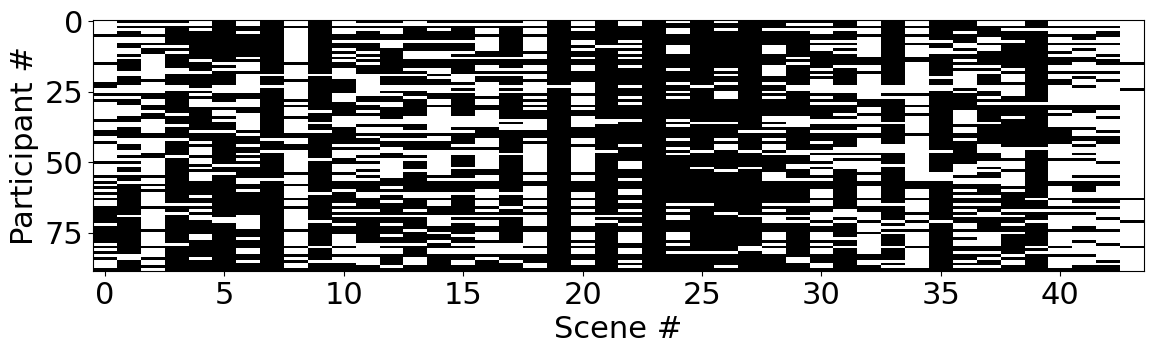

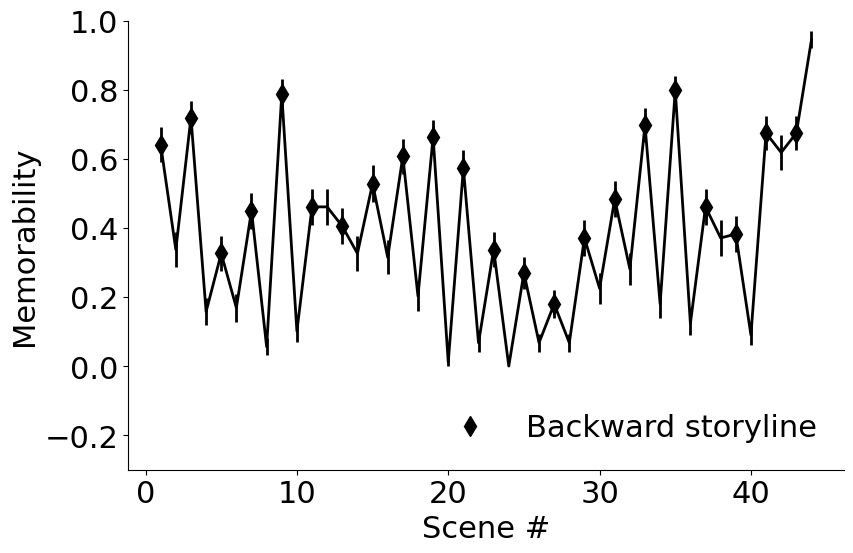

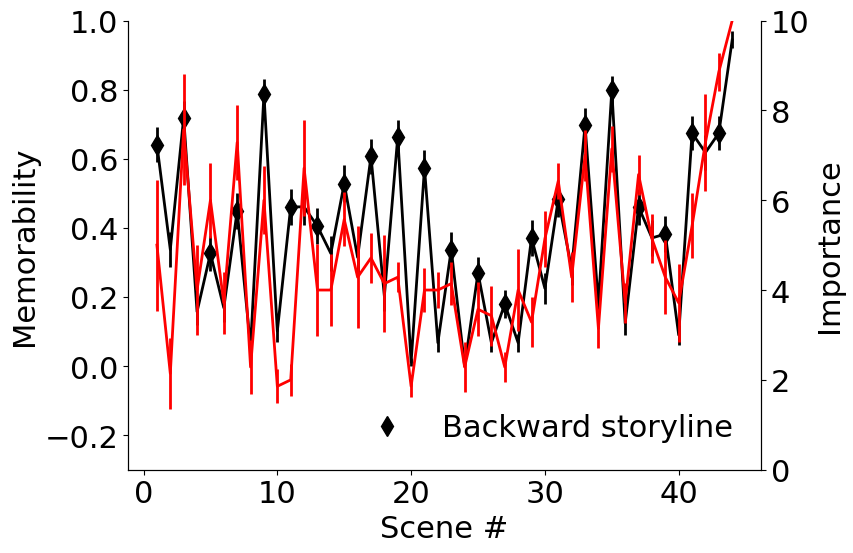

In [55]:
# plot x-sub memorability
qq=np.where(conds<4)[0]
xs_jumps1_3=xs_jumps_cond[qq,:] #xs_jumps
subs1_3=xs_jumps1_3.shape[0]
print(xs_jumps1_3.shape)
memo1_3=memo[qq,:]

f, ax = plt.subplots(1,1,figsize = (12,4))
ax.imshow(memo1_3,interpolation='none',cmap='gray',aspect='auto')
ax.set_xlabel('Scene #')
ax.set_ylabel('Participant #')
fn=figf+'all_sub_memorability.pdf'
f.tight_layout()
f.savefig(fn, transparent=True)

f, ax = plt.subplots(1,1,figsize = (9,6))
x,y,err=np.linspace(1,int(las),int(las)),np.mean(memo1_3,axis=0),np.std(memo1_3,axis=0)/np.sqrt(subs1_3)
x=x.astype(int)
ax.errorbar(x,y,err,color='k',linewidth=lw)
ax.set_xlabel('Scene #')
ax.set_ylabel('Memorability')
x2=np.linspace(1,int(las)-1,int(las)//2)
x2=x2.astype(int)
y2=y[::2]
ax.plot(x2,y2,'dk',markersize=10)
ax.legend(['Backward storyline'],loc='lower right',frameon=False)
ax.set_ylim([-0.3,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.tight_layout()
fn=figf+'xsub_memorability.pdf'
f.savefig(fn, transparent=True)

#add importance data to plot
f, ax = plt.subplots(1,1,figsize = (9,6))
x,y,err=np.linspace(1,int(las),int(las)),np.mean(memo1_3,axis=0),np.std(memo1_3,axis=0)/np.sqrt(subs1_3)
x=x.astype(int)
ax.errorbar(x,y,err,color='k',linewidth=lw)
ax.set_xlabel('Scene #')
ax.set_ylabel('Memorability')
x2=np.linspace(1,int(las)-1,int(las)//2)
x2=x2.astype(int)
y2=y[::2]
ax.plot(x2,y2,'dk',markersize=10)
ax.legend(['Backward storyline'],loc='lower right',frameon=False)
ax.set_ylim([-0.3,1])
ax.spines['top'].set_visible(False)
ax2 = ax.twinx()
ax2.errorbar(x,y_imp,err_imp,color='r',linewidth=lw)
ax2.set_ylabel('Importance')
ax2.spines['top'].set_visible(False)
ax2.set_ylim([0,10])
f.tight_layout()
fn=figf+'xsub_memorability_imp.pdf'
f.savefig(fn, transparent=True)

In [56]:
#split by condition
qq=np.where(conds==1)[0]
xs_jumps1=xs_jumps_cond[qq,:] #xs_jumps
subs1=xs_jumps1.shape[0]
print(xs_jumps1.shape)
memo1=np.nanmean(memo[qq,:],axis=1) #find average memory by condition
qq=np.where(conds==2)[0]
xs_jumps2=xs_jumps_cond[qq,:] #xs_jumps
subs2=xs_jumps2.shape[0]
memo2=np.nanmean(memo[qq,:],axis=1)
print(xs_jumps2.shape)
qq=np.where(conds==3)[0]
xs_jumps3=xs_jumps_cond[qq,:] #xs_jumps
subs3=xs_jumps3.shape[0]
memo3=np.nanmean(memo[qq,:],axis=1)
print(xs_jumps3.shape)
qq=np.where(conds==4)[0]
xs_jumps4=xs_jumps_cond[qq,:] #xs_jumps
subs4=xs_jumps4.shape[0]
memo4=np.nanmean(memo[qq,:],axis=1)
print(xs_jumps4.shape)
xs_jumps_noco4=xs_jumps_noco_cond[qq,:] #special noco condition

(27, 87)
(32, 87)
(30, 87)
(33, 87)


(28,)
(32,)
(32,)
(36,)


<ipython-input-24-ca30e037217c>:210: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],hue=dat['Experiment'],palette=cp,facecolor=None,size=msz,zorder=1)#color=cp


free vs. pres
   g1n    g1m    g1s  g1med  g2n    g2m    g2s     g2med  df  tstat     p  \
0   28  0.321  0.034  0.375   32  0.425  0.027  0.397727  58 -2.388  0.02   

       d    lb    ub  
0 -0.629 -0.19 -0.02  


free vs. chrono
   g1n    g1m    g1s  g1med  g2n    g2m    g2s     g2med  df  tstat      p  \
0   28  0.321  0.034  0.375   32  0.349  0.034  0.386364  58 -0.574  0.568   

       d    lb    ub  
0 -0.151 -0.13  0.07  


pres vs. chrono
   g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med  df  tstat      p  \
0   32  0.425  0.027  0.397727   32  0.349  0.034  0.386364  62   1.74  0.087   

       d    lb    ub  
0  0.442 -0.01  0.16  


free vs. re-stitched
   g1n    g1m    g1s  g1med  g2n    g2m    g2s     g2med  df  tstat      p  \
0   28  0.321  0.034  0.375   36  0.311  0.032  0.352273  62  0.209  0.835   

       d    lb    ub  
0  0.053 -0.09  0.11  


pres vs. re-stitched
   g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med  df  tstat     p  \
0   32  

g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med  df  tstat     p  \
0   32  0.425  0.027  0.397727   36  0.311  0.032  0.352273  66   2.65  0.01   

       d    lb   ub  
0  0.654  0.03  0.2

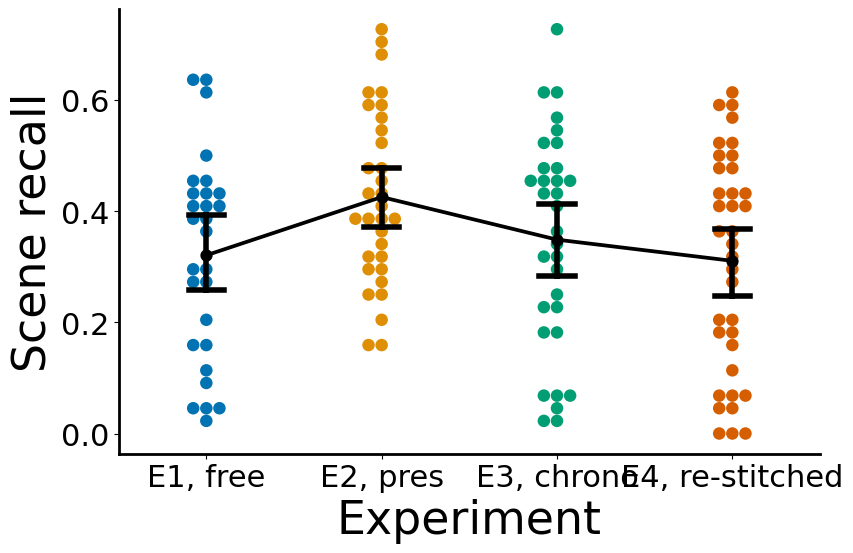

In [57]:
#fix overall results to add dropped participants:
memo1=np.hstack([memo1,1/44])
memo3=np.hstack([memo3,1/44])
memo3=np.hstack([memo3,1/44])
memo4=np.hstack([memo4,0])
memo4=np.hstack([memo4,0])
memo4=np.hstack([memo4,0])

#starting N
print(memo1.shape)
print(memo2.shape)
print(memo3.shape)
print(memo4.shape)

ystr1='Scene recall'
fn='figs/avgmemo_'+str(ystr1)+'.pdf'
barswarm(memo1,memo2,memo3,memo4,ystr1,ystr1,fn,1)

astats3(memo1,memo2,'free vs. pres')
astats3(memo1,memo3,'free vs. chrono')
astats3(memo2,memo3,'pres vs. chrono')
astats3(memo1,memo4,'free vs. re-stitched')
astats3(memo2,memo4,'pres vs. re-stitched')

(122, 5)
(122, 44)
pres order, exp 1-3: PearsonRResult(statistic=-0.00959272574310266, pvalue=0.9301472825799246)
pres order, exp 2 only: PearsonRResult(statistic=0.1132649521566394, pvalue=0.5370876779912854)
chrono order, exp 1-3: PearsonRResult(statistic=0.4647758570135472, pvalue=6.537503230693243e-06)
caus order, exp 1-3: PearsonRResult(statistic=0.43138915658556237, pvalue=3.371704463641952e-05)
top caus order, exp 1-3: PearsonRResult(statistic=0.4370306408847888, pvalue=2.5861181683906647e-05)
proportion of causal being best match, exp 1-3: PearsonRResult(statistic=0.19062307091136665, pvalue=0.07873782747393561)
Scene recall -0.00959272574310266 0.9301472825799246 0.15367013776445032 0.15776427651613095
Scene recall 0.4647758570135472 6.537503230693243e-06 0.50742933913377 6.155089301539024e-07
Scene recall 0.43138915658556237 3.371704463641952e-05 0.45988209576610023 8.405592340691027e-06
Scene recall 0.4370306408847888 2.5861181683906647e-05 0.4556477154903532 1.0415316949701

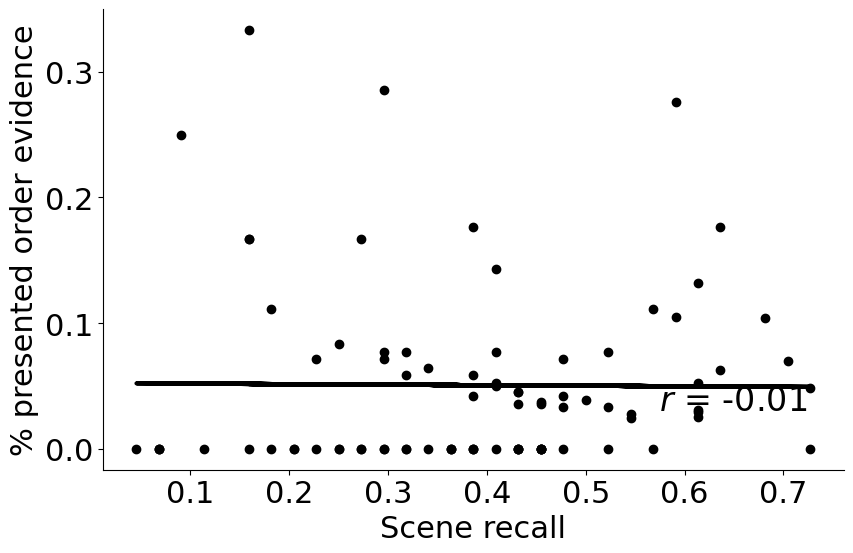

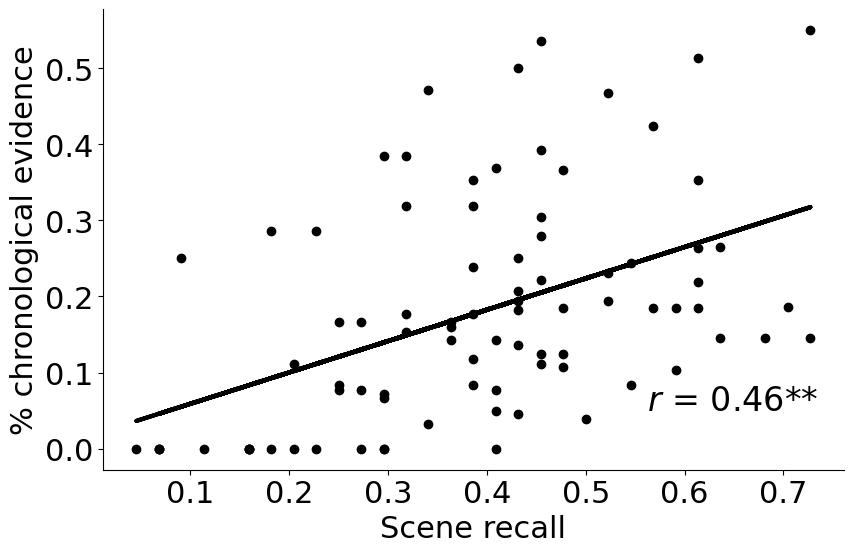

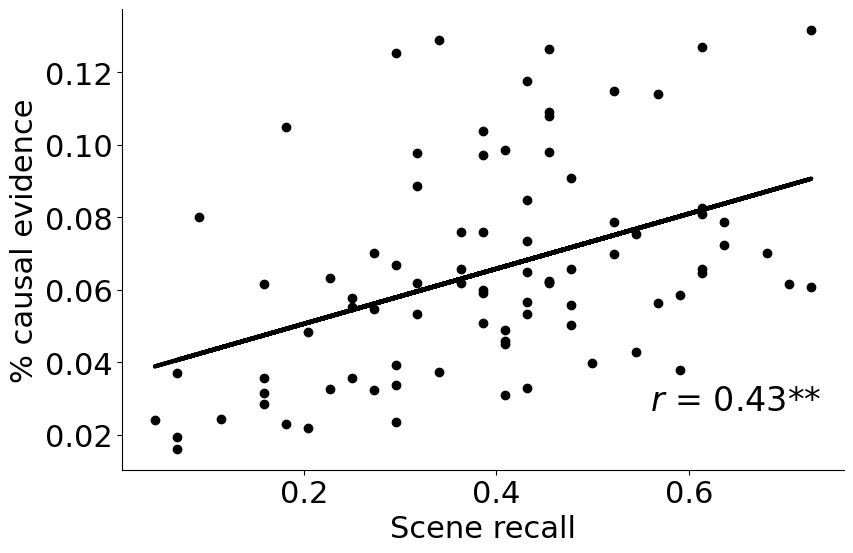

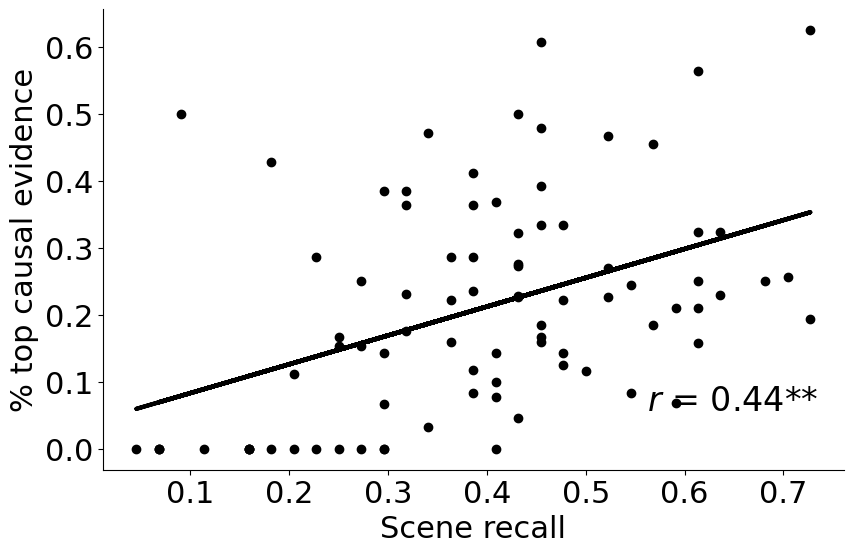

In [58]:
#which strategy uses correlate best with overall recall?
print(evs_cumu_a.shape)
print(memo.shape)
qq=np.where(np.logical_and(conds<4,~np.isnan(evs_cumu_a[:,0])))[0]
z1_3=pearsonr(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,0])
print('pres order, exp 1-3:',z1_3)
qq=np.where(np.logical_and(conds==2,~np.isnan(evs_cumu_a[:,0])))[0]
z2=pearsonr(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,0])
print('pres order, exp 2 only:',z2)
qq=np.where(np.logical_and(conds<4,~np.isnan(evs_cumu_a[:,0])))[0]
z1_3_chrono=pearsonr(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,2])
print('chrono order, exp 1-3:',z1_3_chrono)
z1_3_caus=pearsonr(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,3])
print('caus order, exp 1-3:',z1_3_caus)
z1_3_caus=pearsonr(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,4])
print('top caus order, exp 1-3:',z1_3_caus)
z1_3_caus_best_match=pearsonr(np.mean(memo[qq,:],axis=1),strat_mat[qq,3])
print('proportion of causal being best match, exp 1-3:',z1_3_caus_best_match)
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,0],'Scene recall','% presented order evidence',figf+'xsub_scene_memorability_presord_ev_scat.pdf')
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,2],'Scene recall','% chronological evidence',figf+'xsub_scene_memorability_chrono_ev_scat.pdf')
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,3],'Scene recall','% causal evidence',figf+'xsub_scene_memorability_caus_ev_scat.pdf')
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,4],'Scene recall','% top causal evidence',figf+'xsub_scene_memorability_caus_ev_scat.pdf')

Scene recall -0.1916725432988749 0.3586981828328652 0.12193690236320981 0.5614799855954702
Scene recall 0.43199660133372675 0.031044864978921165 0.4150693890996635 0.03909085219569875
Scene recall 0.44631882384085786 0.025324773654457837 0.3663723338530213 0.07165524375018877
Scene recall 0.1132649521566394 0.5370876779912854 0.2027155266345079 0.26583292035497447
Scene recall 0.5687072158433544 0.0006833009381534256 0.6428651679144606 7.253824009926266e-05
Scene recall 0.3526834983966842 0.04772146717639539 0.3548747271152388 0.04626070095698218
Scene recall -0.09732948374836346 0.6154738782658316 0.008014096471711333 0.9670890838443406
Scene recall 0.7002337895194297 2.349546248135244e-05 0.5971276509799051 0.0006267621234855382
Scene recall 0.640888738196798 0.00017995993942229594 0.5652568699189929 0.0013974581459329622


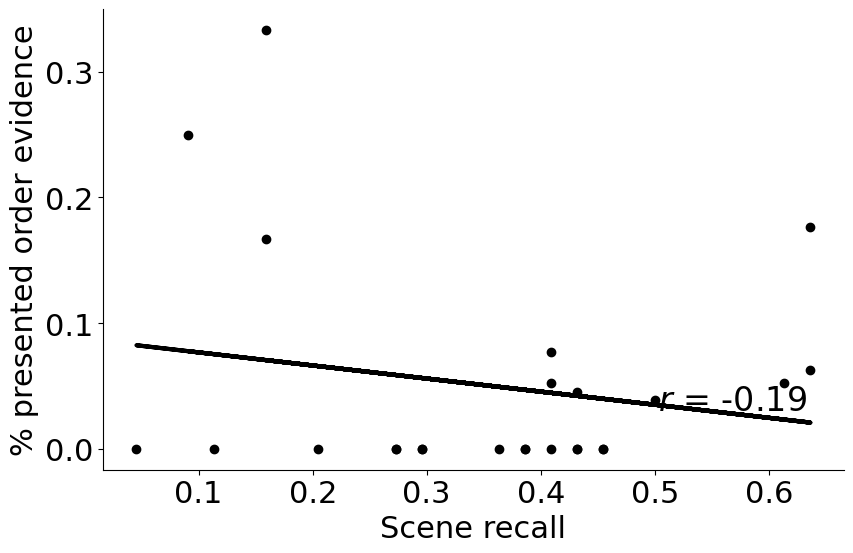

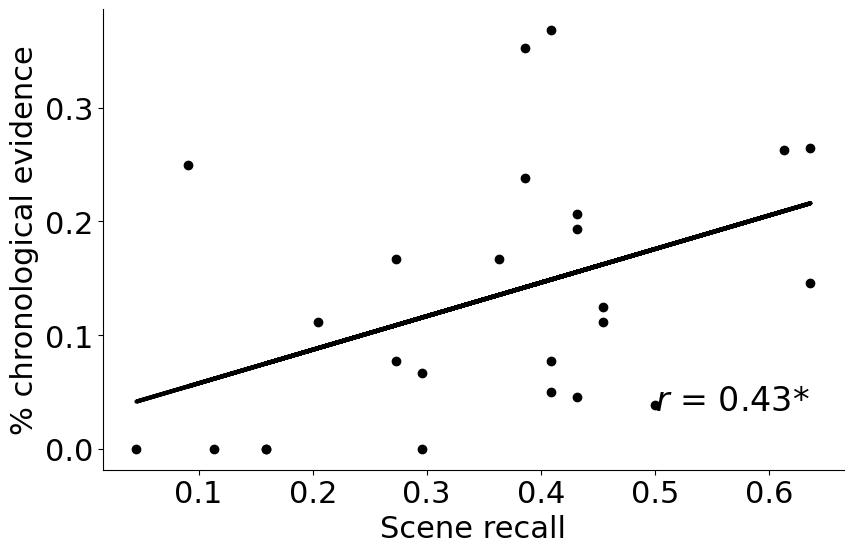

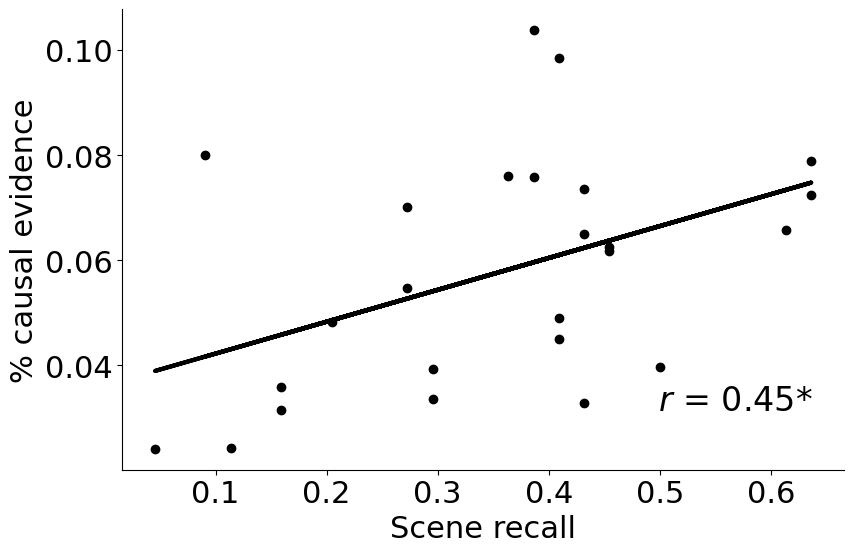

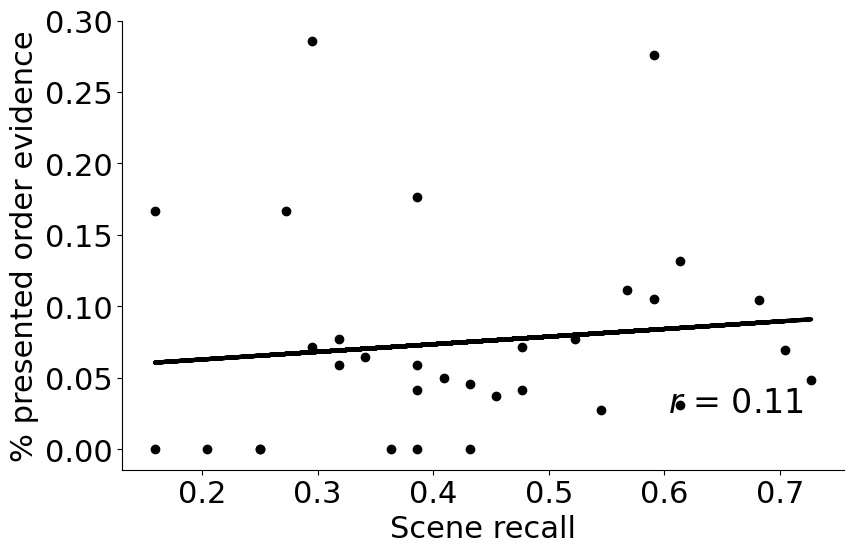

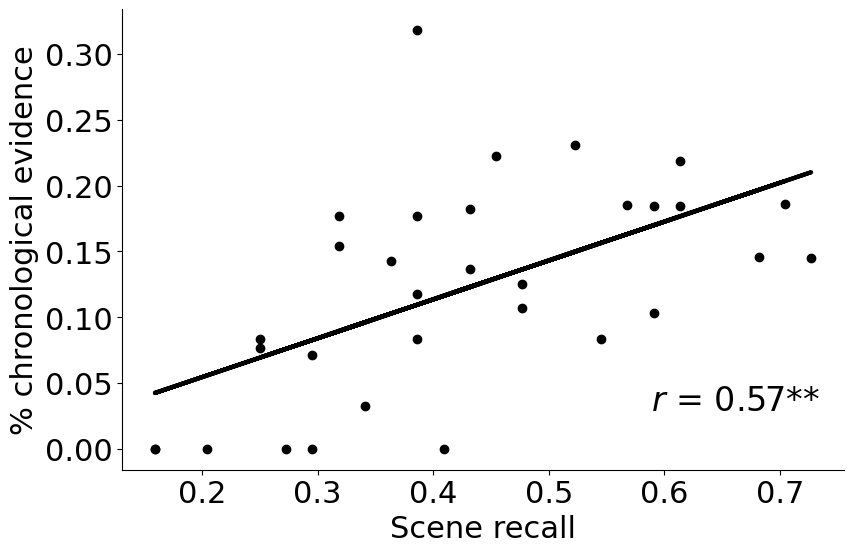

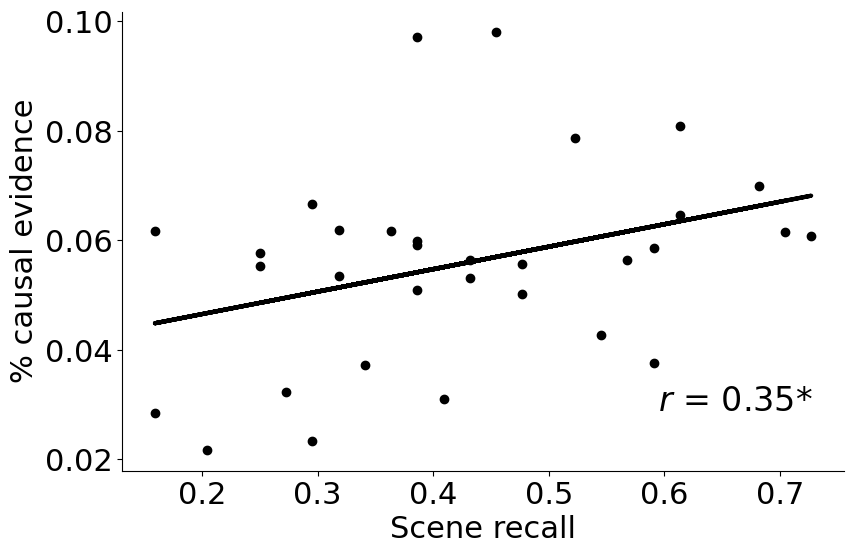

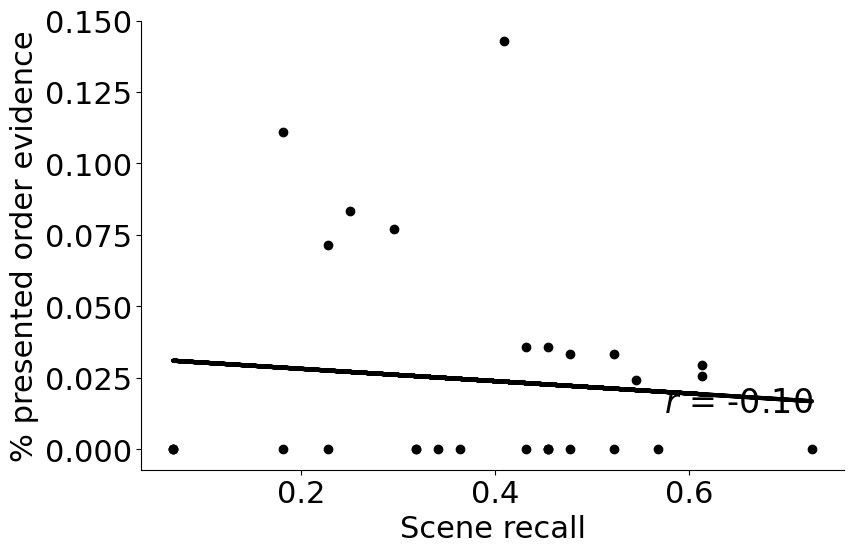

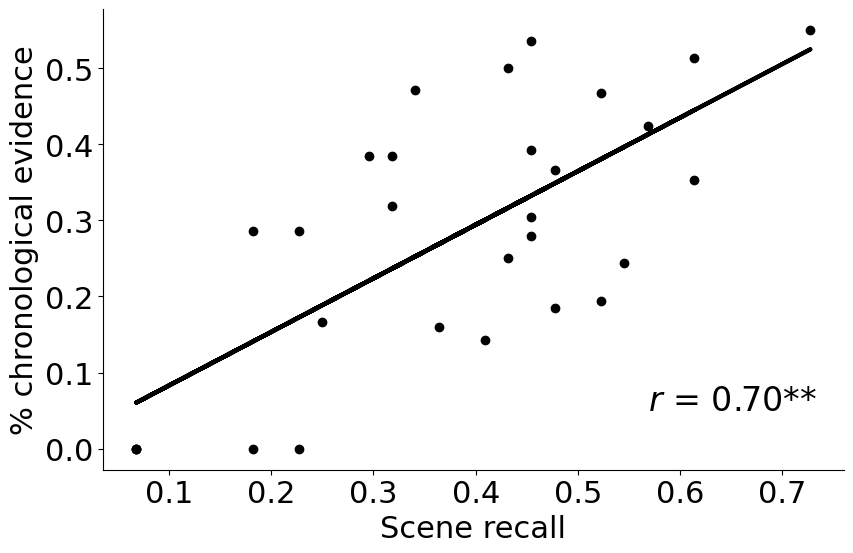

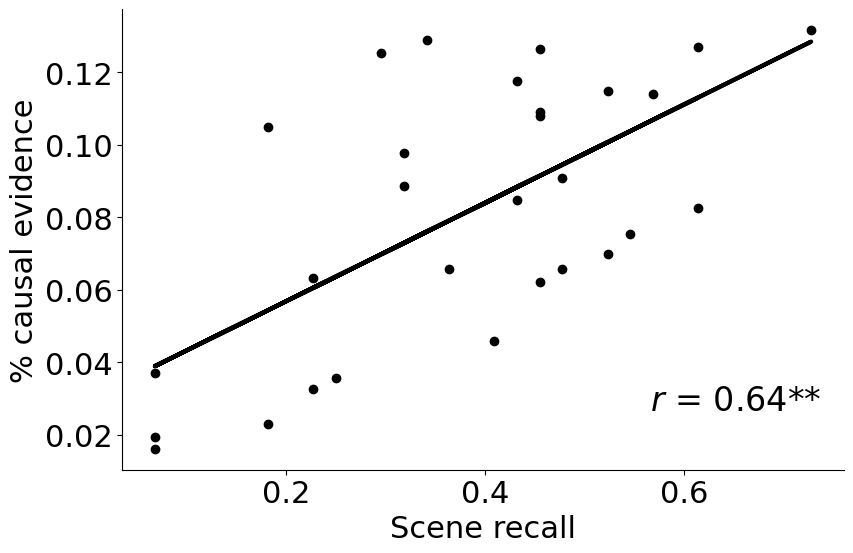

In [59]:
#broken down by experiment
qq=np.where(np.logical_and(conds==1,~np.isnan(evs_cumu_a[:,0])))[0]
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,0],'Scene recall','% presented order evidence',figf+'xsubE1_scene_memorability_presord_ev_scat.pdf')
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,2],'Scene recall','% chronological evidence',figf+'xsubE1_scene_memorability_chrono_ev_scat.pdf')
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,3],'Scene recall','% causal evidence',figf+'xsub_sceneE1_memorability_caus_ev_scat.pdf')
qq=np.where(np.logical_and(conds==2,~np.isnan(evs_cumu_a[:,0])))[0]
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,0],'Scene recall','% presented order evidence',figf+'xsubE2_scene_memorability_presord_ev_scat.pdf')
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,2],'Scene recall','% chronological evidence',figf+'xsubE2_scene_memorability_chrono_ev_scat.pdf')
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,3],'Scene recall','% causal evidence',figf+'xsub_sceneE2_memorability_caus_ev_scat.pdf')
qq=np.where(np.logical_and(conds==3,~np.isnan(evs_cumu_a[:,0])))[0]
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,0],'Scene recall','% presented order evidence',figf+'xsubE3_scene_memorability_presord_ev_scat.pdf')
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,2],'Scene recall','% chronological evidence',figf+'xsubE3_scene_memorability_chrono_ev_scat.pdf')
quicksp(np.mean(memo[qq,:],axis=1),evs_cumu_a[qq,3],'Scene recall','% causal evidence',figf+'xsub_sceneE3_memorability_caus_ev_scat.pdf')

opening, pres vs. free
   g1n    g1m   g1s  g1med  g2n    g2m    g2s   g2med  df  tstat     p      d  \
0   32  0.477  0.03    0.5   27  0.347  0.039  0.3125  57  2.647  0.01  0.704   

     lb    ub  
0  0.03  0.23  


opening, pres vs. chrono
   g1n    g1m   g1s  g1med  g2n    g2m    g2s    g2med  df  tstat      p  \
0   32  0.477  0.03    0.5   30  0.335  0.033  0.34375  60  3.121  0.003   

       d    lb    ub  
0  0.806  0.05  0.23  


opening, pres vs. chrono
   g1n    g1m   g1s  g1med  g2n    g2m    g2s   g2med  df  tstat      p  \
0   32  0.477  0.03    0.5   33  0.354  0.037  0.3125  63  2.506  0.015   

       d    lb    ub  
0  0.632  0.03  0.22  


rest, pres vs. free
   g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med  df  tstat      p  \
0   32  0.396  0.031  0.410714   27  0.323  0.035  0.357143  57  1.552  0.126   

       d    lb    ub  
0  0.413 -0.02  0.17  


rest, pres vs. chrono
   g1n    g1m    g1s     g1med  g2n   g2m    g2s     g2med  df  tstat      p 

g1n    g1m    g1s     g1med  g2n   g2m   g2s     g2med  df  tstat      p  \
0   32  0.396  0.031  0.410714   33  0.33  0.03  0.357143  63    1.5  0.139   

       d    lb    ub  
0  0.378 -0.02  0.15

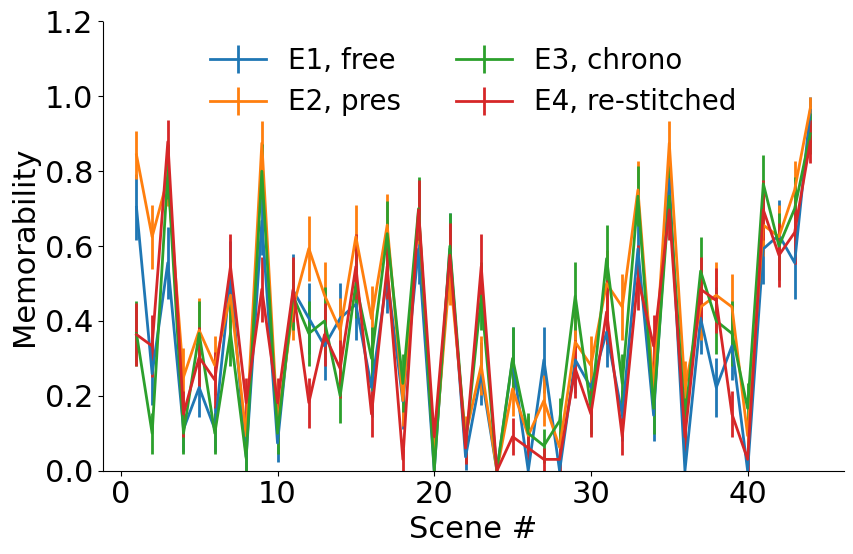

In [60]:
#memorability by experiment
f, ax = plt.subplots(1,1,figsize = (9,6))
x=lin_ev+0#np.linspace(1,int(las),int(las))
x=x.astype(int)
op_len=16 #opening length
for i in range(4):
    qq=np.where(conds==i+1)[0]
    y=np.mean(memo[qq,:],axis=0) #find memorability
    if i==0:
      mem_op1=np.mean(memo[qq,:op_len],axis=1)
      mem_rest1=np.mean(memo[qq,op_len:],axis=1)
    elif i==1:
      mem_op2=np.mean(memo[qq,:op_len],axis=1)
      mem_rest2=np.mean(memo[qq,op_len:],axis=1)
    elif i==2:
      mem_op3=np.mean(memo[qq,:op_len],axis=1)
      mem_rest3=np.mean(memo[qq,op_len:],axis=1)
    elif i==3:
      mem_op4=np.mean(memo[qq,:op_len],axis=1)
      mem_rest4=np.mean(memo[qq,op_len:],axis=1)
    err=np.zeros((n_ev))
    for ii in range(n_ev):
        err[ii]=np.std(memo[qq,ii],axis=0)/np.sqrt(len(qq))
    ax.errorbar(x,y,err,linewidth=lw)
ax.set_xlabel('Scene #')
ax.set_ylabel('Memorability')
ax.set_ylim([0,1.2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(['E1, free','E2, pres','E3, chrono','E4, re-stitched'],loc='upper center',ncol=2,frameon=False,fontsize=20)
f.tight_layout()
fn=figf+'xsub_memorability_by_exp.pdf'
f.savefig(fn, transparent=True)

astats3(mem_op2,mem_op1,'opening, pres vs. free')
astats3(mem_op2,mem_op3,'opening, pres vs. chrono')
astats3(mem_op2,mem_op4,'opening, pres vs. chrono')
astats3(mem_rest2,mem_rest1,'rest, pres vs. free')
astats3(mem_rest2,mem_rest3,'rest, pres vs. chrono')
astats3(mem_rest2,mem_rest4,'rest, pres vs. chrono')

Importance (mean) 0.754127901156804 3.4140130065661564e-09 0.7526944406688512 3.798318940932966e-09
Node degree, semantic network 0.5548685987607215 9.276537701649007e-05 0.673599675909608 5.414775322470342e-07
Node degree, causal network 0.43513680055126003 0.0031581115304859667 0.292966706323699 0.05361198191243284
In-bound weights (sum), causal network 0.48402510905372464 0.0008718184832126218 0.4071710872147921 0.006086414400453574
Out-bound weights (sum), causal network 0.12303051275575906 0.42624851277448433 -0.0834449767963133 0.5902199030395052


Betweenness centrality, semantic network 0.13828719175276188 0.370681371849647 0.3790991317200709 0.011155767329564126
Betweenness centrality, causal network 0.4220010312718381 0.004327315641153689 0.16897586322617197 0.2728602817720838
Eigenvector centrality, causal network 0.4141345072535048 0.0051953424218515116 0.3367293334879933 0.025415708983962955


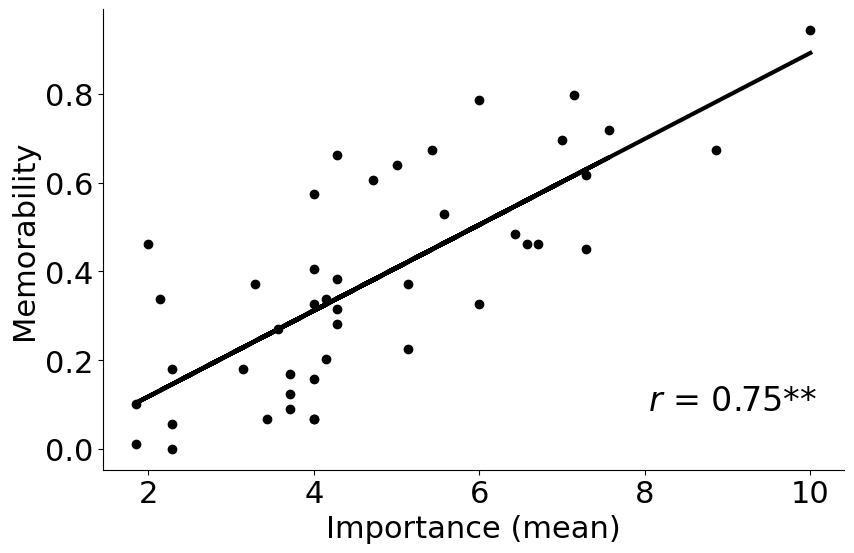

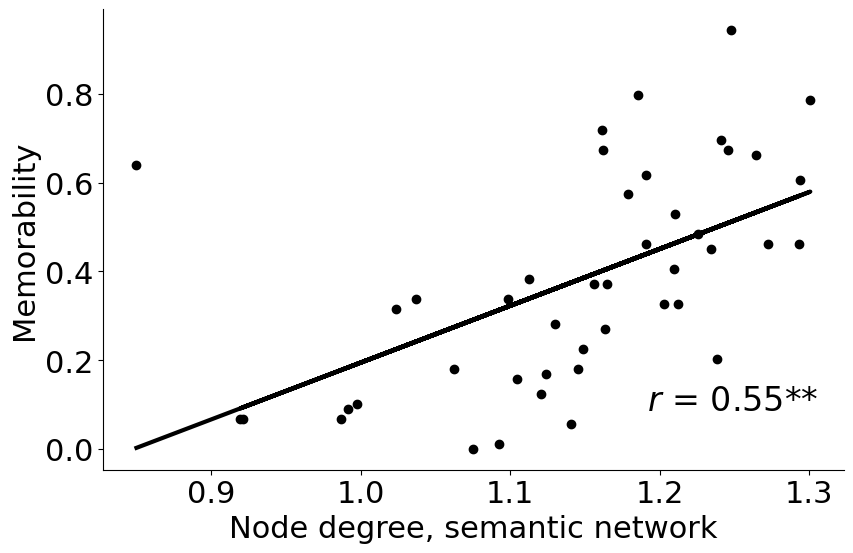

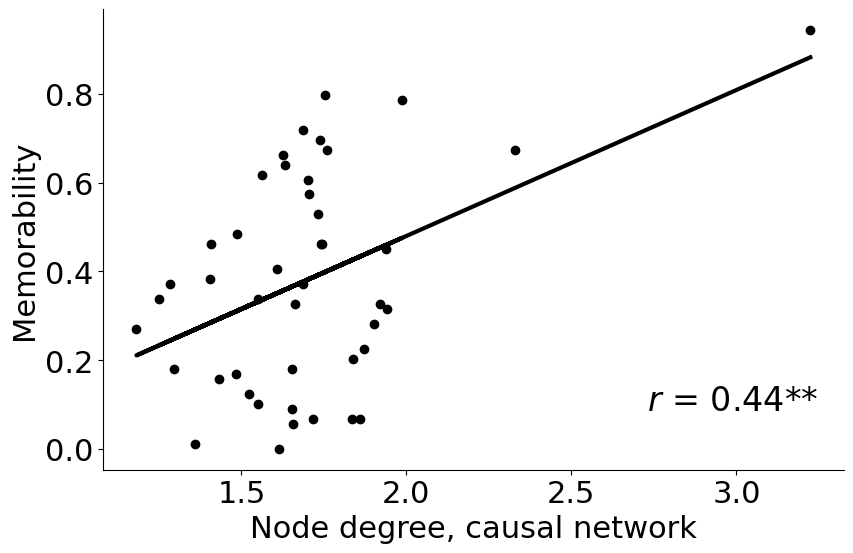

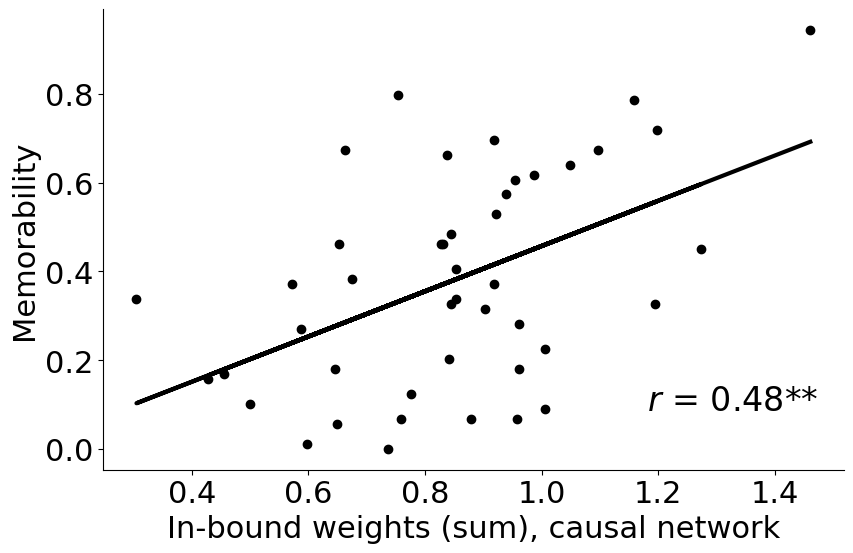

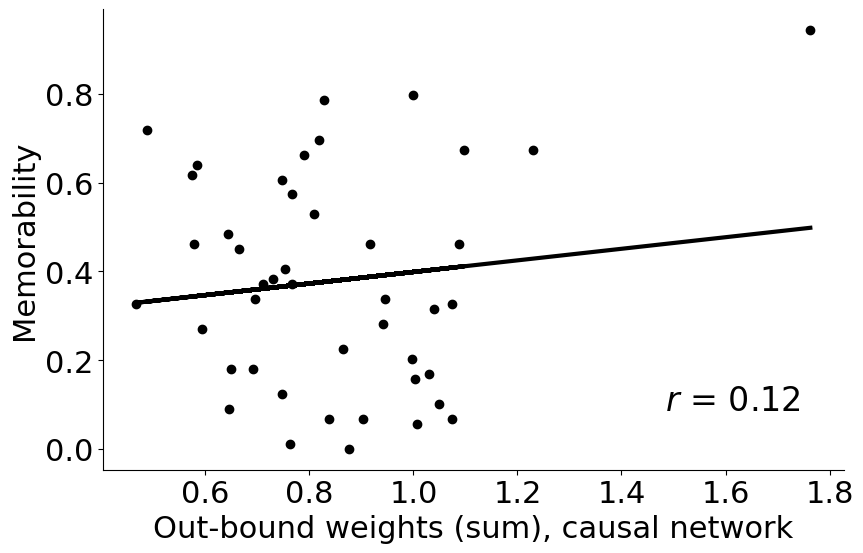

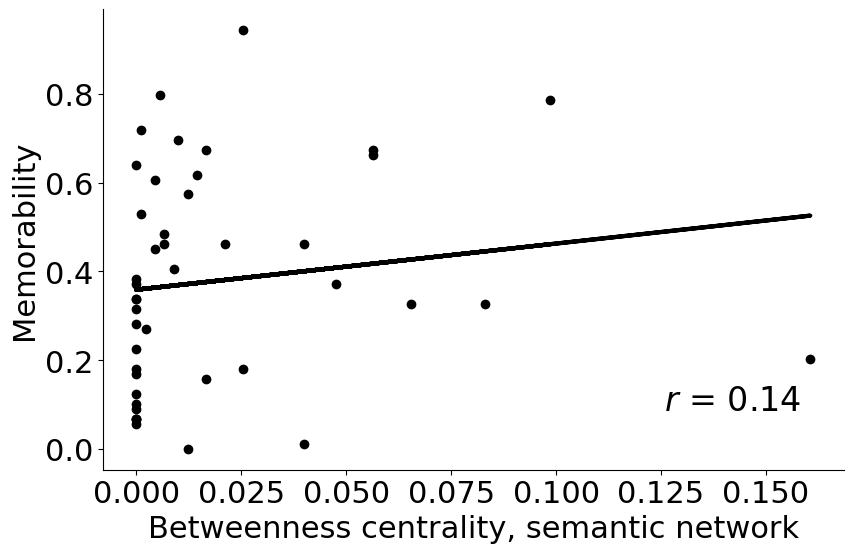

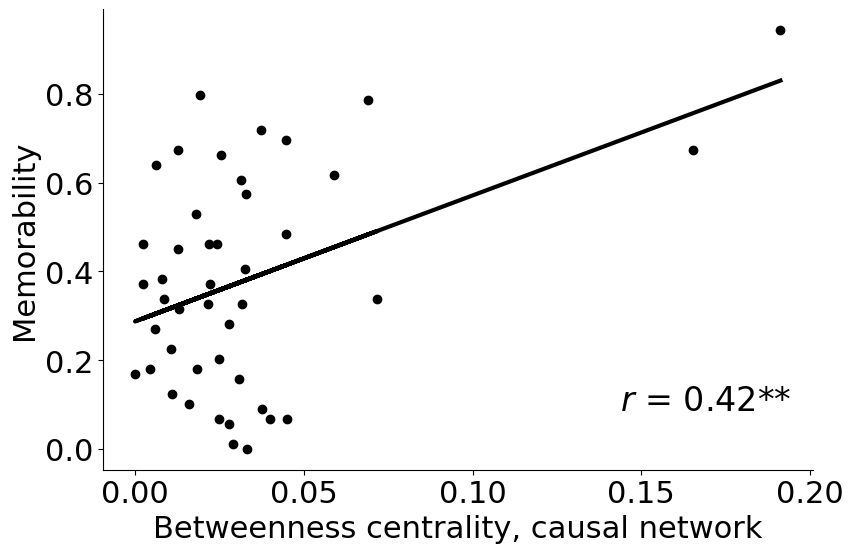

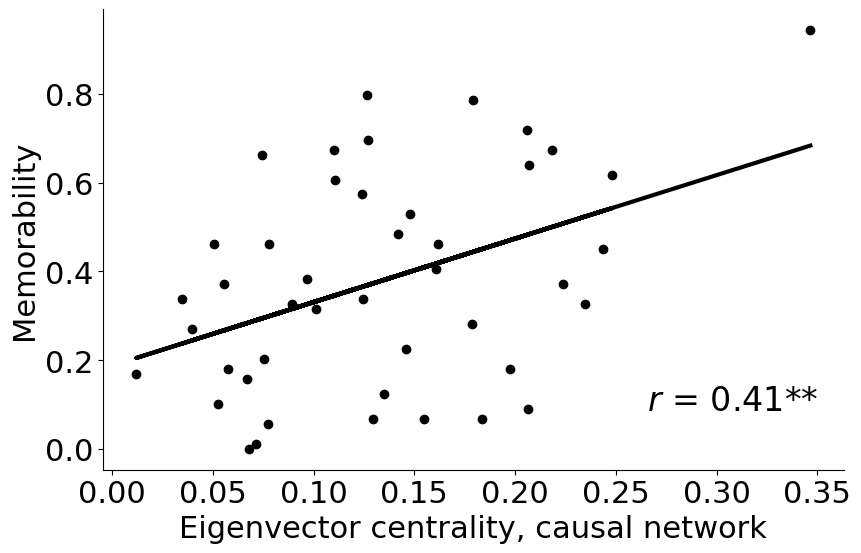

In [61]:
#quick scatterplots (Fig 4B-F)
mem1_3m=np.mean(memo1_3,axis=0)
quicksp(y_imp,mem1_3m,'Importance (mean)','Memorability',figf+'xsub_memorability_imp_scat.pdf')
yl0='''Node degree, semantic network'''
quicksp(y_degw_sem,mem1_3m,yl0,'Memorability',figf+'xsub_memorability_deg_sem_scat.pdf')
quicksp(y_degw,mem1_3m,'Node degree, causal network','Memorability',figf+'xsub_memorability_deg_scat.pdf')
quicksp(y_inw,mem1_3m,'In-bound weights (sum), causal network','Memorability',figf+'xsub_memorability_inw_scat.pdf')
quicksp(y_outw,mem1_3m,'Out-bound weights (sum), causal network','Memorability',figf+'xsub_memorability_outw_scat.pdf')
print('\n')

#other network measurements
yl0='''Betweenness centrality, semantic network'''
quicksp(y_b_cent_sem,mem1_3m,yl0,'Memorability',figf+'xsub_memorability_bcent_sem_scat.pdf')
quicksp(y_b_cent,mem1_3m,'Betweenness centrality, causal network','Memorability',figf+'xsub_memorability_bcent_scat.pdf')
quicksp(y_ev_cent,mem1_3m,'Eigenvector centrality, causal network','Memorability',figf+'xsub_memorability_evcent_scat.pdf')

# Mean strategy analysis (Fig 2)

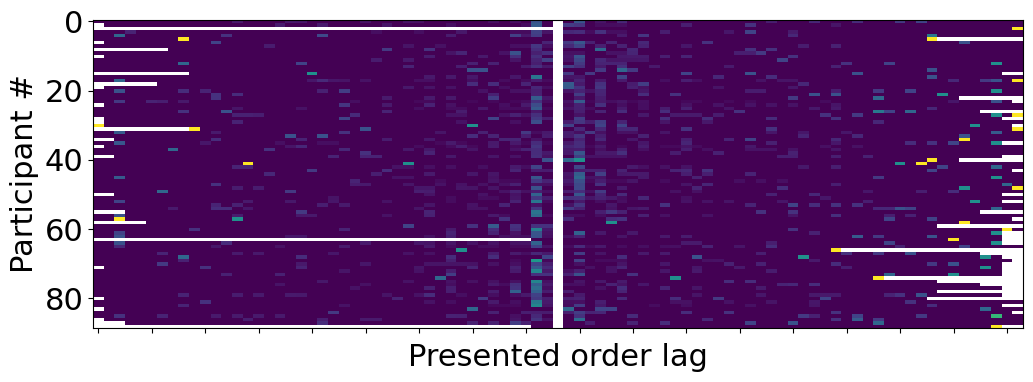

<ipython-input-62-ee4bb2aa3210>:20: RuntimeWarning: Mean of empty slice
  ax.errorbar(js[:-1],np.nanmean(xs_jumps1_3_perc,axis=0),
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


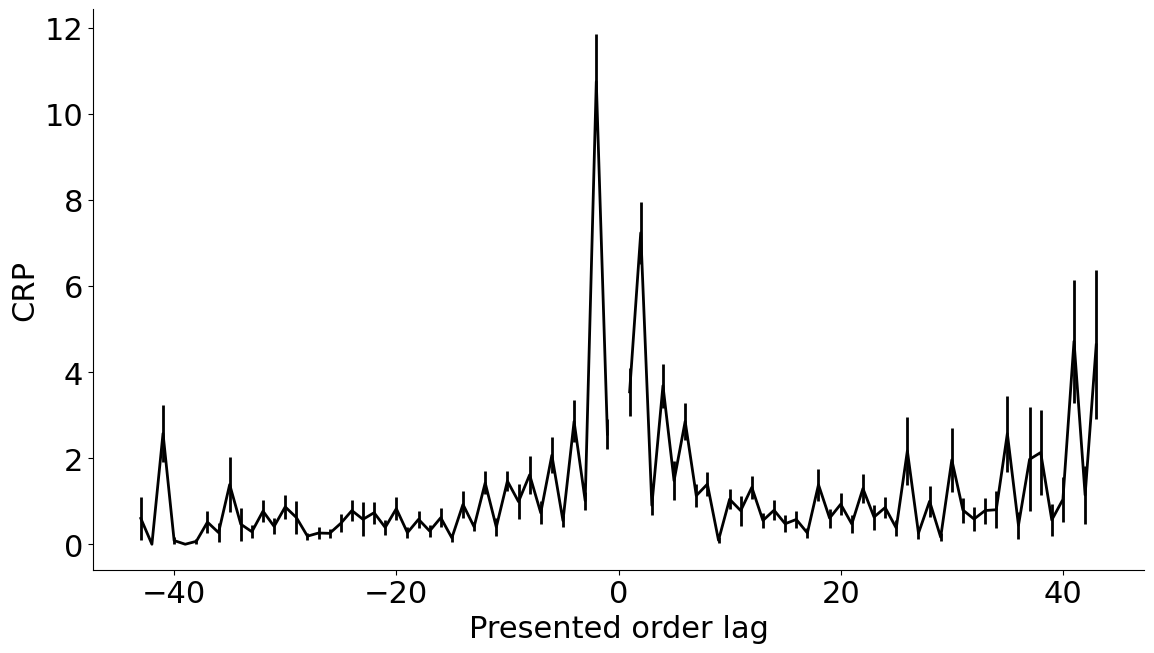

In [62]:
# plot across-participant histograms for presented order
f, ax = plt.subplots(1,1,figsize = (12,4))
ax.imshow(xs_jumps1_3,interpolation='none',cmap='viridis',aspect='auto')
ax.set_xlabel('Presented order lag')
ax.set_ylabel('Participant #')
ax.set_xticks(np.arange(0,maxj*2+1,step=5))
ax.set_xticklabels(js[0:5:-1])
plt.xticks(rotation=90)
plt.show()
f.tight_layout()
fn=figf+'all_sub_narr_jumps.pdf'
f.savefig(fn, transparent=True)

#convert to % / CRP (Fig 2B)
xs_jumps1_3_perc=np.zeros((xs_jumps1_3.shape))
for i in range(xs_jumps1_3.shape[0]):
  xs_jumps1_3_perc[i,:]=np.divide(xs_jumps1_3[i,:]*100,np.nansum(xs_jumps1_3[i,:]))

f, ax = plt.subplots(1,1,figsize = (12,7))
ax.errorbar(js[:-1],np.nanmean(xs_jumps1_3_perc,axis=0),
            np.nanstd(xs_jumps1_3_perc,axis=0)/np.sqrt(subs1_3),color='k',linewidth=lw)
ax.set_xlabel('Presented order lag')
ax.set_ylabel(crp_lab)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.tight_layout()
fn=figf+'xsub_narr_jumps.pdf'
f.savefig(fn, transparent=True)

In [63]:
#look at IDEAL participants
diff_no_i=np.diff(df['BroadSceneNum']) #find presented transitions for ideal presented participant
qq=np.where(diff_no_i!=0)[0]
nzdiff_no_i=diff_no_i[qq]

qq=np.where(np.logical_and(df.StoryOrderSceneNum.isna()==0,df['StoryOrderSceneNum']>0))
allscenes_no_i=df['StoryOrderSceneNum'][qq[0]]
diff_so_i=np.diff(allscenes_no_i) #find CHRONOLOGICAL transitions for ideal presented sub
qq=np.where(diff_so_i!=0)[0]
nzdiff_so_i=diff_so_i[qq]

#find same things for ideal CHRONOLOGICAL participant
df_so=df.sort_values(by=['StoryOrderSceneNum']) #create new dataframe w/ new story order
df_so['new_ind']=np.linspace(0,len(df_so)-1,len(df_so))
df_so = df_so.set_index('new_ind') #create new index so it doesn't stay in the space of the old index

diff_no_i2=np.diff(df_so['BroadSceneNum']) #find NARRATIVE transitions for ideal CHRONOLOGICAL participant
qq=np.where(diff_no_i2!=0)[0]
nzdiff_no_i2=diff_no_i2[qq]

qq=np.where(np.logical_and(df_so.StoryOrderSceneNum.isna()==0,df_so['StoryOrderSceneNum']>0))
allscenes_so_i2=df_so['StoryOrderSceneNum'][qq[0]]
diff_so_i2=np.diff(allscenes_so_i2) #find CHRONOLOGICAL transitions for ideal CHRONOLOGICAL participant
qq=np.where(diff_so_i2!=0)[0]
nzdiff_so_i2=diff_so_i2[qq]

(87,)


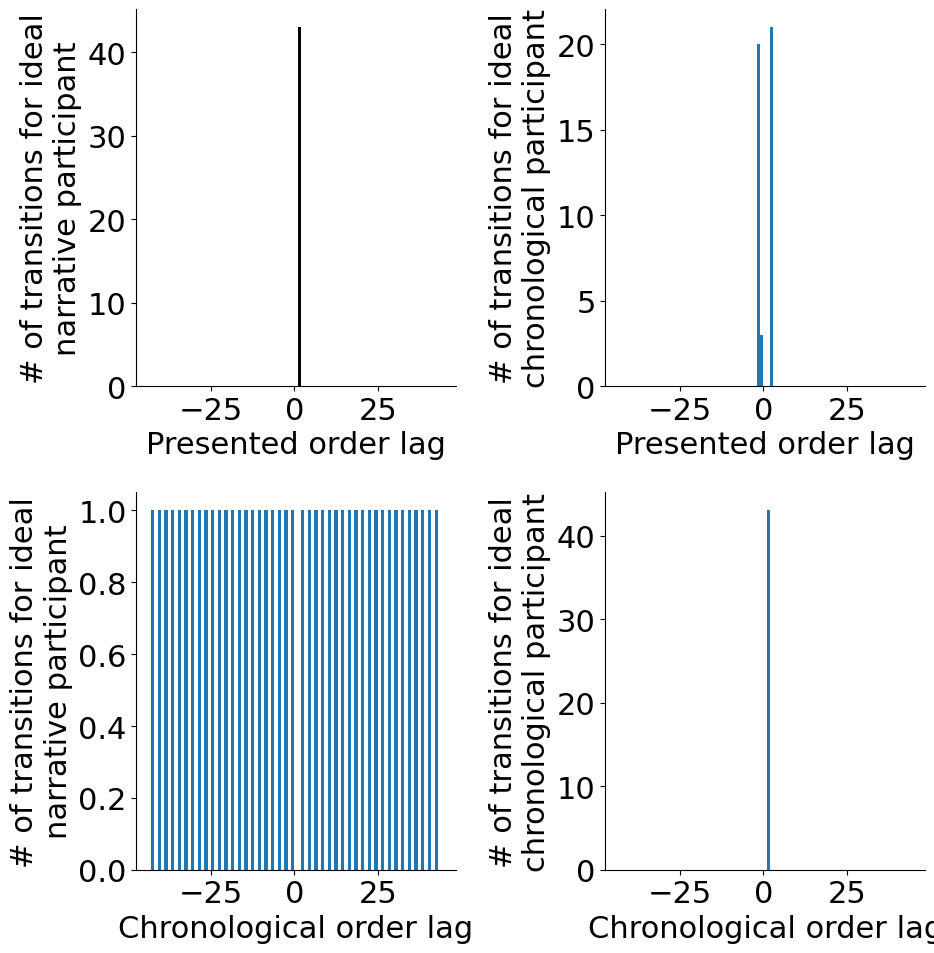

In [64]:
f, ax = plt.subplots(2,2,figsize = (10,10))
ideal_no_no=ax[0,0].hist(nzdiff_no_i,bins=js,color='k')
ideal_no_no[0][n_ev-1]=math.nan
ax[0,0].set_xlabel('Presented order lag')
ax[0,0].set_ylabel('''# of transitions for ideal
narrative participant''')
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

ideal_no_so=ax[1,0].hist(nzdiff_so_i,bins=js)
ax[1,0].set_xlabel('Chronological order lag')
ax[1,0].set_ylabel('''# of transitions for ideal
narrative participant''')
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

ideal_so_no=ax[0,1].hist(nzdiff_no_i2,bins=js)
ideal_so_no[0][n_ev-1]=math.nan
ax[0,1].set_xlabel('Presented order lag')
ax[0,1].set_ylabel('''# of transitions for ideal
chronological participant''')
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)

ideal_so_so=ax[1,1].hist(nzdiff_so_i2,bins=js)
ax[1,1].set_xlabel('Chronological order lag')
ax[1,1].set_ylabel('''# of transitions for ideal
chronological participant''')
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
f.tight_layout()
fn=figf+'all_ideal_subjects.pdf'
f.savefig(fn, transparent=True)

#convert to %s
ideal_no_no=ideal_no_no[0]*100/np.nansum(ideal_no_no[0])
ideal_no_so=ideal_no_so[0]*100/np.nansum(ideal_no_so[0])
ideal_so_no=ideal_so_no[0]*100/np.nansum(ideal_so_no[0])
ideal_so_so=ideal_so_so[0]*100/np.nansum(ideal_so_so[0])
print(ideal_no_no.shape)

<ipython-input-65-5cb8fafb03d8>:42: RuntimeWarning: Mean of empty slice
  x,y,err=js[:-1],np.nanmean(y1,axis=0)*100,np.nanstd(y1,axis=0)*100/np.sqrt(subs1)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[0.         0.         1.57073682 0.         0.         0.
 1.00437908 0.         3.01957108 0.         0.09889319 1.27307801
 0.76081513 1.0928569  1.67384875 0.34259033 0.         0.42899008
 0.52150914 0.81514882 1.30434783 1.23804798 0.0600423  0.75916215
 0.33928037 0.27805919 0.         1.2482364  0.10461141 1.00249724
 0.47671371 1.44611403 0.16092127 1.1719942  0.69082041 1.71004136
 0.3719998  1.7235466  0.77169167 2.20873307 0.81397378 7.25963306
 1.13310844        nan 3.15996011 5.85781272 0.76343426 3.23206594
 0.93174769 1.66339214 0.99114533 0.64364629 0.         1.43394934
 0.18373434 1.54340415 0.32085966 0.57477565 0.3796494  0.29273232
 0.24655534 2.44127893 0.         1.4286166  0.17140665 1.60126037
 0.38187285 0.80616609 0.17581297 1.65266264 0.25099543 1.6858872
 0.12401252 2.23591197 0.69657107 0.96797735 0.7698773  2.08582532
 5.54868466 0.42246914 0.59696691 2.5132765  0.         1.03519669
 9.00727017 1.0429093  8.9606572 ]


<ipython-input-65-5cb8fafb03d8>:79: RuntimeWarning: Mean of empty slice
  y,err=np.nanmean(y2,axis=0)*100,np.nanstd(y2,axis=0)*100/np.sqrt(subs2)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[ 1.83150183  0.          2.00324023  0.23049458  0.          0.18528874
  0.1494264   0.62444396  0.28488137  1.04860186  0.12813869  0.77984389
  0.          0.44282073  0.16089955  0.          0.69986901  0.
  0.5804224   0.26869077  0.41581451  0.84257759  0.80265365  1.08770407
  0.32836902  1.02497045  0.82624448  0.4224155   0.07458538  0.9060107
  0.24559972  1.29654478  0.28396023  0.65688873  0.92347157  2.06185431
  1.15122398  1.59296559  0.41373322  2.34116368  1.71512694  8.07485276
  2.95583401         nan  5.64481221 11.34471571  1.7331257   6.16842808
  1.12343629  4.18923912  1.88511991  2.75886979  0.1735485   0.78616328
  0.68775906  1.86869069  0.29310732  1.25014279  0.47737899  0.67919779
  0.30232239  1.36048389  0.74191651  0.70006154  0.83769577  1.33903822
  0.75154182  0.68851806  0.30276506  1.97619478  0.09947886  0.85983102
  0.2084188   1.0713511   0.          0.          0.25627738  0.
  0.97898122  0.78150373  0.21467529  0.99077871  0.60096154  0.1687

<ipython-input-65-5cb8fafb03d8>:116: RuntimeWarning: Mean of empty slice
  y,err=np.nanmean(y3,axis=0)*100,np.nanstd(y3,axis=0)*100/np.sqrt(subs3)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[ 0.          0.          4.02602074  0.          0.          0.
  0.51354666  0.11612439  1.21241305  0.22318938  0.63418269  0.32238393
  0.57239226  1.14202813  0.2229174   0.26144583  0.          0.38205083
  0.3484296   1.3201749   0.13288082  0.17512303  0.21886713  0.59538899
  0.14157786  0.3438449   0.          0.28616829  0.26654641  0.8781247
  0.51940301  1.55051177  0.7279084   2.61541751  1.31892066  1.03194811
  0.57120137  2.88943259  0.4999694   3.97012837  0.40521986 16.62203735
  3.36618082         nan  1.63769689  4.09096724  0.14585885  1.43878646
  2.34050424  2.50161858  0.44657908  0.62005426  0.08807251  0.97244091
  1.41509709  0.53908002  1.03362482  0.49450581  0.56094631  0.71922566
  0.23296533  0.45466678  1.00789113  0.72633519  0.34846648  0.97002308
  0.72992701  1.06741476  0.63459347  2.83867731  0.43752924  0.50931256
  0.14849981  2.68173857  1.79705904  0.88552942  1.39817504  0.47921149
  1.48086419  0.          5.80551139  3.26735246  1.07662365

<ipython-input-65-5cb8fafb03d8>:164: RuntimeWarning: Mean of empty slice
  y,err=np.nanmean(y4,axis=0)*100,np.nanstd(y4,axis=0)*100/np.sqrt(subs4)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[ 0.37726161  0.          0.54565263  0.          0.          0.
  2.66587316  0.          0.17550275  3.58973965  0.41082668  0.
  0.61693334  0.25294258  0.47755472  0.11305887  0.1760361   0.51860264
  0.          1.01745164  0.          0.26377503  0.18577071  1.09193467
  0.08492068  0.29004596  0.07742768  0.93816693  0.07312614  1.06428443
  0.34713901  1.9226651   0.16695909  1.24995579  1.02620234  4.0541259
  0.17457567  4.04560092  0.38926843  5.74779323  1.91780996 20.11103397
  2.39564202         nan  0.72433338  5.25156593  0.24679121  3.00094326
  0.10751167  3.03054215  2.30521498  1.96046469  2.59376211  0.56373795
  0.16220693  1.41595599  0.6129905   0.43832066  0.          0.86349756
  0.          0.63063141  0.          0.64070479  1.61290323  0.73926873
  0.20154758  0.14817187  0.          0.24835195  0.20317618  3.17462382
  0.21377969  0.70440091  0.37856318  0.45439744  0.55752696  0.93557872
  0.12103638  0.51536175  2.44446176  0.          0.          0.
  5

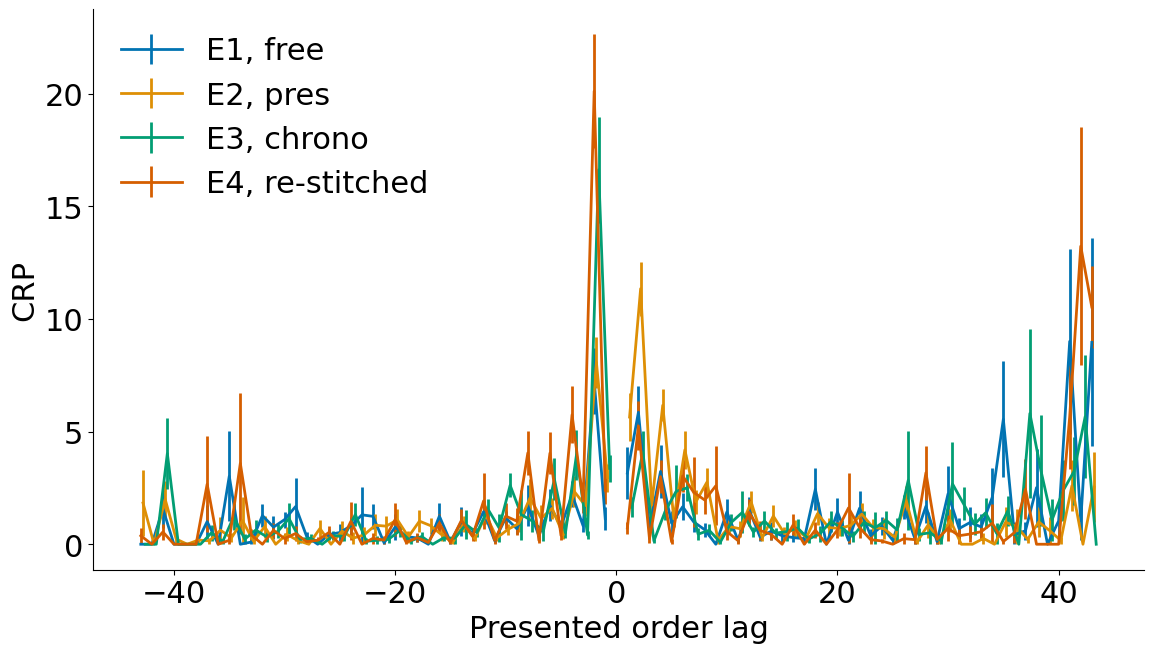

In [65]:
#try partial correlations now - https://pingouin-stats.org/build/html/generated/pingouin.partial_corr.html
meth=1 #1=pearson correlations, 2=partial pearson correlations
pcorr_type=2 #1=only partial out chrono, 2=partial out chrono + sem; with meth=1

#compute plot strategy matches to presented order by condition, all together
palette = sns.color_palette("colorblind")
f, ax = plt.subplots(1,1,figsize = (12,7))
y1=np.zeros((xs_jumps1.shape[0],xs_jumps1.shape[1]))
cs=subs1+0
no_no_ev1,sem_no_ev1,so_no_ev1=np.zeros((cs)),np.zeros((cs)),np.zeros((cs))
caus_no_ev1,caus_no_pcorr_ev1=np.zeros((cs)),np.zeros((cs))
vis_no_ev1,caus_rev_no_ev1,tcaus_no_ev1=np.zeros((cs)),np.zeros((cs)),np.zeros((cs))
for i in range(subs1):
    y1[i,:]=xs_jumps1[i,:]/np.nansum(xs_jumps1[i,:])
    qq=np.where(np.isnan(y1[i,:])==0)[0]
    curr_y=y1[i,qq]
    z1=pearsonr(ideal_no_no[qq],curr_y)
    z2=pearsonr(ideal_sem_no[qq],curr_y)
    z3=pearsonr(ideal_so_no[qq],curr_y)
    z4=pearsonr(ideal_caus_no[qq],curr_y)
    z5=pearsonr(ideal_vis_no[qq],curr_y)
    z6=pearsonr(ideal_caus_rev_no[qq],curr_y)
    z7=pearsonr(ideal_tcaus_no[qq],curr_y)
    data={'ideal_sem_no':ideal_sem_no[qq],'ideal_so_no': ideal_so_no[qq],
            'ideal_caus_no':ideal_caus_no[qq],'y':curr_y}
    df0=pd.DataFrame(data, columns = ['ideal_sem_no','ideal_so_no','ideal_caus_no','y'])
    z4_pcorr=pg.partial_corr(data=df0,x='ideal_caus_no',y='y',covar='ideal_so_no')
    if pcorr_type==2:
      z4_pcorr=pg.partial_corr(data=df0,x='ideal_caus_no',y='y',covar=['ideal_sem_no','ideal_so_no'])
    r1,r2,r3,r4,r5,r6,r7=z1.statistic,z2.statistic,z3.statistic,z4.statistic,z5.statistic,z6.statistic,z6.statistic
    r4_pcorr=z4_pcorr.r

    no_no_ev1[i]=fishr2z(r1).squeeze()
    sem_no_ev1[i]=fishr2z(r2).squeeze()
    so_no_ev1[i]=fishr2z(r3).squeeze()
    caus_no_ev1[i]=fishr2z(r4).squeeze()
    caus_no_pcorr_ev1[i]=fishr2z(r4_pcorr).squeeze()
    vis_no_ev1[i]=fishr2z(r5).squeeze()
    caus_rev_no_ev1[i]=fishr2z(r6).squeeze()
    tcaus_no_ev1[i]=fishr2z(r7).squeeze()

x,y,err=js[:-1],np.nanmean(y1,axis=0)*100,np.nanstd(y1,axis=0)*100/np.sqrt(subs1)
print(y)
ax.errorbar(x,y,err,linewidth=lw,color=palette[0])
y2=np.zeros((xs_jumps2.shape[0],xs_jumps2.shape[1]))
cs=subs2+0
no_no_ev2,sem_no_ev2,so_no_ev2=np.zeros((cs)),np.zeros((cs)),np.zeros((cs))
caus_no_ev2,caus_no_pcorr_ev2=np.zeros((cs)),np.zeros((cs))
vis_no_ev2,caus_rev_no_ev2,tcaus_no_ev2=np.zeros((cs)),np.zeros((cs)),np.zeros((cs))
for i in range(subs2):
    y2[i,:]=xs_jumps2[i,:]/np.nansum(xs_jumps2[i,:])
    qq=np.where(np.isnan(y2[i,:])==0)[0]
    curr_y=y2[i,qq]
    z1=pearsonr(ideal_no_no[qq],curr_y)
    z2=pearsonr(ideal_sem_no[qq],curr_y)
    z3=pearsonr(ideal_so_no[qq],curr_y)
    z4=pearsonr(ideal_caus_no[qq],curr_y)
    z5=pearsonr(ideal_vis_no[qq],curr_y)
    z6=pearsonr(ideal_caus_rev_no[qq],curr_y)
    z7=pearsonr(ideal_tcaus_no[qq],curr_y)
    data={'ideal_sem_no':ideal_sem_no[qq],'ideal_so_no': ideal_so_no[qq],
            'ideal_caus_no':ideal_caus_no[qq],'y':curr_y}
    df0=pd.DataFrame(data, columns = ['ideal_sem_no','ideal_so_no','ideal_caus_no','y'])
    z4_pcorr=pg.partial_corr(data=df0,x='ideal_caus_no',y='y',covar='ideal_so_no')
    if pcorr_type==2:
      z4_pcorr=pg.partial_corr(data=df0,x='ideal_caus_no',y='y',covar=['ideal_sem_no','ideal_so_no'])
    r1,r2,r3,r4,r5,r6,r7=z1.statistic,z2.statistic,z3.statistic,z4.statistic,z5.statistic,z6.statistic,z6.statistic
    r4_pcorr=z4_pcorr.r

    no_no_ev2[i]=fishr2z(r1).squeeze()
    sem_no_ev2[i]=fishr2z(r2).squeeze()
    so_no_ev2[i]=fishr2z(r3).squeeze()
    caus_no_ev2[i]=fishr2z(r4).squeeze()
    caus_no_pcorr_ev2[i]=fishr2z(r4_pcorr).squeeze()
    vis_no_ev2[i]=fishr2z(r5).squeeze()
    caus_rev_no_ev2[i]=fishr2z(r6).squeeze()
    tcaus_no_ev2[i]=fishr2z(r7).squeeze()

y,err=np.nanmean(y2,axis=0)*100,np.nanstd(y2,axis=0)*100/np.sqrt(subs2)
print(y)
ax.errorbar(x+0.2,y,err,linewidth=lw,color=palette[1])
y3=np.zeros((xs_jumps3.shape[0],xs_jumps3.shape[1]))
cs=subs3+0
no_no_ev3,sem_no_ev3,so_no_ev3=np.zeros((cs)),np.zeros((cs)),np.zeros((cs))
caus_no_ev3,caus_no_pcorr_ev3=np.zeros((cs)),np.zeros((cs))
vis_no_ev3,caus_rev_no_ev3,tcaus_no_ev3=np.zeros((cs)),np.zeros((cs)),np.zeros((cs))
for i in range(subs3):
    y3[i,:]=xs_jumps3[i,:]/np.nansum(xs_jumps3[i,:])
    qq=np.where(np.isnan(y3[i,:])==0)[0]
    curr_y=y3[i,qq]
    z1=pearsonr(ideal_no_no[qq],curr_y)
    z2=pearsonr(ideal_sem_no[qq],curr_y)
    z3=pearsonr(ideal_so_no[qq],curr_y)
    z4=pearsonr(ideal_caus_no[qq],curr_y)
    z5=pearsonr(ideal_vis_no[qq],curr_y)
    z6=pearsonr(ideal_caus_rev_no[qq],curr_y)
    z7=pearsonr(ideal_tcaus_no[qq],curr_y)
    data={'ideal_sem_no':ideal_sem_no[qq],'ideal_so_no': ideal_so_no[qq],
            'ideal_caus_no':ideal_caus_no[qq],'y':curr_y}
    df0=pd.DataFrame(data, columns = ['ideal_sem_no','ideal_so_no','ideal_caus_no','y'])
    z4_pcorr=pg.partial_corr(data=df0,x='ideal_caus_no',y='y',covar='ideal_so_no')
    if pcorr_type==2:
      z4_pcorr=pg.partial_corr(data=df0,x='ideal_caus_no',y='y',covar=['ideal_sem_no','ideal_so_no'])
    r1,r2,r3,r4,r5,r6,r7=z1.statistic,z2.statistic,z3.statistic,z4.statistic,z5.statistic,z6.statistic,z6.statistic
    r4_pcorr=z4_pcorr.r

    no_no_ev3[i]=fishr2z(r1).squeeze()
    sem_no_ev3[i]=fishr2z(r2).squeeze()
    so_no_ev3[i]=fishr2z(r3).squeeze()
    caus_no_ev3[i]=fishr2z(r4).squeeze()
    caus_no_pcorr_ev3[i]=fishr2z(r4_pcorr).squeeze()
    vis_no_ev3[i]=fishr2z(r5).squeeze()
    caus_rev_no_ev3[i]=fishr2z(r6).squeeze()
    tcaus_no_ev3[i]=fishr2z(r7).squeeze()

y,err=np.nanmean(y3,axis=0)*100,np.nanstd(y3,axis=0)*100/np.sqrt(subs3)
print(y)
ax.errorbar(x+0.4,y,err,linewidth=lw,color=palette[2])

ax.set_xlabel('Presented order lag')
ax.set_ylabel(crp_lab)
ax.legend(['E1, free','E2, pres','E3, chrono'],loc='upper left',frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.tight_layout()
fn=figf+'xsub_narr_jumps_by_exp.pdf'
f.savefig(fn, transparent=True)

#add exp 4, using the original story order
y4=np.zeros((xs_jumps4.shape[0],xs_jumps4.shape[1]))
cs=subs4+0
no_no_ev4,sem_no_ev4,so_no_ev4=np.zeros((cs)),np.zeros((cs)),np.zeros((cs))
caus_no_ev4,caus_no_pcorr_ev4=np.zeros((cs)),np.zeros((cs))
vis_no_ev4,caus_rev_no_ev4,tcaus_no_ev4=np.zeros((cs)),np.zeros((cs)),np.zeros((cs))
for i in range(subs4):
    y4[i,:]=xs_jumps4[i,:]/np.nansum(xs_jumps4[i,:])
    qq=np.where(np.isnan(y4[i,:])==0)[0]
    curr_y=y4[i,qq]
    z1=pearsonr(ideal_no_no[qq],curr_y)
    z2=pearsonr(ideal_sem_no[qq],curr_y)
    z3=pearsonr(ideal_so_no[qq],curr_y)
    z4=pearsonr(ideal_caus_no[qq],curr_y)
    z5=pearsonr(ideal_vis_no[qq],curr_y)
    z6=pearsonr(ideal_caus_rev_no[qq],curr_y)
    z7=pearsonr(ideal_tcaus_no[qq],curr_y)
    data={'ideal_sem_no':ideal_sem_no[qq],'ideal_so_no': ideal_so_no[qq],
            'ideal_caus_no':ideal_caus_no[qq],'y':curr_y}
    df0=pd.DataFrame(data, columns = ['ideal_sem_no','ideal_so_no','ideal_caus_no','y'])
    z4_pcorr=pg.partial_corr(data=df0,x='ideal_caus_no',y='y',covar='ideal_so_no')
    if pcorr_type==2:
      z4_pcorr=pg.partial_corr(data=df0,x='ideal_caus_no',y='y',covar=['ideal_sem_no','ideal_so_no'])
    r1,r2,r3,r4,r5,r6,r7=z1.statistic,z2.statistic,z3.statistic,z4.statistic,z5.statistic,z6.statistic,z6.statistic
    r4_pcorr=z4_pcorr.r

    no_no_ev4[i]=fishr2z(r1).squeeze()
    sem_no_ev4[i]=fishr2z(r2).squeeze()
    so_no_ev4[i]=fishr2z(r3).squeeze()
    caus_no_ev4[i]=fishr2z(r4).squeeze()
    caus_no_pcorr_ev4[i]=fishr2z(r4_pcorr).squeeze()
    vis_no_ev4[i]=fishr2z(r5).squeeze()
    caus_rev_no_ev4[i]=fishr2z(r6).squeeze()
    tcaus_no_ev4[i]=fishr2z(r7).squeeze()

y,err=np.nanmean(y4,axis=0)*100,np.nanstd(y4,axis=0)*100/np.sqrt(subs4)
print(y)
ax.errorbar(x,y,err,linewidth=lw,color=palette[3])

ax.legend(['E1, free','E2, pres','E3, chrono','E4, re-stitched'],loc='upper left',frameon=False)
f.tight_layout()
fn=figf+'xsub_narr_jumps_by_exp_with_Exp4.pdf'
f.savefig(fn, transparent=True)

<ipython-input-66-e43df90a90cf>:5: RuntimeWarning: Mean of empty slice
  x,y,err=js[:-1],np.nanmean(y1,axis=0)*100,np.nanstd(y1,axis=0)*100/np.sqrt(subs1)
<ipython-input-66-e43df90a90cf>:7: RuntimeWarning: Mean of empty slice
  x,y,err=js[:-1],np.nanmean(y2,axis=0)*100,np.nanstd(y2,axis=0)*100/np.sqrt(subs2)
<ipython-input-66-e43df90a90cf>:9: RuntimeWarning: Mean of empty slice
  x,y,err=js[:-1],np.nanmean(y3,axis=0)*100,np.nanstd(y3,axis=0)*100/np.sqrt(subs3)
<ipython-input-66-e43df90a90cf>:11: RuntimeWarning: Mean of empty slice
  x,y,err=js[:-1],np.nanmean(y4,axis=0)*100,np.nanstd(y4,axis=0)*100/np.sqrt(subs4)
<ipython-input-66-e43df90a90cf>:33: RuntimeWarning: Mean of empty slice
  x,y,err=js[:-1],np.nanmean(y1,axis=0)*100,np.nanstd(y1,axis=0)*100/np.sqrt(subs1)
<ipython-input-66-e43df90a90cf>:35: RuntimeWarning: Mean of empty slice
  x,y,err=js[:-1]+0.2,np.nanmean(y4,axis=0)*100,np.nanstd(y4,axis=0)*100/np.sqrt(subs4)


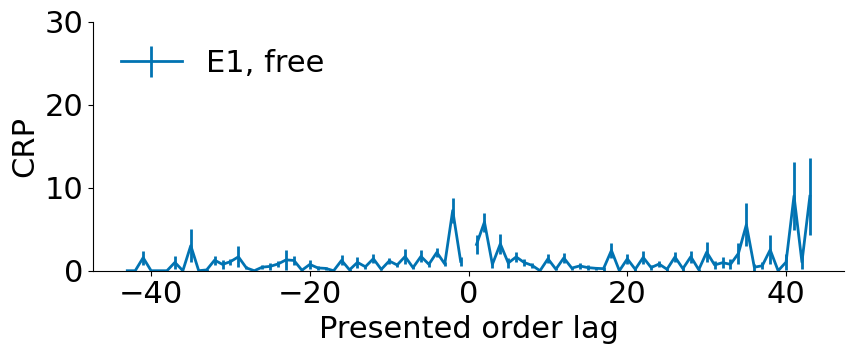

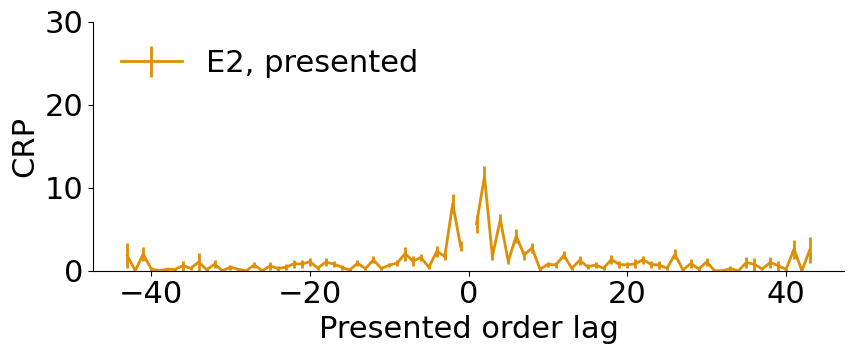

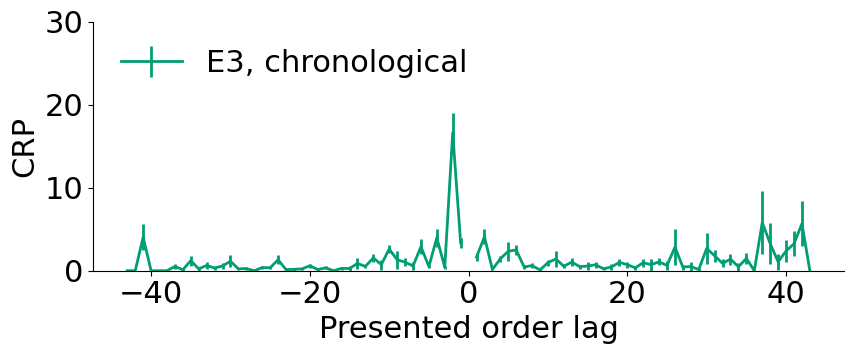

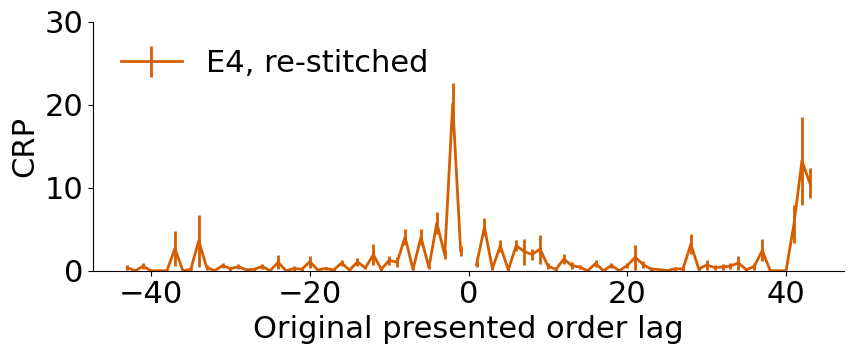

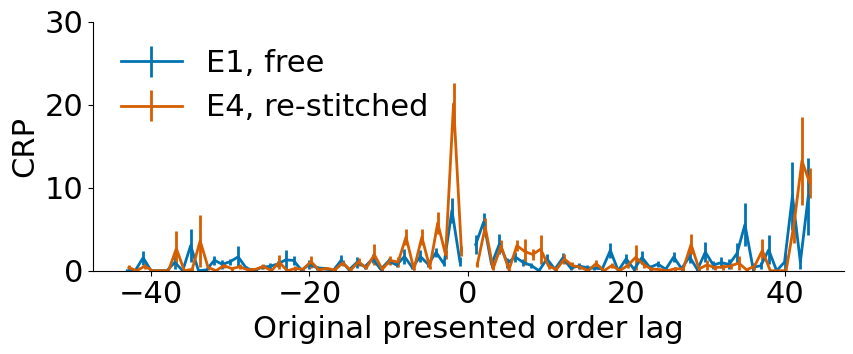

In [66]:
#plot individually - Fig 2B
for i in range(4):
  f, ax = plt.subplots(1,1,figsize = (9,4))
  if i==0:
    x,y,err=js[:-1],np.nanmean(y1,axis=0)*100,np.nanstd(y1,axis=0)*100/np.sqrt(subs1)
  elif i==1:
    x,y,err=js[:-1],np.nanmean(y2,axis=0)*100,np.nanstd(y2,axis=0)*100/np.sqrt(subs2)
  elif i==2:
    x,y,err=js[:-1],np.nanmean(y3,axis=0)*100,np.nanstd(y3,axis=0)*100/np.sqrt(subs3)
  elif i==3:
    x,y,err=js[:-1],np.nanmean(y4,axis=0)*100,np.nanstd(y4,axis=0)*100/np.sqrt(subs4)
  ax.errorbar(x,y,err,linewidth=lw,color=palette[i])
  ax.set_ylim([0,30])
  ax.set_xlabel('Presented order lag')
  ax.set_ylabel(crp_lab)
  if i==0:
    ax.legend(['E1, free'],loc='upper left',frameon=False)
  elif i==1:
    ax.legend(['E2, presented'],loc='upper left',frameon=False)
  elif i==2:
    ax.legend(['E3, chronological'],loc='upper left',frameon=False)
  elif i==3:
    ax.legend(['E4, re-stitched'],loc='upper left',frameon=False)
    ax.set_xlabel('Original presented order lag')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  f.tight_layout()
  fn=figf+'xsub_narr_jumps_by_exp'+str(i+1)+'.pdf'
  f.savefig(fn, transparent=True)

#plot exps 1 & 4 (Fig 5B)
f, ax = plt.subplots(1,1,figsize = (9,4))
x,y,err=js[:-1],np.nanmean(y1,axis=0)*100,np.nanstd(y1,axis=0)*100/np.sqrt(subs1)
ax.errorbar(x,y,err,linewidth=lw,color=palette[0])
x,y,err=js[:-1]+0.2,np.nanmean(y4,axis=0)*100,np.nanstd(y4,axis=0)*100/np.sqrt(subs4)
ax.errorbar(x,y,err,linewidth=lw,color=palette[3])
ax.set_ylim([0,30])
ax.set_ylabel(crp_lab)
ax.legend(['E1, free','E4, re-stitched'],loc='upper left',frameon=False)
ax.set_xlabel('Original presented order lag')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.tight_layout()
fn=figf+'xsub_narr_jumps_by_exp_1v4.pdf'
f.savefig(fn, transparent=True)

<ipython-input-67-320d7d3072f9>:10: RuntimeWarning: invalid value encountered in divide
  y4_noco[i,:]=xs_jumps_noco4[i,:]/np.nansum(xs_jumps_noco4[i,:])
<ipython-input-67-320d7d3072f9>:33: RuntimeWarning: Mean of empty slice
  x,y,err=js[:-1],np.nanmean(y4_noco,axis=0)*100,np.nanstd(y4_noco,axis=0)*100/np.sqrt(subs4)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


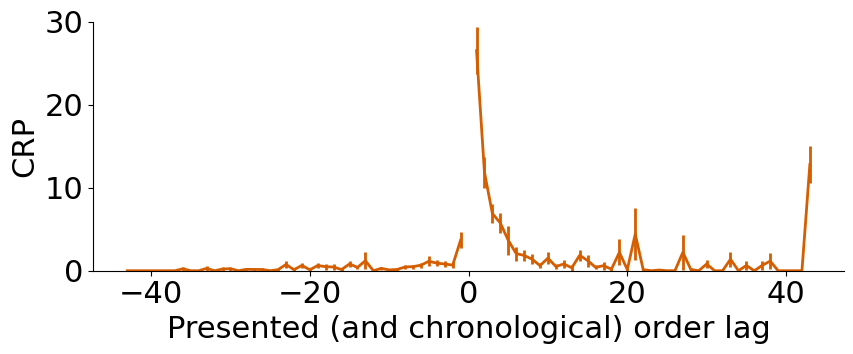

In [67]:
#add special plot for Exp 4 noco aligned!!! - Fig 5A
#plot individually
f, ax = plt.subplots(1,1,figsize = (9,4))
#add exp 4, using the original story order
y4_noco=np.zeros((xs_jumps_noco4.shape[0],xs_jumps_noco4.shape[1]))
cs=subs4+0
no_no_ev4_noco,sem_no_ev4_noco=np.zeros((cs)),np.zeros((cs))
so_no_ev4_noco,caus_no_ev4_noco=np.zeros((cs)),np.zeros((cs))
for i in range(subs4):
    y4_noco[i,:]=xs_jumps_noco4[i,:]/np.nansum(xs_jumps_noco4[i,:])
    qq=np.where(np.isnan(y4_noco[i,:])==0)[0]
    if math.isnan(y4_noco[i,0])==0:
      curr_y=y4_noco[i,qq]
      z1=pearsonr(ideal_no_no[qq],curr_y)
      z2=pearsonr(ideal_sem_no[qq],curr_y)
      z3=pearsonr(ideal_so_no[qq],curr_y)
      z4=pearsonr(ideal_caus_no[qq],curr_y)
      data={'ideal_sem_no':ideal_sem_no[qq],'ideal_so_no': ideal_so_no[qq],
              'ideal_caus_no':ideal_caus_no[qq],'y':curr_y}
      df0=pd.DataFrame(data, columns = ['ideal_sem_no','ideal_so_no','ideal_caus_no','y'])
      r1,r2,r3,r4=z1.statistic,z2.statistic,z3.statistic,z4.statistic

      no_no_ev4_noco[i]=fishr2z(r1).squeeze()
      sem_no_ev4_noco[i]=fishr2z(r2).squeeze()
      so_no_ev4_noco[i]=fishr2z(r3).squeeze()
      caus_no_ev4_noco[i]=fishr2z(r4).squeeze()
    else:
      no_no_ev4_noco[i]=math.nan
      sem_no_ev4_noco[i]=math.nan
      so_no_ev4_noco[i]=math.nan
      caus_no_ev4_noco[i]=math.nan

x,y,err=js[:-1],np.nanmean(y4_noco,axis=0)*100,np.nanstd(y4_noco,axis=0)*100/np.sqrt(subs4)
ax.errorbar(x,y,err,linewidth=lw,color=palette[3])
ax.set_ylim([0,30])
ax.set_xlabel('Presented (and chronological) order lag')
ax.set_ylabel(crp_lab)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.tight_layout()
fn=figf+'xsub_narr_jumps_by_exp4_noco.pdf'
f.savefig(fn, transparent=True)

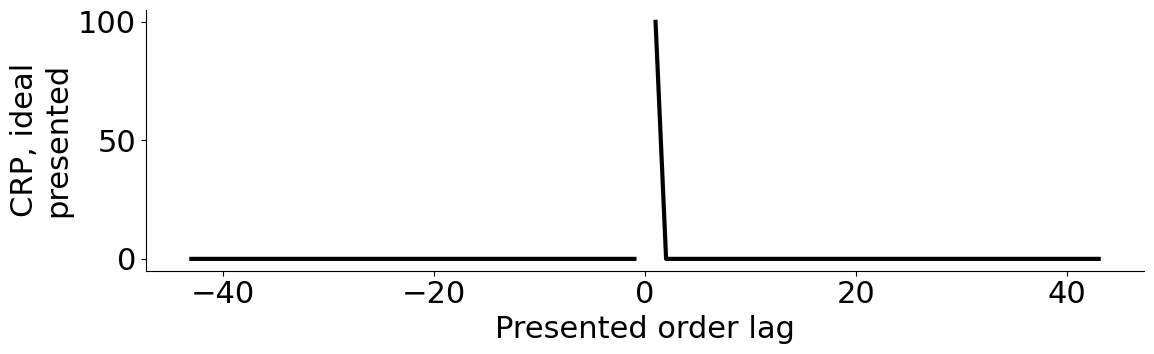

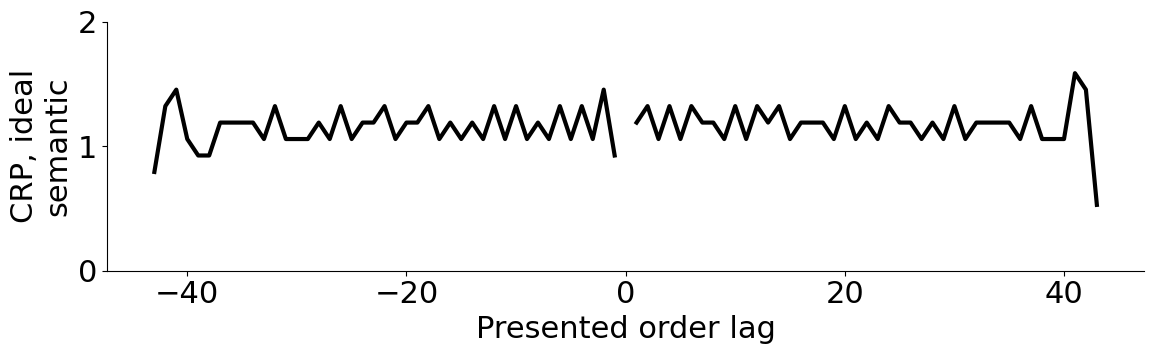

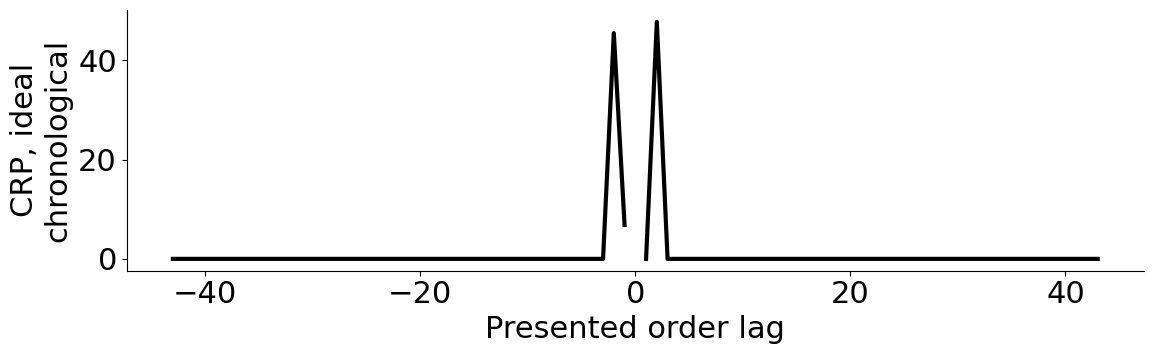

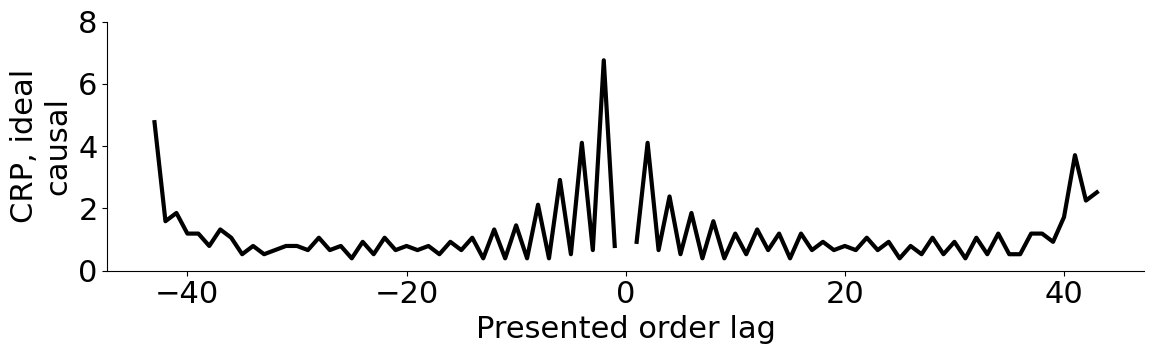

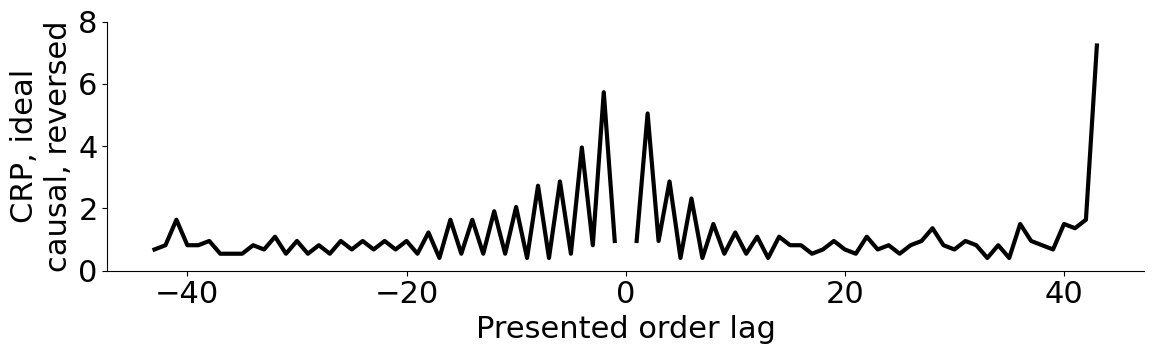

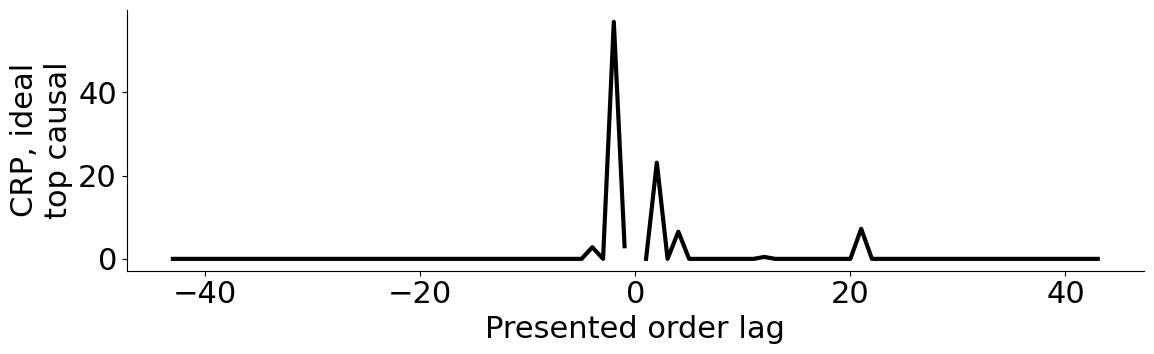

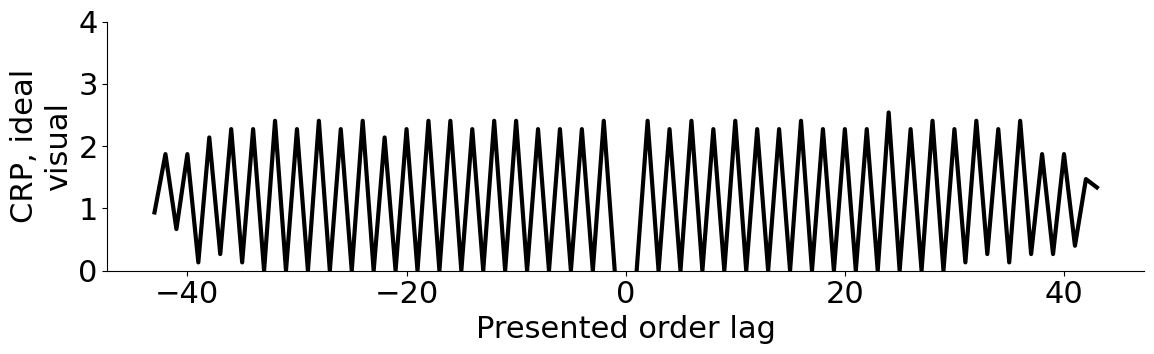

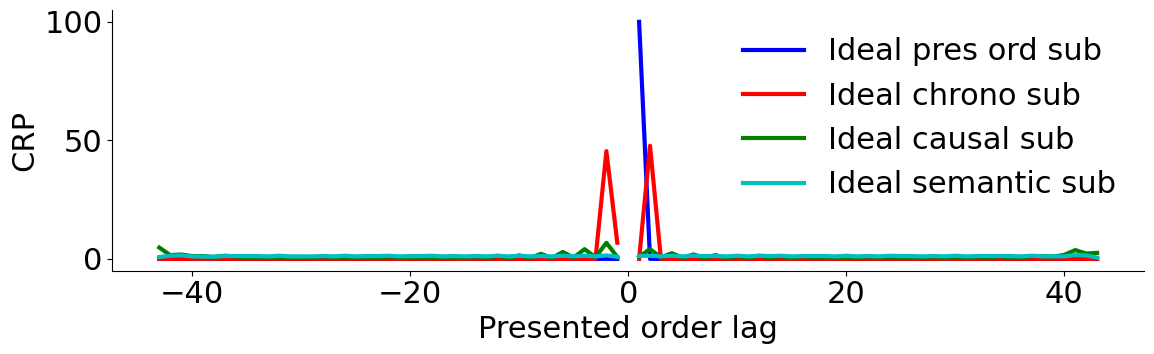

In [68]:
#ideal templates (Fig 2A)
x=js[:-1]
yl0='''CRP, ideal
presented'''
fn0='ideal_narr_sub_narr_jumps'
col0='k'
plot_ideal(ideal_no_no,[],[],[],col0,yl0,fn0,0)

yl0='''CRP, ideal
semantic'''
fn0='ideal_sem_sub_narr_jumps'
plot_ideal(ideal_sem_no,[],[],[],col0,yl0,fn0,0)

yl0='''CRP, ideal
chronological'''
fn0='ideal_chron_sub_narr_jumps'
plot_ideal(ideal_so_no,[],[],[],col0,yl0,fn0,0)

yl0='''CRP, ideal
causal'''
fn0='ideal_caus_sub_narr_jumps'
plot_ideal(ideal_caus_no,[],[],[],col0,yl0,fn0,0)

yl0='''CRP, ideal
causal, reversed'''
fn0='ideal_caus_rev_sub_narr_jumps'
plot_ideal(ideal_caus_rev_no,[],[],[],col0,yl0,fn0,0)

yl0='''CRP, ideal
top causal'''
fn0='ideal_tcaus_sub_narr_jumps'
plot_ideal(ideal_tcaus_no,[],[],[],col0,yl0,fn0,0)

yl0='''CRP, ideal
visual'''
fn0='ideal_vis_sub_narr_jumps'
plot_ideal(ideal_vis_no,[],[],[],col0,yl0,fn0,0)

#all on same plot
fn0='ideal_subs_narr_jumps'
col0='b'
plot_ideal(ideal_no_no,ideal_so_no,ideal_caus_no,ideal_sem_no,col0,crp_lab,fn0,0)

In [69]:
## calculate strategy matches
astats1(caus_no_ev1,0,'causno_ev,group1')
astats1(caus_no_ev2,0,'causno_ev,group2')
astats1(caus_no_ev3,0,'causno_ev,group3')

astats1(no_no_ev1-caus_no_ev1,0,'nonoVcausno_ev,group1')
astats1(no_no_ev2-caus_no_ev2,0,'nonoVcausno_ev,group2')
astats1(no_no_ev3-caus_no_ev3,0,'nonoVcausno_ev,group3')

astats1(sem_no_ev1-caus_no_ev1,0,'semnoVcausno_ev,group1')
astats1(sem_no_ev2-caus_no_ev2,0,'semnoVcausno_ev,group2')
astats1(sem_no_ev3-caus_no_ev3,0,'semnoVcausno_ev,group3')

astats1(caus_no_ev1-vis_no_ev1,0,'visnoVcausno_ev,group1')
astats1(caus_no_ev2-vis_no_ev2,0,'visnoVcausno_ev,group2')
astats1(caus_no_ev3-vis_no_ev3,0,'visnoVcausno_ev,group3')

astats1(caus_no_ev1-caus_rev_no_ev1,0,'causnoVcausrevno_ev,group1')
astats1(caus_no_ev2-caus_rev_no_ev2,0,'causnoVcausrevno_ev,group2')
astats1(caus_no_ev3-caus_rev_no_ev3,0,'causnoVcausrevno_ev,group3')

astats1(caus_no_ev1-tcaus_no_ev1,0,'causnoVtcausno_ev,group1')
astats1(caus_no_ev2-tcaus_no_ev2,0,'causnoVtcausno_ev,group2')
astats1(caus_no_ev3-tcaus_no_ev3,0,'causnoVtcausno_ev,group3')

astats1(so_no_ev1-caus_no_ev1,0,'sonoVcausno_ev,group1')
astats1(so_no_ev2-caus_no_ev2,0,'sonoVcausno_ev,group2')
astats1(so_no_ev3-caus_no_ev3,0,'sonoVcausno_ev,group3')

causno_ev,group1
   meth  g1n    g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   27  0.277  0.039  26  7.045      0  7.045  0.0   1.382  0.304345   

   p_ttest   lb    ub  
0      0.0  0.2  0.36  


causno_ev,group2
   meth  g1n    g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   32  0.382  0.036  31  10.34      0  10.34  0.0   1.857  0.335514   

   p_ttest    lb    ub  
0      0.0  0.31  0.46  


causno_ev,group3
   meth  g1n    g1m    g1s  df  stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   30  0.413  0.052  29  7.84      0   7.84  0.0   1.456  0.414781   

   p_ttest   lb    ub  
0      0.0  0.3  0.52  


nonoVcausno_ev,group1
   meth  g1n    g1m   g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   27 -0.224  0.05  26 -4.419      0 -4.419  0.0  -0.867 -0.286206   

   p_ttest    lb    ub  
0      0.0 -0.33 -0.12  


nonoVcausno_ev,group2
   meth  g1n   g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \


meth  g1n   g1m    g1s  df   stat  zstat  tstat      p  eff_sz     g1med  \
0   0.0   30  0.02  0.034  29  0.582      0  0.582  0.565   0.108  0.011154   

   p_ttest    lb    ub  
0    0.565 -0.05  0.09

In [70]:
#combine all groups
comb=np.hstack([no_no_ev1-caus_no_ev1,no_no_ev2-caus_no_ev2])
comb=np.hstack([comb,no_no_ev3-caus_no_ev3])
astats1(comb,0,'nonoVcausno_ev,all groups')

comb_semvcaus=np.hstack([caus_no_ev1-sem_no_ev1,caus_no_ev2-sem_no_ev2])
comb_semvcaus=np.hstack([comb_semvcaus,caus_no_ev3-sem_no_ev3])
astats1(comb_semvcaus,0,'causnoVsemno_ev,all groups')

comb_visvcaus=np.hstack([caus_no_ev1-vis_no_ev1,caus_no_ev2-vis_no_ev2])
comb_visvcaus=np.hstack([comb_semvcaus,caus_no_ev3-vis_no_ev3])
astats1(comb_visvcaus,0,'causnoVvisno_ev,all groups')

comb=np.hstack([so_no_ev1-caus_no_ev1,so_no_ev2-caus_no_ev2])
comb=np.hstack([comb,so_no_ev3-caus_no_ev3])
astats1(comb,0,'sonoVcausno_ev,all groups')

nonoVcausno_ev,all groups
   meth  g1n    g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   89 -0.281  0.032  88 -8.799      0 -8.799  0.0  -0.938 -0.286206   

   p_ttest    lb    ub  
0      0.0 -0.34 -0.22  


causnoVsemno_ev,all groups
   meth  g1n    g1m    g1s  df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0   89  0.182  0.023  88  7.846      0  7.846  0.0   0.836  0.163196   

   p_ttest    lb    ub  
0      0.0  0.14  0.23  


causnoVvisno_ev,all groups
   meth  g1n    g1m    g1s   df   stat  zstat  tstat    p  eff_sz     g1med  \
0   0.0  119  0.217  0.021  118  10.39      0  10.39  0.0   0.956  0.193448   

   p_ttest    lb    ub  
0      0.0  0.18  0.26  


sonoVcausno_ev,all groups
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz     g1med  \
0   0.0   89  0.044  0.021  88  2.062      0  2.062  0.042    0.22  0.038895   

   p_ttest   lb    ub  
0    0.042  0.0  0.09  




meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz     g1med  \
0   0.0   89  0.044  0.021  88  2.062      0  2.062  0.042    0.22  0.038895   

   p_ttest   lb    ub  
0    0.042  0.0  0.09

<ipython-input-24-ca30e037217c>:210: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],hue=dat['Experiment'],palette=cp,facecolor=None,size=msz,zorder=1)#color=cp
<ipython-input-24-ca30e037217c>:210: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],hue=dat['Experiment'],palette=cp,facecolor=None,size=msz,zorder=1)#color=cp
<ipython-input-24-ca30e037217c>:210: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],hue=dat['Experiment'],palette=cp,facecolor=None,size=msz,zorder=1)#color=cp
<ipython-input-24-ca30e037217c>:210: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],hue=dat['Experiment'],palette=cp,facecolor=N

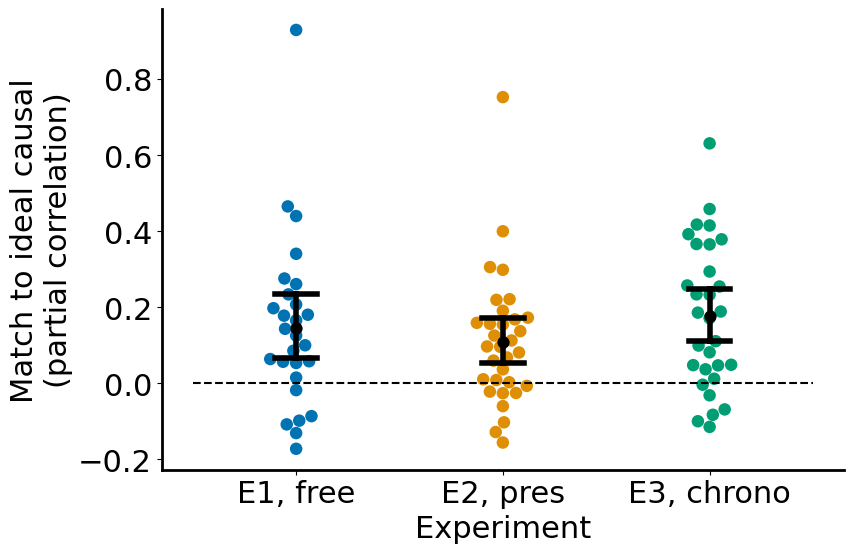

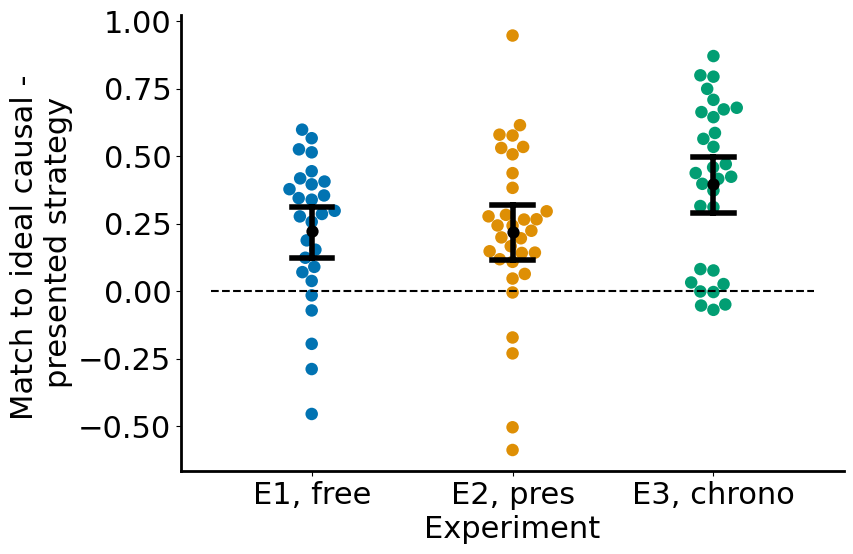

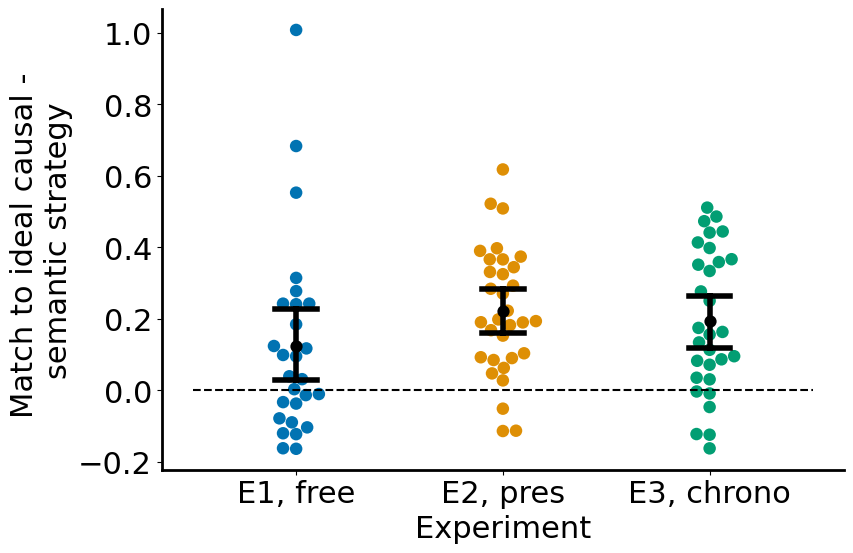

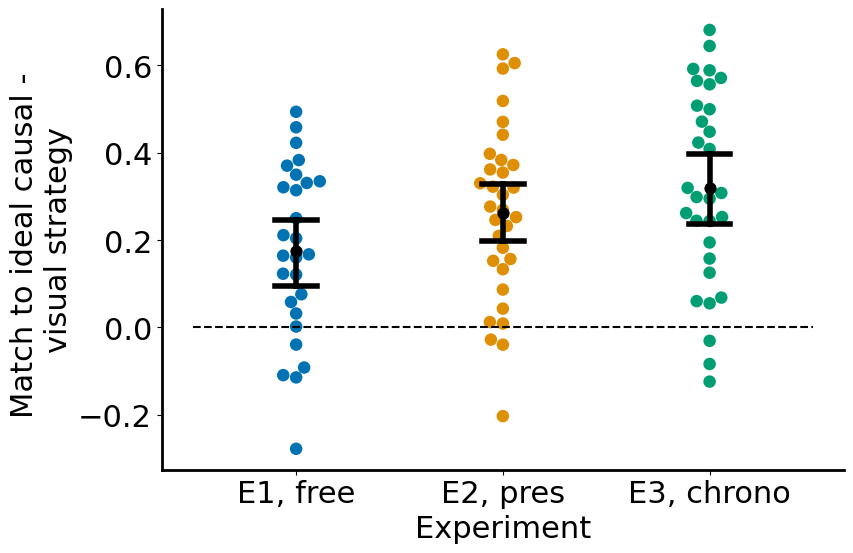

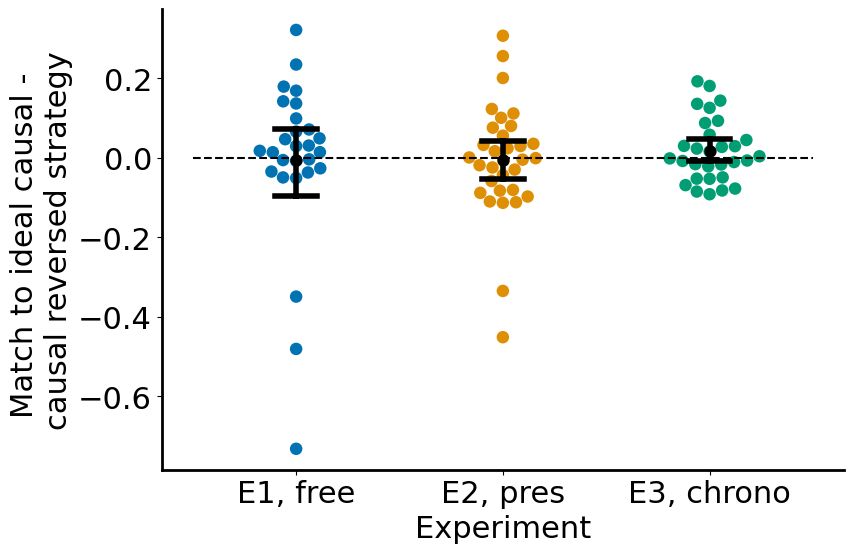

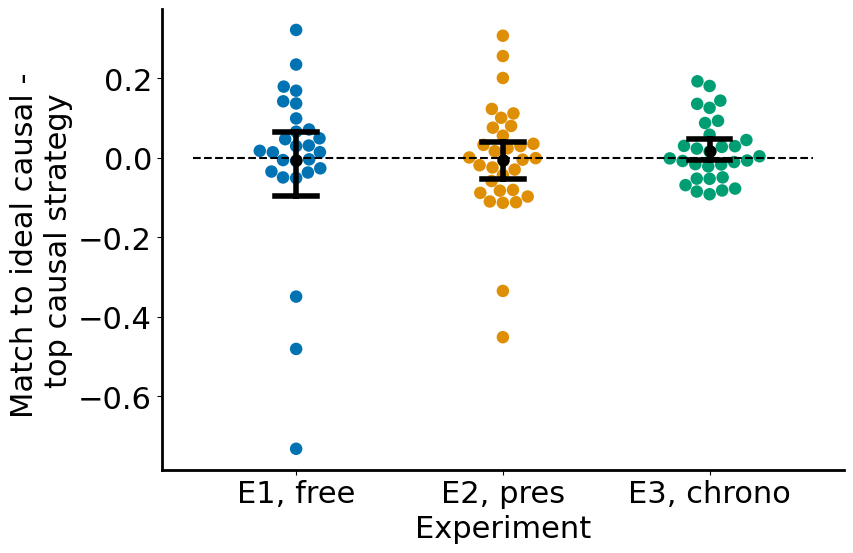

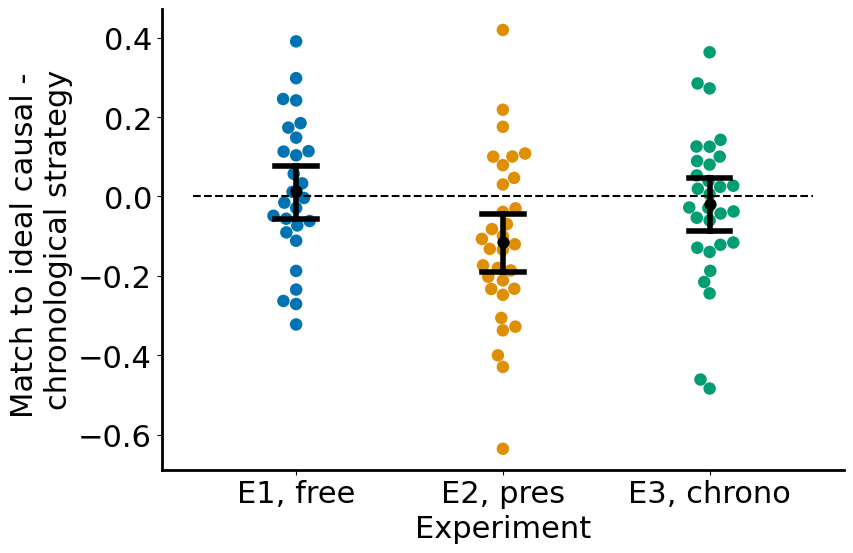

In [71]:
#plot strategy comparisons for Exp 1-3 (Fig 2C)
ystr1='''Match to ideal causal
(partial correlation)'''
fn='figs/idealcausal_pcorr_out_'+str(pcorr_type)+'_narr_order_allexps.pdf'
#barswarm(caus_no_pcorr_ev1,caus_no_pcorr_ev2,caus_no_pcorr_ev3,caus_no_pcorr_ev4,ystr1,ystr1,fn,2)
comb=np.hstack([caus_no_pcorr_ev1,caus_no_pcorr_ev2])
comb=np.hstack([comb,caus_no_pcorr_ev3])
barswarm(caus_no_pcorr_ev1,caus_no_pcorr_ev2,caus_no_pcorr_ev3,[],ystr1,ystr1,fn,6)

ystr1='Match to ideal causal - ' + '\n' + 'presented strategy'
fn='figs/idealnarrVcausal_narr_order_allexps.pdf'
comb=np.hstack([caus_no_ev1-no_no_ev1,caus_no_ev2-no_no_ev2])
comb=np.hstack([comb,caus_no_ev3-no_no_ev3])
barswarm(caus_no_ev1-no_no_ev1,caus_no_ev2-no_no_ev2,caus_no_ev3-no_no_ev3,[],ystr1,ystr1,fn,6)

ystr1='Match to ideal causal - ' + '\n' + 'semantic strategy'
fn='figs/idealsemVcausal_narr_order_allexps.pdf'
comb=np.hstack([caus_no_ev1-sem_no_ev1,caus_no_ev2-sem_no_ev2])
comb=np.hstack([comb,caus_no_ev3-sem_no_ev3])
barswarm(caus_no_ev1-sem_no_ev1,caus_no_ev2-sem_no_ev2,caus_no_ev3-sem_no_ev3,[],ystr1,ystr1,fn,6)

ystr1='Match to ideal causal - ' + '\n' + 'visual strategy'
fn='figs/idealvisVcausal_narr_order_allexps.pdf'
comb=np.hstack([caus_no_ev1-vis_no_ev1,caus_no_ev2-vis_no_ev2])
comb=np.hstack([comb,caus_no_ev3-vis_no_ev3])
barswarm(caus_no_ev1-vis_no_ev1,caus_no_ev2-vis_no_ev2,caus_no_ev3-vis_no_ev3,[],ystr1,ystr1,fn,6)

ystr1='Match to ideal causal - ' + '\n' + 'causal reversed strategy'
fn='figs/idealcausalrevVcausal_narr_order_allexps.pdf'
comb=np.hstack([caus_no_ev1-caus_rev_no_ev1,caus_no_ev2-caus_rev_no_ev2])
comb=np.hstack([comb,caus_no_ev3-caus_rev_no_ev3])
barswarm(caus_no_ev1-caus_rev_no_ev1,caus_no_ev2-caus_rev_no_ev2,caus_no_ev3-caus_rev_no_ev3,[],ystr1,ystr1,fn,6)

ystr1='Match to ideal causal - ' + '\n' + 'top causal strategy'
fn='figs/idealtcausalVcausal_narr_order_allexps.pdf'
comb=np.hstack([caus_no_ev1-tcaus_no_ev1,caus_no_ev2-tcaus_no_ev2])
comb=np.hstack([comb,caus_no_ev3-tcaus_no_ev3])
barswarm(caus_no_ev1-tcaus_no_ev1,caus_no_ev2-tcaus_no_ev2,caus_no_ev3-tcaus_no_ev3,[],ystr1,ystr1,fn,6)

ystr1='Match to ideal causal - ' + '\n' + 'chronological strategy'
fn='figs/idealchronoVcausal_narr_order_allexps.pdf'
comb=np.hstack([caus_no_ev1-so_no_ev1,caus_no_ev2-so_no_ev2])
comb=np.hstack([comb,caus_no_ev3-so_no_ev3])
barswarm(caus_no_ev1-so_no_ev1,caus_no_ev2-so_no_ev2,caus_no_ev3-so_no_ev3,[],ystr1,ystr1,fn,6)

# Compare mean strategy for Exp 1 & Exp 4 (Fig 5)

nono_ev,group1
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz     g1med  \
0   0.0   27  0.053  0.029  26  1.802      0  1.802  0.083   0.353 -0.023814   

   p_ttest    lb    ub  
0    0.083 -0.01  0.11  


nono_ev,group4
   meth  g1n    g1m    g1s  df   stat  zstat  tstat      p  eff_sz     g1med  \
0   0.0   33 -0.012  0.008  32 -1.528      0 -1.528  0.136   -0.27 -0.029481   

   p_ttest    lb   ub  
0    0.136 -0.03  0.0  


nonoVnono_ev,group1V4
   g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med  df  tstat      p  \
0   27  0.053  0.029 -0.023814   33 -0.012  0.008 -0.029481  58  2.328  0.023   

       d   lb    ub  
0  0.615  0.0  0.13  




<ipython-input-24-ca30e037217c>:210: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax=sns.swarmplot(x=dat['Experiment'],y=dat[lab],hue=dat['Experiment'],palette=cp,facecolor=None,size=msz,zorder=1)#color=cp
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


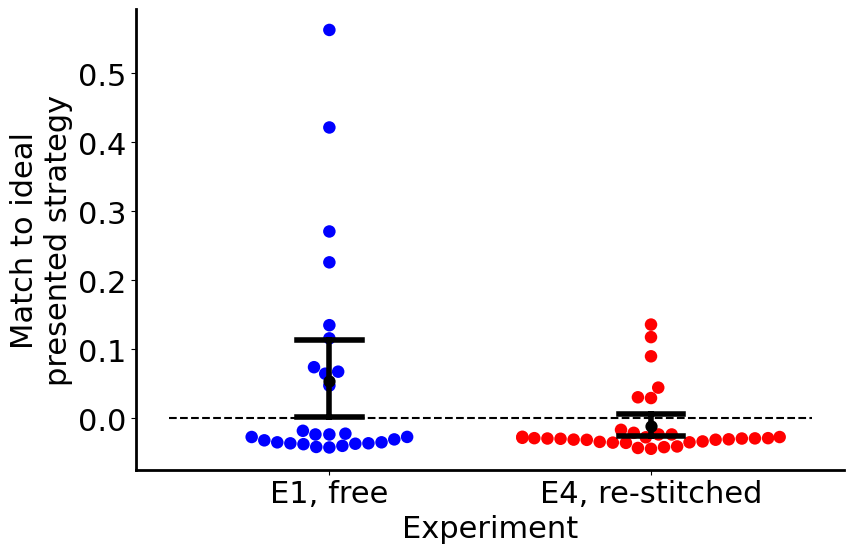

In [72]:
#fig 3 analyses comparing exp 1 vs 4 (Fig 5C)
astats1(no_no_ev1,0,'nono_ev,group1')
astats1(no_no_ev4,0,'nono_ev,group4')
astats3(no_no_ev1,no_no_ev4,'nonoVnono_ev,group1V4')
ystr1='''Match to ideal
presented strategy'''
fn='figs/idealpresented_narr_order_exp1v4.pdf'
barswarm(no_no_ev1,no_no_ev4,[],[],ystr1,ystr1,fn,4)

# Create network graph of character co-occurrence - not in paper



In [73]:
node_n=np.sum(cmat,axis=0) #node size - used in plot below, based on screen time
G = nx.DiGraph() #graph
for i,c in enumerate(chars): # add node for each character
    G.add_node(c, size = node_n[i])

edge_n=np.zeros((len(chars),len(chars))) #edge size
for i,c in enumerate(chars):
    for ii,cc in enumerate(chars):
        if i!=ii:
            fill=np.logical_and(cmat[:,i]==1,cmat[:,ii]==1)
            edge_n[i,ii]=np.sum(fill)
            G.add_edge(c,cc, weight = np.sum(fill))

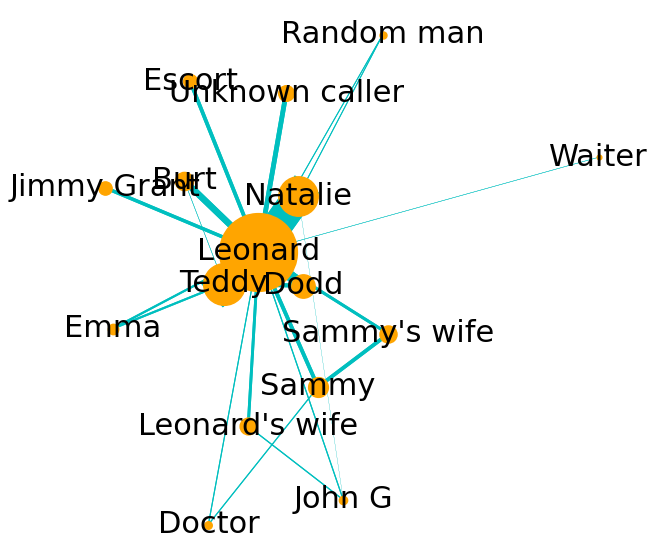

<Figure size 640x480 with 0 Axes>

In [74]:
#plot network graph
fs0=7

f, ax = plt.subplots(1,1,figsize = (fs0,fs0))
options = {'node_color': 'blue','edge_color':'orange','node_size': 100,'width': 3}
pos = nx.spring_layout(G)  # positions for all nodes
nrf=2 #node redux factor
erf=75 #edge redux factor
for i,c in enumerate(chars):
    plt.scatter(pos[c][0],pos[c][1],s=node_n[i]/nrf,c='orange',zorder=5) #nodes
    plt.text(pos[c][0],pos[c][1],c,ha='center', va='center',zorder=10)
    for ii,cc in enumerate(chars):
        if edge_n[i,ii]>0:
            plt.plot([pos[c][0],pos[cc][0]],[pos[c][1],pos[cc][1]],'c',linewidth=edge_n[i,ii]/erf,zorder=0) #nodes

plt.axis('off')
plt.show()
f.tight_layout()
fn=figf+"graph_network.pdf" #save doesn't work, fix later
plt.savefig(fn, transparent=True)

# Download files

In [75]:
# download files from colab onto computer
#see https://predictivehacks.com/?all-tips=how-to-download-files-and-folders-from-colab
!zip -r /content/figs.zip /content/figs
!zip -r /content/RStuff.zip /content/RStuff
files.download('/content/figs.zip') #uncomment to download!
files.download('/content/RStuff.zip') #uncomment to download!

  adding: content/figs/ (stored 0%)
  adding: content/figs/idealsemVcausal_narr_order_allexps.pdf (deflated 14%)
  adding: content/figs/xsub_memorability_bcent_sem_scat.pdf (deflated 13%)
  adding: content/figs/rev_causality_trans_graph2.pdf (deflated 1%)
  adding: content/figs/xsub_scene_memorability_caus_ev_scat.pdf (deflated 13%)
  adding: content/figs/xsub_memorability_deg_scat.pdf (deflated 13%)
  adding: content/figs/xsub_sceneE1_memorability_caus_ev_scat.pdf (deflated 15%)
  adding: content/figs/xsub_sceneE2_memorability_caus_ev_scat.pdf (deflated 14%)
  adding: content/figs/all_ideal_subjects.pdf (deflated 14%)
  adding: content/figs/ideal_subs_narr_jumps.pdf (deflated 10%)
  adding: content/figs/xsubE3_scene_memorability_chrono_ev_scat.pdf (deflated 15%)
  adding: content/figs/top_causality_trans_graph2.pdf (deflated 5%)
  adding: content/figs/outw_by_scene.pdf (deflated 11%)
  adding: content/figs/xsub_sceneE3_memorability_caus_ev_scat.pdf (deflated 15%)
  adding: content/fig

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>